 # Bitcoin and Ethereum price forecasting using Learning Algorithms

---

Goals:

•	Try to predict trends and patterns in Bitcoin price variation based on previous variations.

•	Enable me to identify what are the key factors that shape trends and patterns in Bitcoin value. 


How I’m going to do it:

•	Turn the original regression problem into a classification one, the latter which will most likely reduced the noise related to sudden variations. 

•	Pick a certain time unit (day, week…) which will enable me to examine variation on a day-to-day/week-to-week… basis. 

•	Set up a binary variable (example: 1 for high, 0 for low, regarding the value) which will speak for every variation. This way, the argument is that if it was consecutively high for a certain number of days, the probability of it dropping suddenly decreases. 



• In regards to the predictor variables, I am going to conduct personal research on the side to determine the following things, which I think can potentially be highly correlated to the value of Bitcoin:

o Public opinion: Note that Bitcoin emerged in 2009, in the wake of the worst financial crisis in History. This means that the population is one that has completely lost trust in the financial system and economists are for the first time doubting the capitalist system. Bitcoin therefore emerges, thanks to its decentralized transaction system as a potential alternative to all this, for a population disappointed by the Central Banks. Moreover, I tend to believe that similarly to all financial trends the public opinion at a certain moment can participate in creating certain “hypes”, which is explanatory of variations. Public opinion regarding Bitcoin can be measured through social media. I thought of scraping tweets at various times over the last years using NLP to try to examine the feeling about Bitcoin over time (try to extract words such as “bubble”, “future”…). This, as well as data from cryptocurrency forums would constitute in my opinion an accurate predictor. In order to analyze public opinion, I am thinking of scraping data from social networks. I will then apply sentiment analysis to the data I have scraped.

o Appearance of other cryptocurrencies: With the increase of competition, Bitcoin must’ve gained notoriety for being the first cryptocurrency out there. Now, I also want to see if it seems to follow the same variations.

This project is going to be organised in three parts. The first part is going to be focused on the price forecasting of Bitcoin and Ethereum and the second part is going to constitute an analysis of the public opinion regarding cryptocurrencies. Finally, the third part of the project is going to be dedicated to putting the first two parts together. 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Part 1: Time series Analysis

## 1.1. EDA and Cleaning

In [3]:
# Reading in the data

btc = pd.read_csv('/Users/jamesliounis/documents/Capstone Project DSI/BTC-USD-2.csv')
eth = pd.read_csv('/Users/jamesliounis/documents/Capstone Project DSI/ETH-USD.csv')

In [4]:
btc.head()
eth.head()

Date    Open  High     Low  Close  Adj Close  Volume
0  2015-08-06  0.6747   3.0  0.6747   3.00       3.00     371
1  2015-08-07  3.0000   3.0  0.1500   1.20       1.20    1438
2  2015-08-08  1.2000   1.2  1.2000   1.20       1.20       0
3  2015-08-09  1.2000   1.2  1.2000   1.20       1.20       0
4  2015-08-10  1.2000   1.2  0.6504   0.99       0.99    7419

### 1.1.1. Data Dictionary

In [5]:
# I find it important to create 2 data dictionaries, with a description of what each column is

btc_data_dict = {'Date':'Calendar date','Open':'BTC price at the opening of the markets','High':'Higest daily BTC price'
                 ,'Low':'Lowest daily BTC price','Close':'BTC price at the closing of the markets','Adj Close':'Adjusted Closing Price',
                 'Volume':'Total number of Bitcoin'}

eth_data_dict = {'Date':'Calendar date','Open':'ETH price at the opening of the markets','High':'Higest daily ETH price',
                 'Low':'Lowest daily ETH price','Close':'ETH price at the closing of the markets','Adj Close':'Adjusted Closing Price',
                 'Volume':'Total number of Ethereum'}

print('Bitcoin data dictionary:', btc_data_dict)

Bitcoin data dictionary: {'Date': 'Calendar date', 'Open': 'BTC price at the opening of the markets', 'High': 'Higest daily BTC price', 'Low': 'Lowest daily BTC price', 'Close': 'BTC price at the closing of the markets', 'Adj Close': 'Adjusted Closing Price', 'Volume': 'Total number of Bitcoin'}


In [6]:
print('Etheureum data dictionary:', eth_data_dict)

Etheureum data dictionary: {'Date': 'Calendar date', 'Open': 'ETH price at the opening of the markets', 'High': 'Higest daily ETH price', 'Low': 'Lowest daily ETH price', 'Close': 'ETH price at the closing of the markets', 'Adj Close': 'Adjusted Closing Price', 'Volume': 'Total number of Ethereum'}


In [7]:
# Checking for null values

print('Any null values in these datasets?')
print('For BTC?',btc.isnull().sum().any())
print('For ETH?',eth.isnull().sum().any())

# There are no null values in both datasets. No extra cleaning necessary

Any null values in these datasets?
For BTC? False
For ETH? False


In [8]:
# Checking to see if any cleaning is necessary regarding our data types

btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 7 columns):
Date         2327 non-null object
Open         2327 non-null float64
High         2327 non-null float64
Low          2327 non-null float64
Close        2327 non-null float64
Adj Close    2327 non-null float64
Volume       2327 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 127.3+ KB


In [9]:
btc.dtypes

# We notice that the Date is not yet a datetime object

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [10]:
# Same for ethereum

eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 7 columns):
Date         1012 non-null object
Open         1012 non-null float64
High         1012 non-null float64
Low          1012 non-null float64
Close        1012 non-null float64
Adj Close    1012 non-null float64
Volume       1012 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 55.4+ KB


In [11]:
eth.dtypes

# Same issue regarding the date as for Bitcoin

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [12]:
# We want first of all to convert Dates in both the datasets to datetime objects

btc['Date'] = pd.to_datetime(btc['Date'])
eth['Date'] = pd.to_datetime(eth['Date'])

# We then want to replace both these types inside the dataframes to be able to work with them and we set it
# as the index:

btc.set_index('Date',inplace = True)
eth.set_index('Date',inplace=True)

# Both the indexes must be datetime objects now. 

In [13]:
print(btc.index.dtype)
print(eth.index.dtype)

# They are indeed now both datetime objects

datetime64[ns]
datetime64[ns]


In [14]:
# We want to transform the data to get the average price grouped by the day in order to plot the price evolution

group = btc.groupby('Date')
btc_daily_price = group['Close'].mean()

group_2 = eth.groupby('Date')
eth_daily_price = group_2['Close'].mean()

### 1.1.2. Price evolution plots

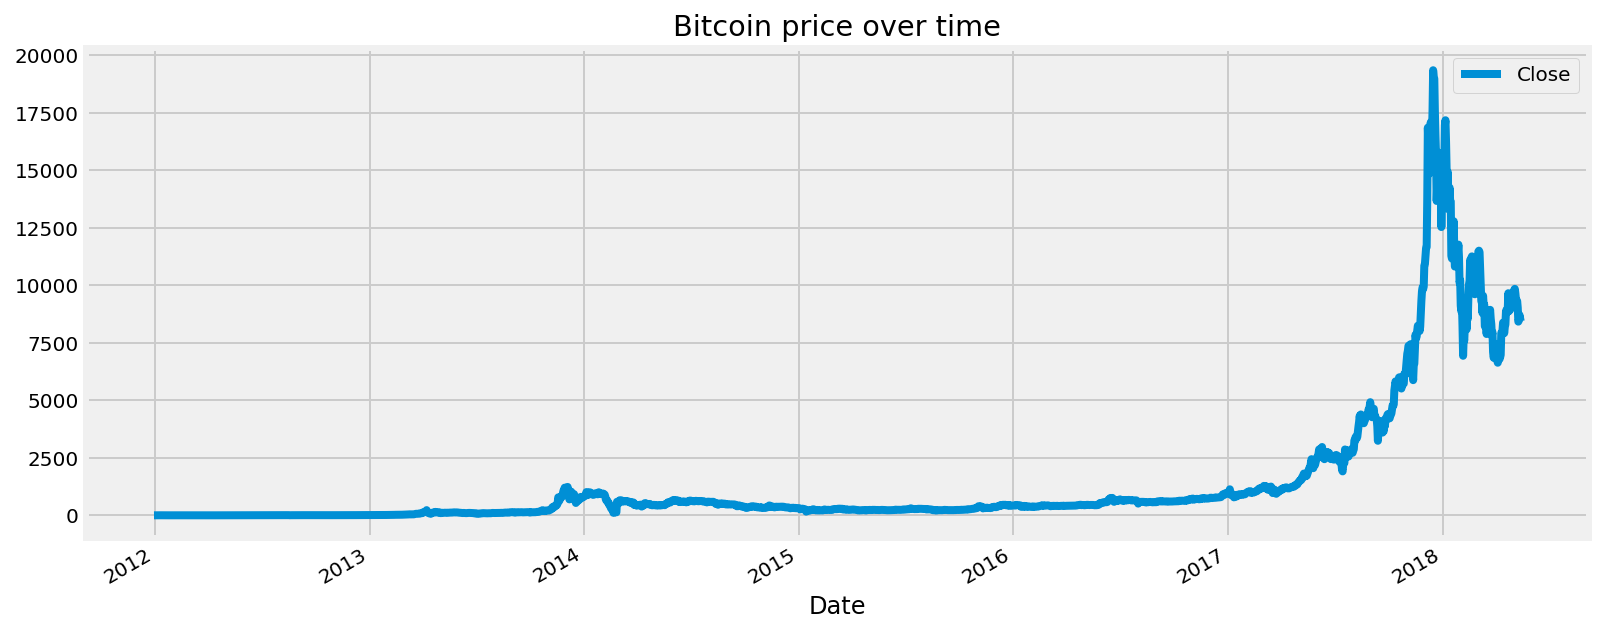

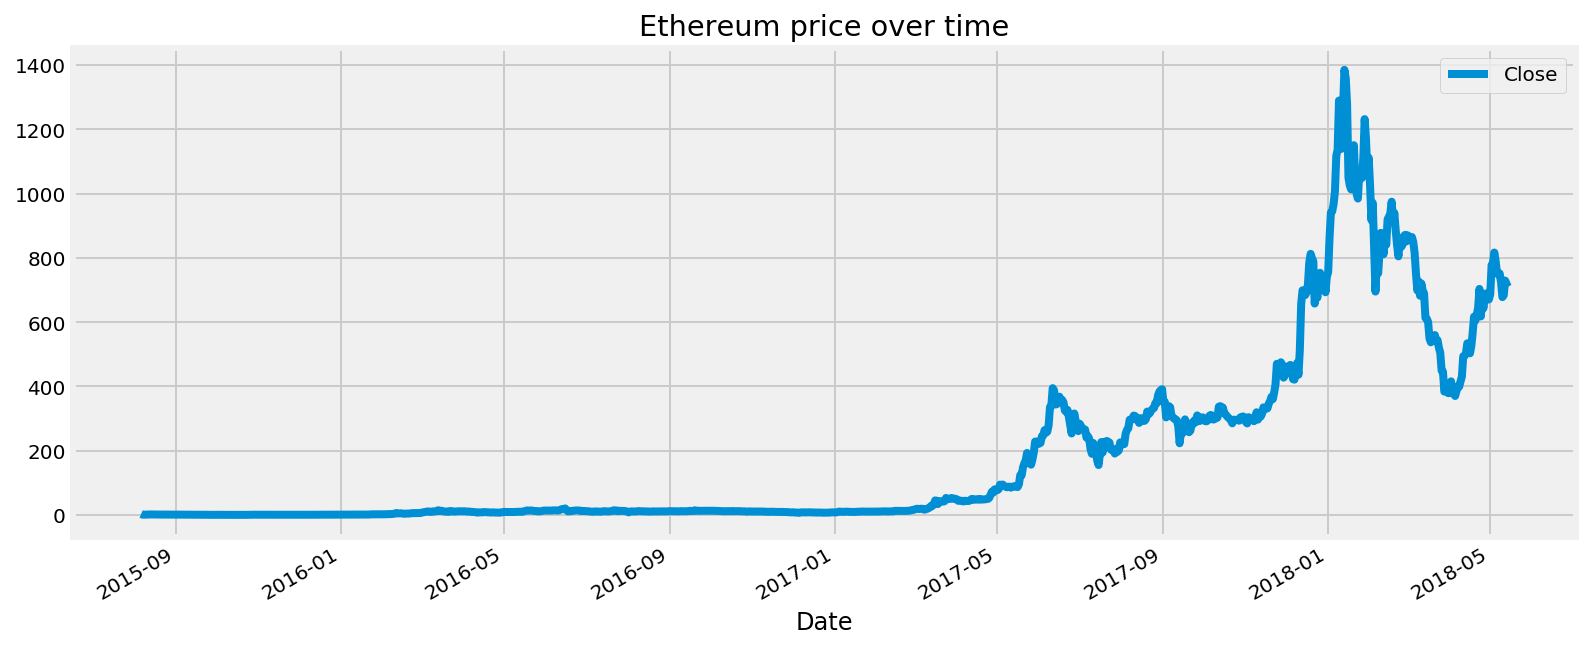

In [15]:
# We put the transformed data into dataframes and then plot it

btc_daily_price = pd.DataFrame(btc_daily_price)
eth_daily_price = pd.DataFrame(eth_daily_price)


btc_daily_price.plot(figsize=(12,5), title='Bitcoin price over time');
eth_daily_price.plot(figsize=(12,5), title='Ethereum price over time');


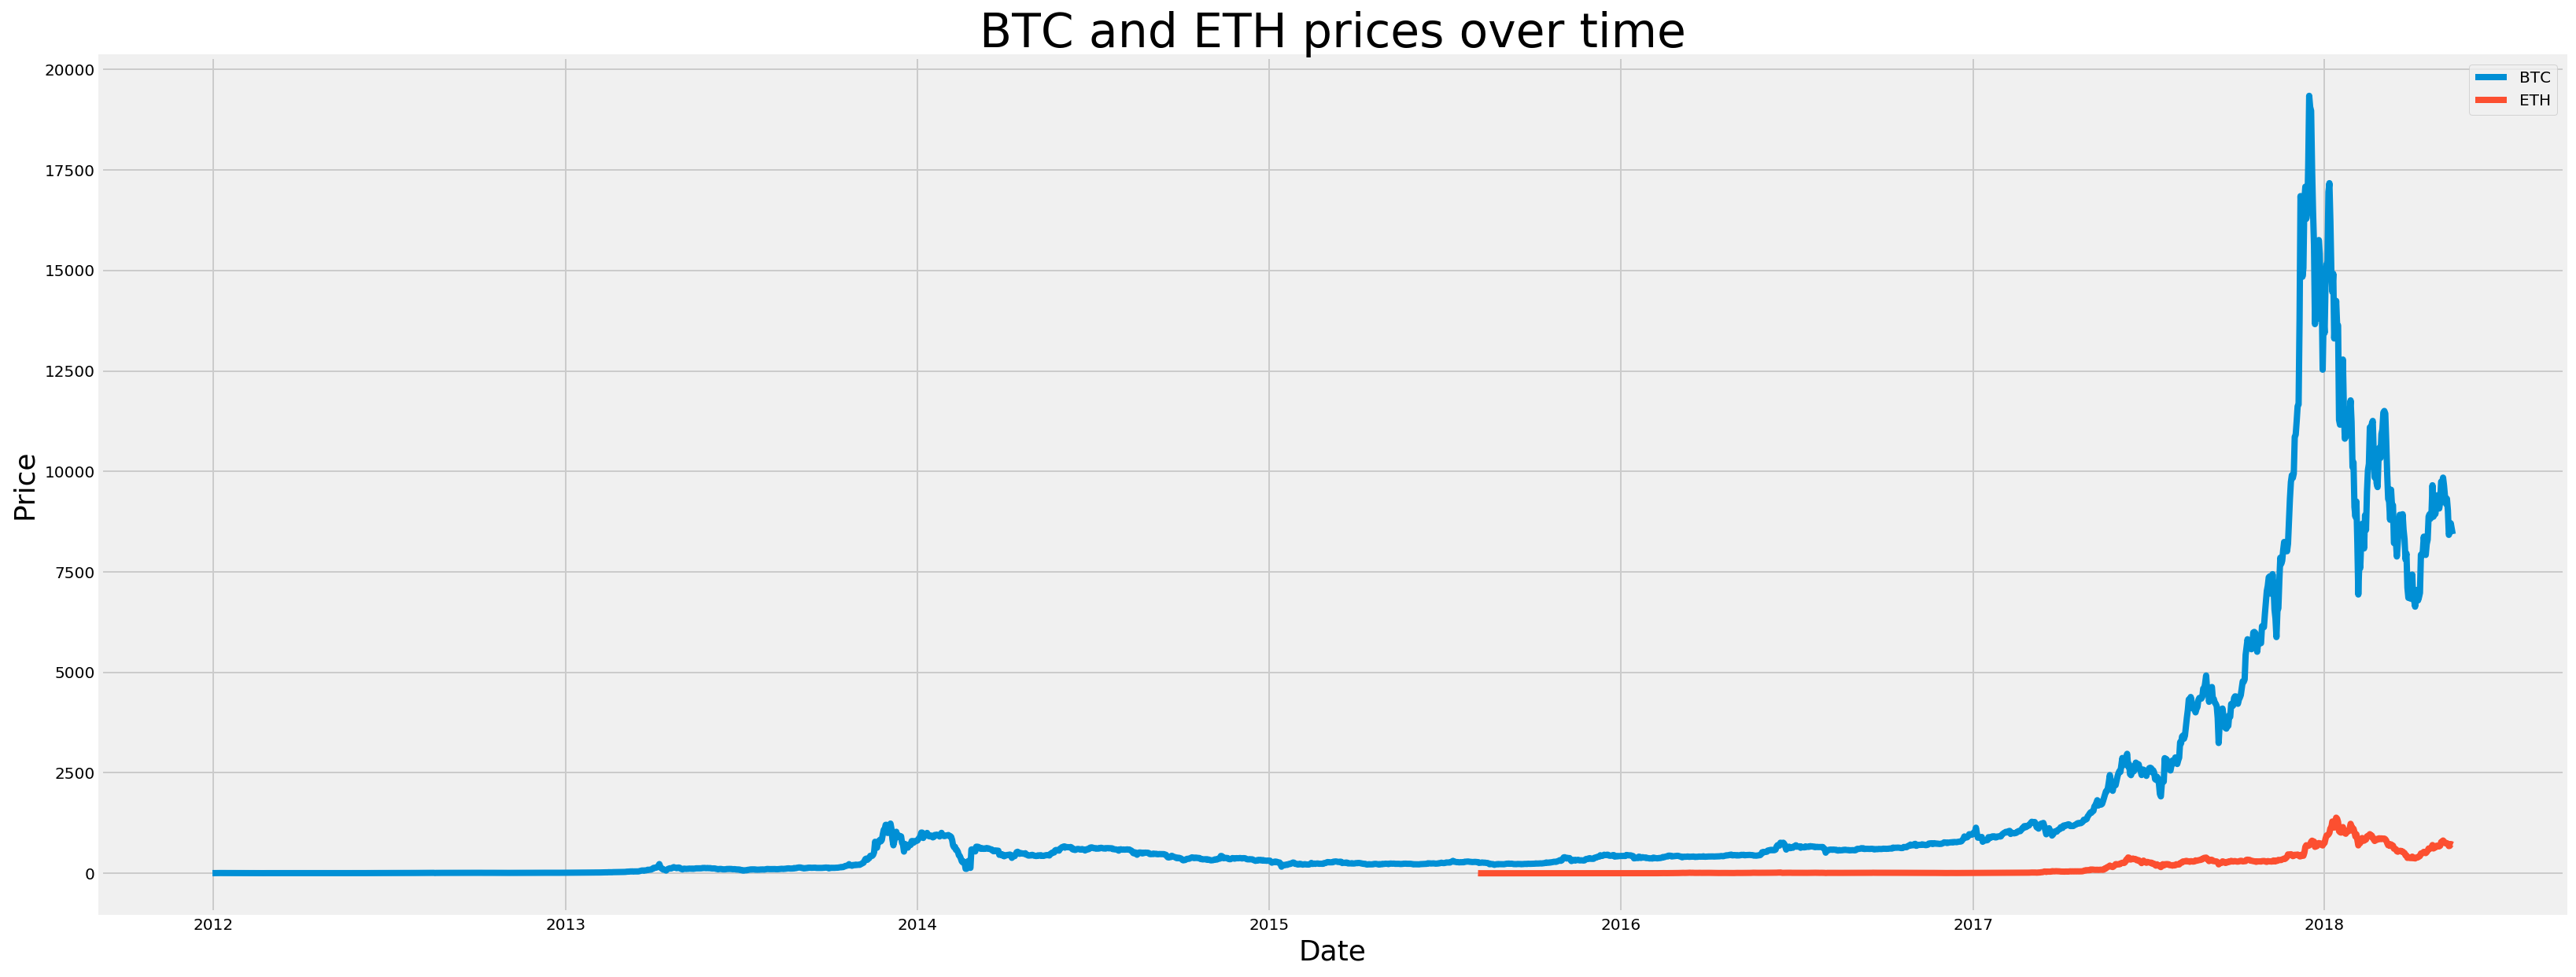

In [16]:
Fig, ax = plt.subplots(figsize=(25, 10))

ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Price', fontsize=18)
ax.set_title('BTC and ETH prices over time', fontsize=30)

ax.plot(btc_daily_price.Close, label='BTC')
ax.legend(loc='upper right')

ax.plot(eth_daily_price.Close, label='ETH')
ax.legend(loc='upper right');

By plotting them together, and looking closer with the graphs above, we can observe some trends. First of all, both the Cryptocurrencies seem to soar at the same time which is late 2017 to then plummet once again in early 2018. Here, even though Ethereum never reaches the price of Bitcoin, the trends and the patterns seem to remain the same. However, one difference between the two remains the fact that the Ethereum price seems to have experienced a slightly shakier ascension as it dropped ~$200 in 2017 while Bitcoin prices were climbing steadily. 

### 1.1.3. Price evolution observation

In [17]:
# As the price is our target variable, we first do a high level overview of the price
# I chose to perform the analysis using the price recorded at the closing of the markets

print('Bitcoin average price:', btc['Close'].mean()) # Equivalent to mean of btc_daily_price
print('Ethereum average price:',eth['Close'].mean()) # Equivalent to mean of eth_daily_price

Bitcoin average price: 1435.5398492303393
Ethereum average price: 185.81327539426871


In [18]:
# Looking at the means of both the variables, I find that it might not be a good idea to set up a binary variable
# based on average for Bitcoin as the average is $1282 and it has been over that for most of the time (same for ether).
# I'm going to try to look at the medians of both these variables since it might be more pertinent. 

print('Bitcoin median price', btc['Close'].median())
print('Ethereum median price', eth['Close'].median())

# However, we can see that these numbers are even less relevant. Therefore, we will be using the mean. 

Bitcoin median price 404.459991
Ethereum median price 12.87


In [19]:
# In order to assist us in deciding which dates to include in our training and testing datasets I proceed in creating 
# masks in order to include in the data I choose both points in time where Bitcoin was of average and high value


btc_mask = btc_daily_price.loc[btc_daily_price['Close']>1000]
btc_mask_2 = btc_daily_price.loc[btc_daily_price['Close']>3000]
btc_mask_3 = btc_daily_price.loc[btc_daily_price['Close']>5000]

# We print all three masks in order to see which dates will be of interest to us regarding Bitcoin prices

btc_mask[:1]

Close
Date                   
2013-11-27  1079.890015

In [20]:
btc_mask_2[:1]

Close
Date                   
2017-08-04  3262.800049

In [21]:
btc_mask_3[:1]

Close
Date                   
2017-10-11  5432.620117

In [22]:
# We are going to perform normal TSA and then we'll turn to classifying whether it's high or low
# We are splitting the dataset because we want to train and test the model only on some portion of the data
# In this cell, we are counting the necessary parameters for splitting the data which means that we are counting
# the number of days between these dates.


from datetime import date

d0 = date(2016, 1, 1)   # We are training the model on data from January 1st 2016 to October 27th 2017
d1 = date(2017, 10, 27)
delta = d1 - d0
training_days = delta.days + 1
print('Days we are training the model on:', training_days)

d0 = date(2017, 8, 21) # We are testing it on data from August 21st 2017 to October 20th 2017
d1 = date(2017, 10, 20)
delta = d1 - d0
testing_days = delta.days + 1
print('Days we are testing the model on:', testing_days)

d0 = date(2017, 10, 15)
d1 = date(2017, 10, 20)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

Days we are training the model on: 666
Days we are testing the model on: 61
6


In [23]:
# Now we split the data into training and testing data
# Again, this is only for Bitcoin

b_df_train= btc_daily_price[len(btc_daily_price)-training_days-days_from_end:len(btc_daily_price)-testing_days]
b_df_test= btc_daily_price[len(btc_daily_price)-testing_days:]

print(len(b_df_train), len(b_df_test))

611 61


In [24]:
# We have to perform the same operation for the Ethereum dataset:

# In order to have approximately the same percentage of days in the training and testing data for both models, 
# I have found according to other works on the matter that the ideal number of days in the decomposition is:
# 28.7% in the training, 2.6% in the testing and 0.26% in days from end

ed0 = date(2017, 3, 1)   # We are training the model on data from March 1st 2017 to November 19th 2017: 264 days
ed1 = date(2017, 11, 19)
delta = ed1 - ed0
e_training_days = delta.days + 1
print('Days we are training the model on:', e_training_days)

ed0 = date(2017, 11, 19) # We are testing it on data from November 19th 2017 to January 18th 2018: 61 days
ed1 = date(2018, 1, 18)
delta = ed1 - ed0
e_testing_days = delta.days + 1
print('Days we are testing the model on:', e_testing_days)

ed0 = date(2018, 5, 5)
ed1 = date(2018, 5, 5)
delta = ed1 - ed0
e_days_from_end = delta.days + 1
print(e_days_from_end)

Days we are training the model on: 264
Days we are testing the model on: 61
1


In [25]:
# We now repeat the train-test-split on the Ethereum dataset:

e_df_train= eth_daily_price[len(eth_daily_price)-e_training_days-e_days_from_end:len(eth_daily_price)-e_testing_days]
e_df_test= eth_daily_price[len(eth_daily_price)-e_testing_days:]

print(len(e_df_train), len(e_df_test))

204 61


In [26]:
# Stacking the dataframes

btc_stacked = btc.stack()

eth_stacked = eth.stack()

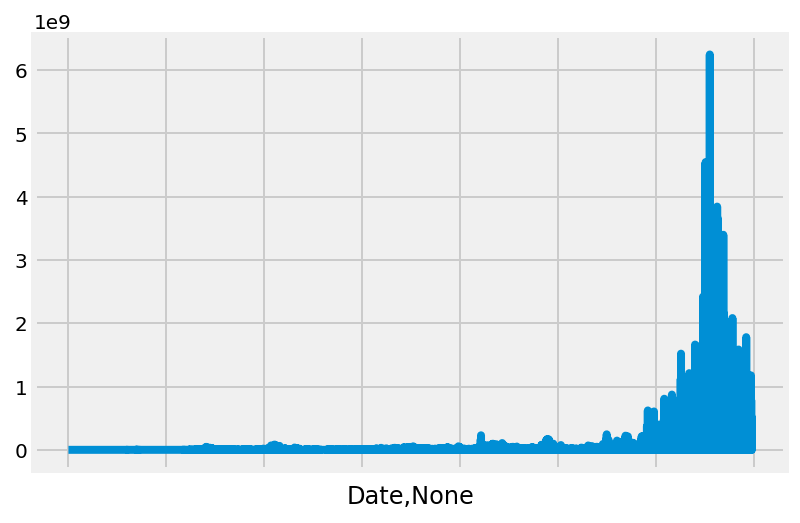

In [27]:
# We now have a different plot from the plot above: instead of having a line we now have a stacked chart

btc_stacked.plot()
plt.xticks(rotation=45)
plt.show()


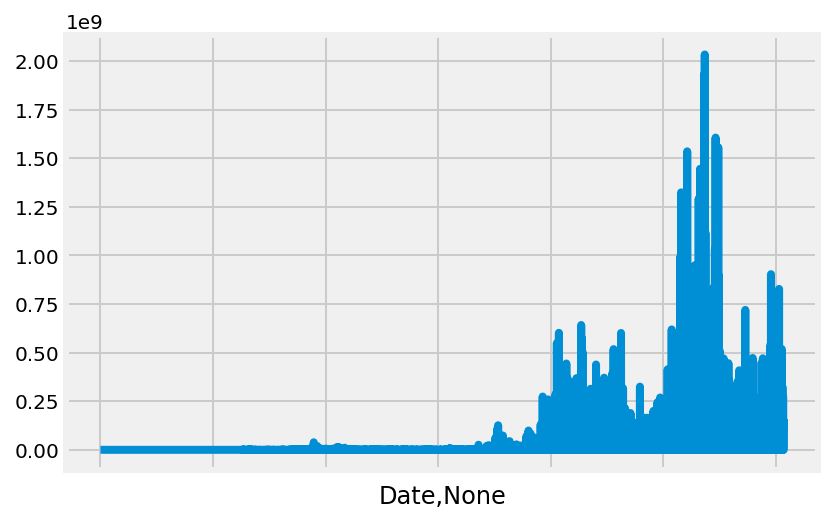

In [28]:
eth_stacked.plot()
plt.xticks(rotation=45)
plt.show()

### 1.1.4. Interesting facts about Bitcoin and Ethereum

Here, I thought it would be interesting to point out some interesting facts about both these cryptocurrencies such for example the amplitude of their price evolution from their first day in the markets to their all-time high. 

#### 1.1.4.1. Evolution since the beginning

In [291]:
# Using this to find the first btc highest value

btc.index[0]

Timestamp('2011-12-31 00:00:00')

In [323]:
first_btc_values = btc.loc[btc.index == btc.index[0]]
first_highest_btc_value = first_btc_values.High
# Recalling that we saved the highest price BTC ever reached as a variable in the second part of the project:

first_highest_btc_value = 5

btc_all_time_evolution = btc_highest/first_highest_btc_value

btc_all_time_evolution

print('From its introduction to its all time high, the value of BTC was multiplied by', btc_all_time_evolution, 'which is an evolution of ~',btc_all_time_evolution*100,'%')

From its introduction to its all time high, the value of BTC was multiplied by 3974.1238282 which is an evoltion of ~ 397412.38282 %


In [327]:
# Repeating the same steps for Ethereum:

print('Date eth was launched:',eth.index[0])
print('Highest value ever reached:',eth_highest)# Ethereum was launched on August 06th 2015. We want to calculate the 
                                                # Evolution between the value that day and the value at its peak

Date eth was launched: 2015-08-06 00:00:00
Highest value ever reached: 1422.859985


In [330]:
first_eth_values = eth.loc[eth.index == eth.index[0]]
first_highest_eth_value = first_eth_values.High
# Recalling that we saved the highest price BTC ever reached as a variable in the second part of the project:

first_highest_eth_value = 3

eth_all_time_evolution = eth_highest/first_highest_eth_value

eth_all_time_evolution

print('From its introduction to its all time high, the value of ETH was multiplied by', eth_all_time_evolution, 'which is an evolution of ~',eth_all_time_evolution*100,'%')

From its introduction to its all time high, the value of ETH was multiplied by 474.2866616666667 which is an evolution of ~ 47428.66616666667 %


#### 1.1.4.2. Evolution since the beginning of their ascent

I now also need to calculate the difference between when both of these cryptocurrencies began their ascent to their peak, which would be a more significant evolution. Using the price evolution plots of both these cryptocurrencies, I picked January 1st 2017 as the beginning of the important expansion of Bitcoin, and March 1st 2017 for Ethereum. 

In [337]:
btc_exp_beginning_value = btc.loc['2017-01-01']
btc_evolution = btc_highest/btc_exp_beginning_value.High

print('From the beginning of its expansion to its highest value, BTCs value was multiplied by', btc_evolution,'which corresponds to an evolution of ~',btc_evolution*100,'%')

From the beginning of its expansion to its highest value, BTCs value was multiplied by 19.838679165124336 which corresponds to an evolution of ~ 1983.8679165124336 %


In [338]:
eth_exp_beginning_value = eth.loc['2017-03-01']
eth_evolution = eth_highest/eth_exp_beginning_value.High

print('From the beginning of its expansion to its highest value, ETHs value was multiplied by', eth_evolution,'which corresponds to an evolution of ~',eth_evolution*100,'%')

From the beginning of its expansion to its highest value, ETHs value was multiplied by 80.61529660056658 which corresponds to an evolution of ~ 8061.529660056658 %


## 1.2. Modeling 

### 1.2.1. Rolling mean

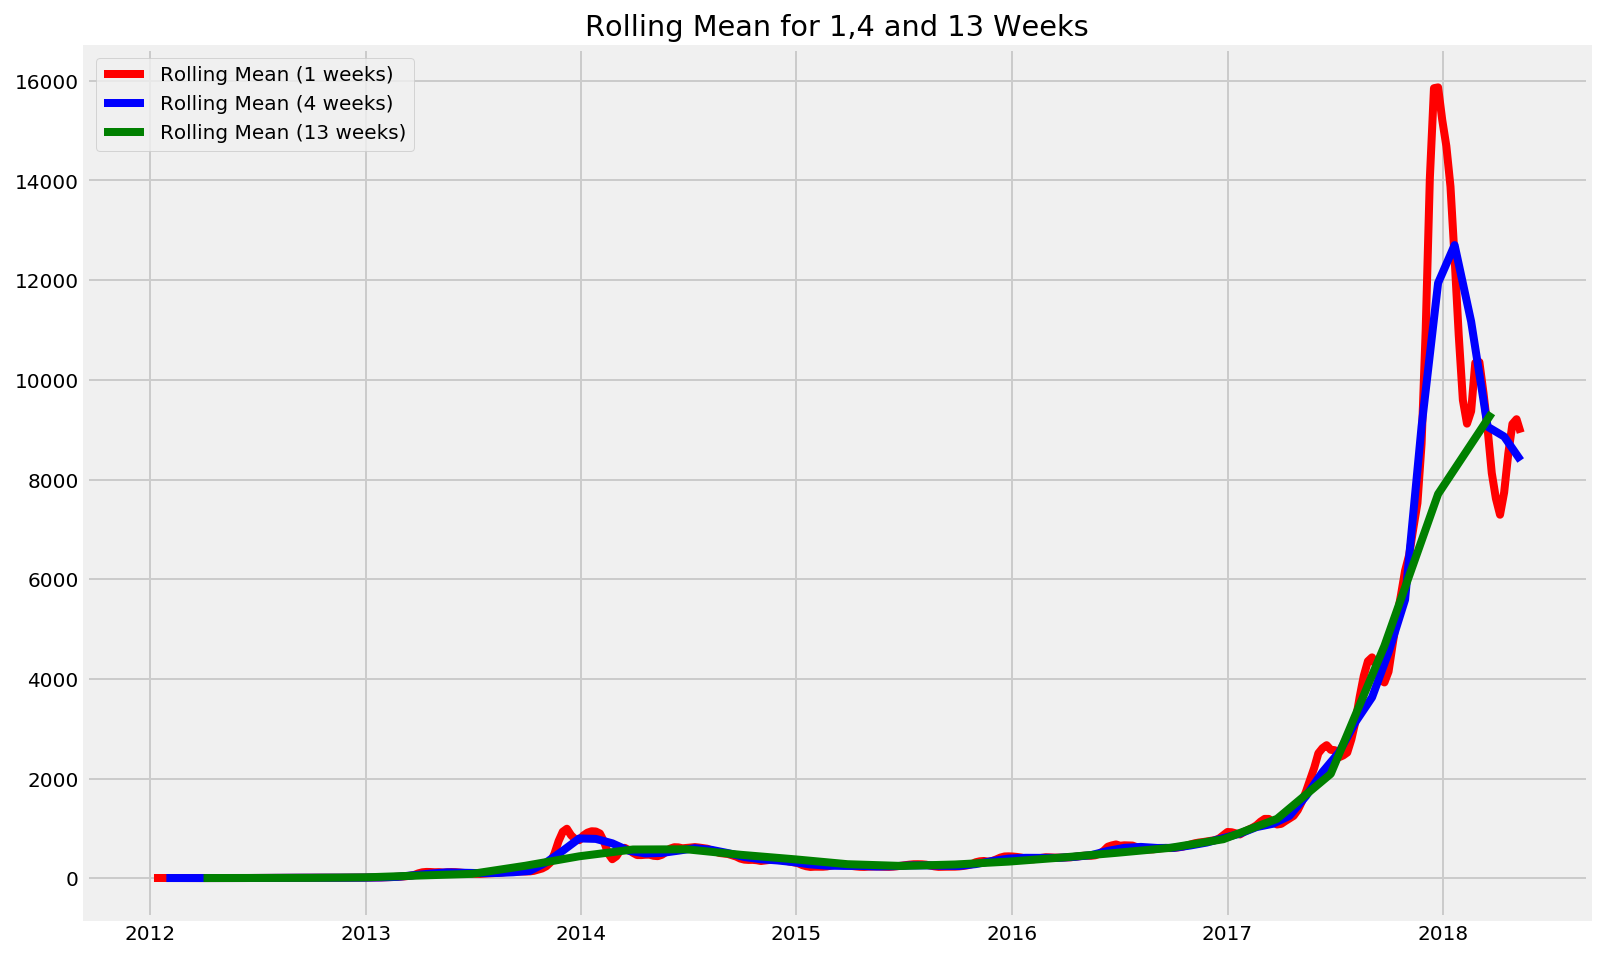

In [30]:
# We are going to plot the rolling mean for the Bitcoin price in order to try to observe general trends

rolmean = {}
for i in [1,4,13]:
    key = str(i)+'W'
    rolmean[i] = btc_daily_price.resample(key).mean().rolling(window=3, center=True).mean()

colors = ['r','b','g']
plt.figure(figsize=(12, 8))
for key,color in zip(list(rolmean.keys()),colors):
    plt.plot(rolmean[key], color=color, label='Rolling Mean ({} weeks)'.format(key))

plt.legend(loc='best')
plt.title('Rolling Mean for 1,4 and 13 Weeks')
plt.show()

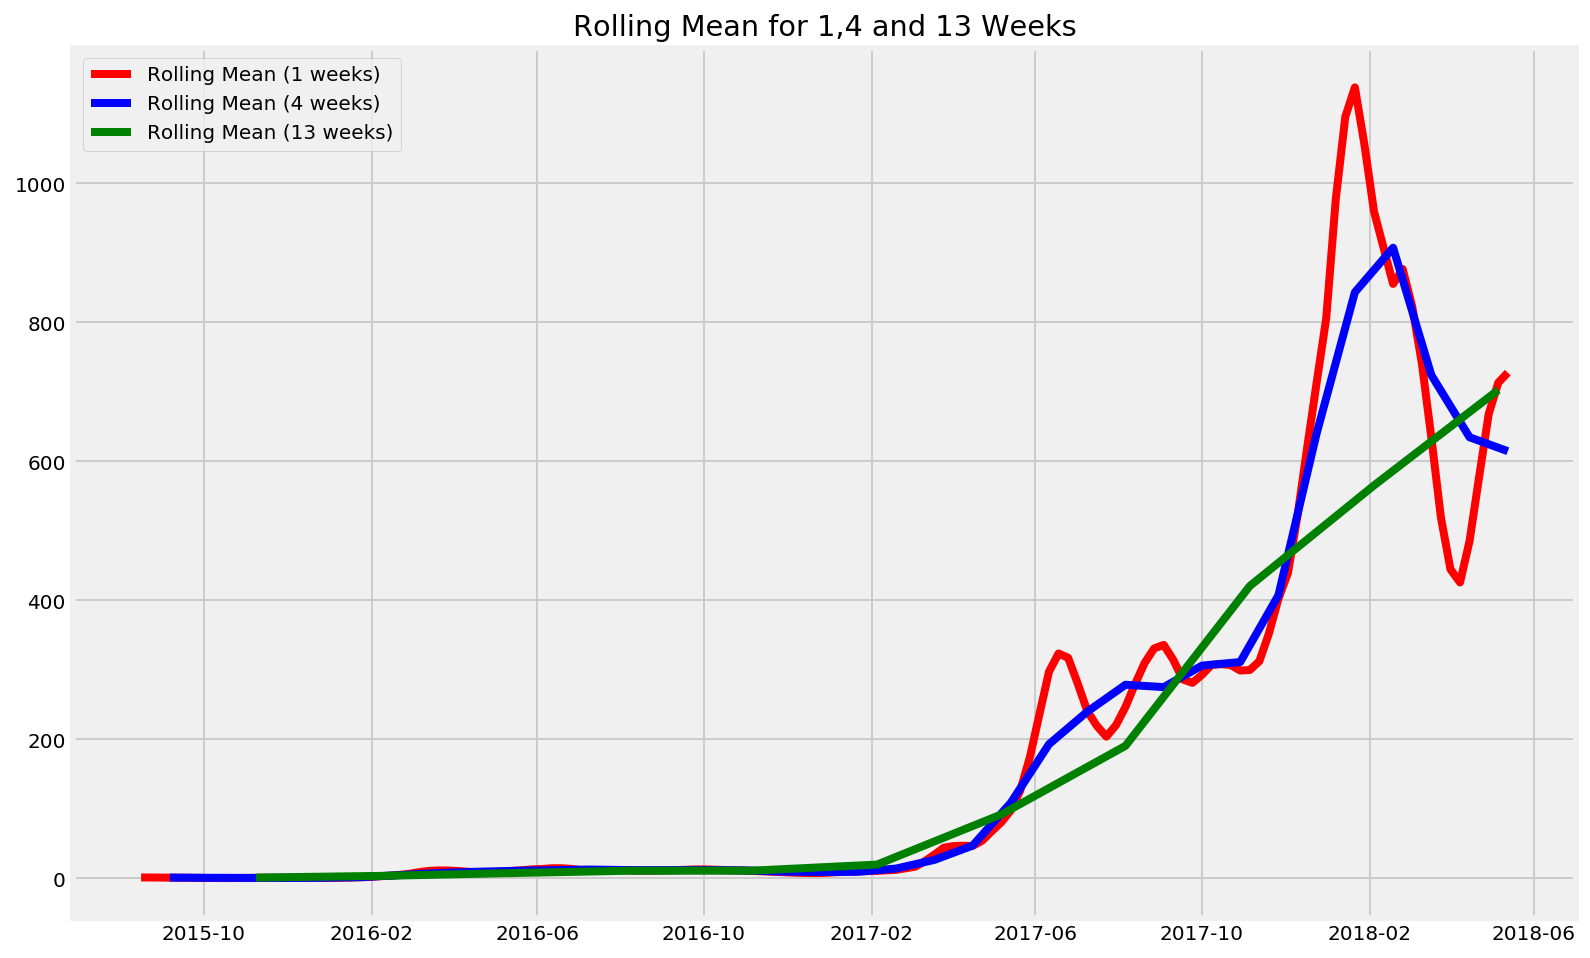

In [31]:
# We are doing the same for Ethereum:

rolmean = {}
for i in [1,4,13]:
    key = str(i)+'W'
    rolmean[i] = eth_daily_price.resample(key).mean().rolling(window=3, center=True).mean()

colors = ['r','b','g']
plt.figure(figsize=(12, 8))
for key,color in zip(list(rolmean.keys()),colors):
    plt.plot(rolmean[key], color=color, label='Rolling Mean ({} weeks)'.format(key))

plt.legend(loc='best')
plt.title('Rolling Mean for 1,4 and 13 Weeks')
plt.show()

### 1.2.2. Autocorrelation and Partial Autocorrelation

Computing 1, 2, 52 autocorrelations for Bitcoin daily price and creating an 
autocorrelation and partial autocorrelation plot.

In [32]:
# Computing 1, 2, 52 autocorrelations for Bitcoin daily price and creating an 
# autocorrelation and partial autocorrelation plot.
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [33]:
# Computing 1, 2, 52 autocorrelations for Bitcoin

for i in [1,2,52]:
    print('{} Week Lag AutoCorr'.format(i), btc['Close'].autocorr(lag=i))

1 Week Lag AutoCorr 0.9975951992634075
2 Week Lag AutoCorr 0.9948670546846599
52 Week Lag AutoCorr 0.8468740161303974


In [34]:
# Computing 1, 2, 52 autocorrelations for Ethereum

for i in [1,2,52]:
    print('{} Week Lag AutoCorr'.format(i), eth['Close'].autocorr(lag=i))

1 Week Lag AutoCorr 0.9967214271400535
2 Week Lag AutoCorr 0.9929823515362348
52 Week Lag AutoCorr 0.7853152513749312


### 1.2.3. ACF and PACF Plots

In [35]:
# We are now going to create a function that plots correlation and autocorrelation:

def autocorr_plots(y,lags=None):
    figure, ax = plt.subplots(ncols=2,figsize=(12,5),sharey=True)
    plot_acf(y, lags = lags,ax=ax[0])
    plot_pacf(y, lags = lags,ax=ax[1])
    plt.show()

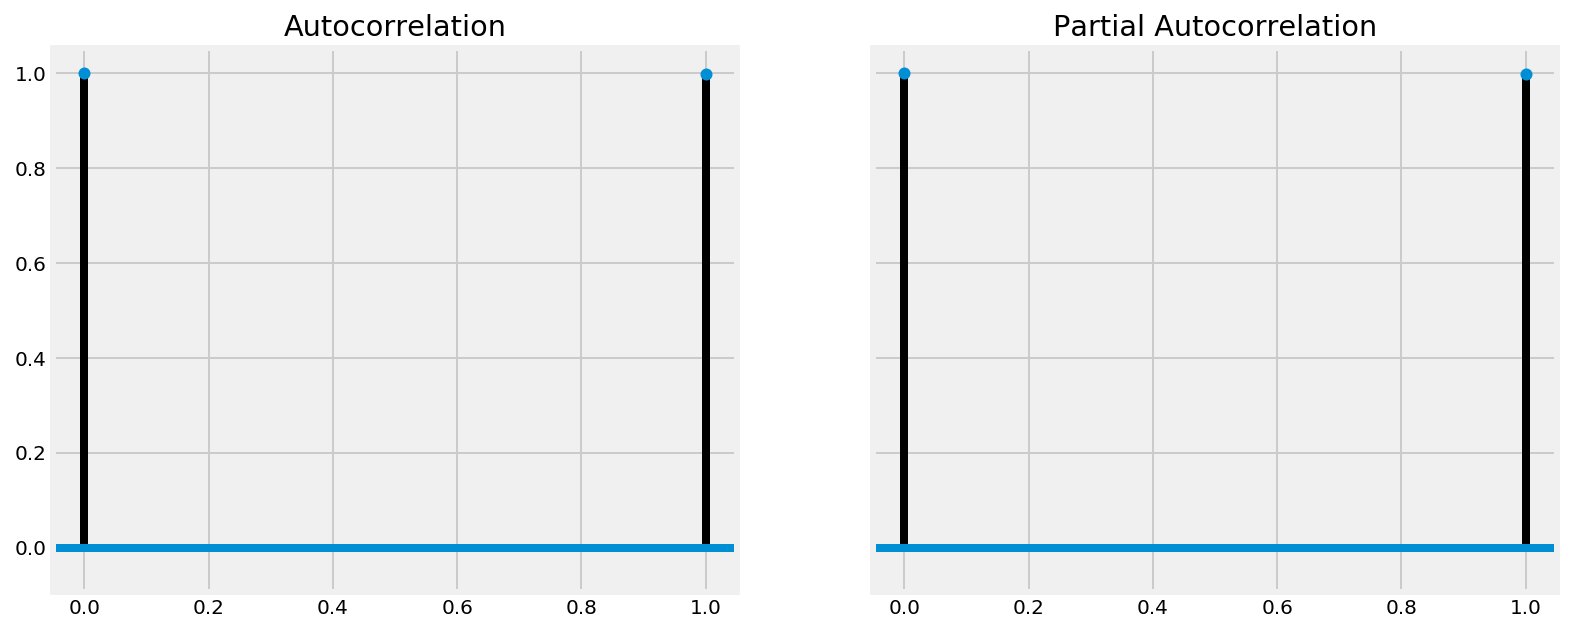

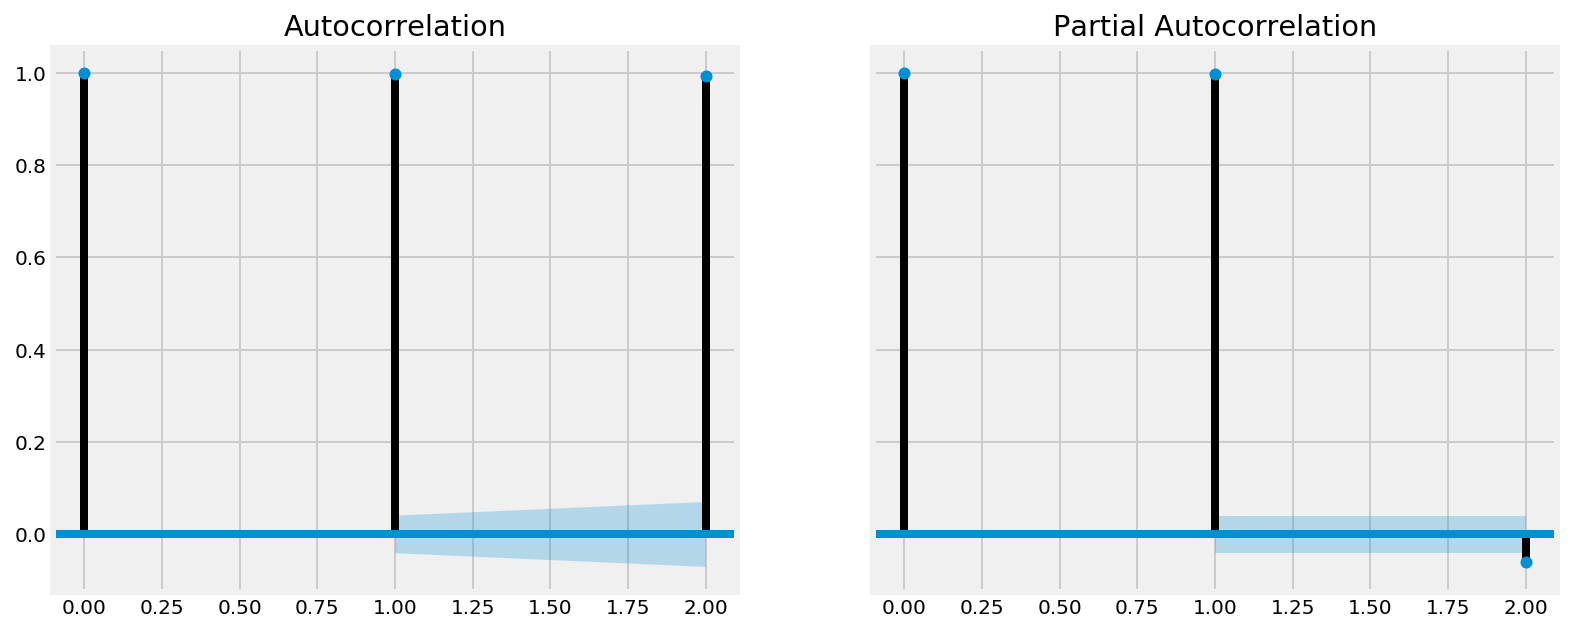

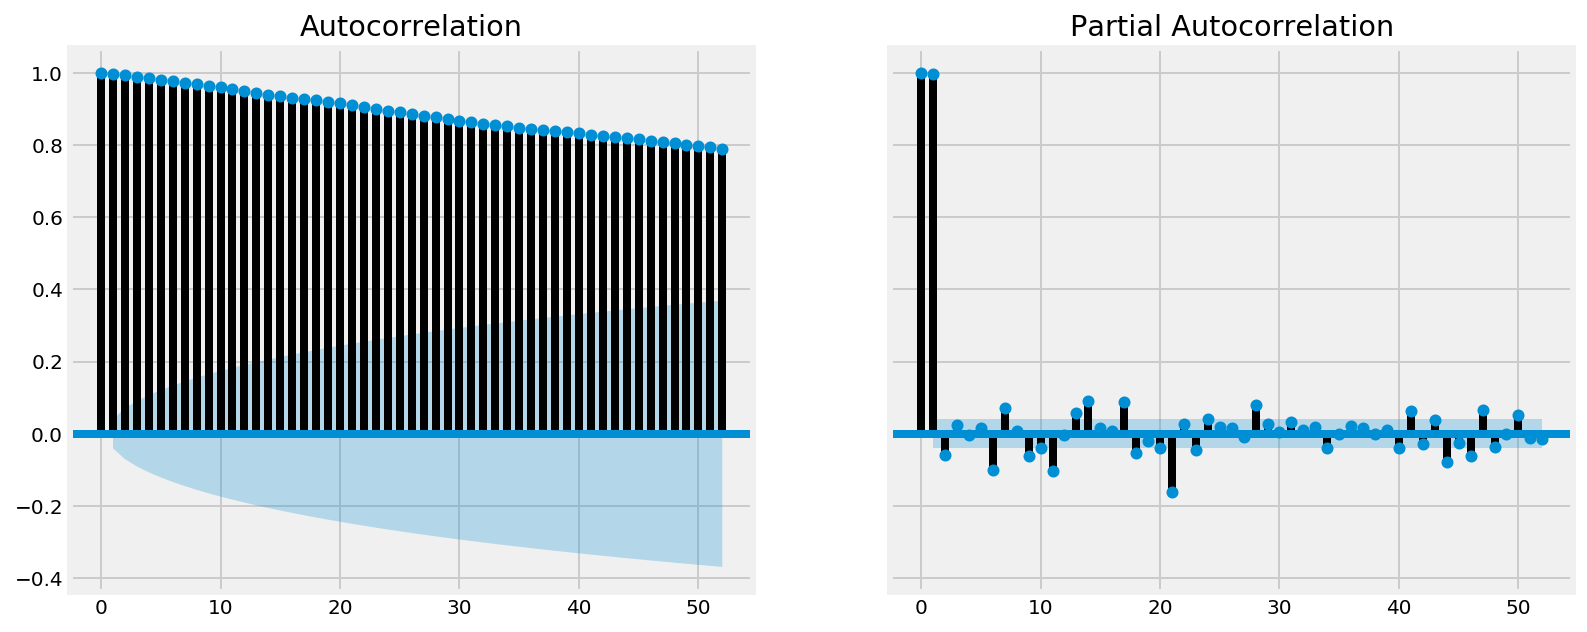

In [36]:
# Plotting autocorrelation and partial autocorrelation for Bitcoin

autocorr_plots(btc_daily_price,lags=1)
autocorr_plots(btc_daily_price,lags=2)
autocorr_plots(btc_daily_price,lags=52)

The filled blue space indicates the 95% confidence interval. The points inside the blue space are likely to be noise and do not imply any valuable correlation. With the default 95% confidence interval we can expect that 5% of observations could fall outside this boundary, and those that do are the ones we should consider for further investigation about correlation.
Lag 0: Apparently, the point at lag 0 has a high correlation (1.0)
Lag 1: Indicates a very high correlation between consecutive weeks.
Lag 2: High correlation as well.
Lag 4: There seems to be a monthly effect.
Lag 5: A 5 week negative correlation.
Lag 48: 11 months difference - compare to one month difference.
Lag 51: 51 weeks difference - compare to one week difference.
Lag 52: Annual seasonality.

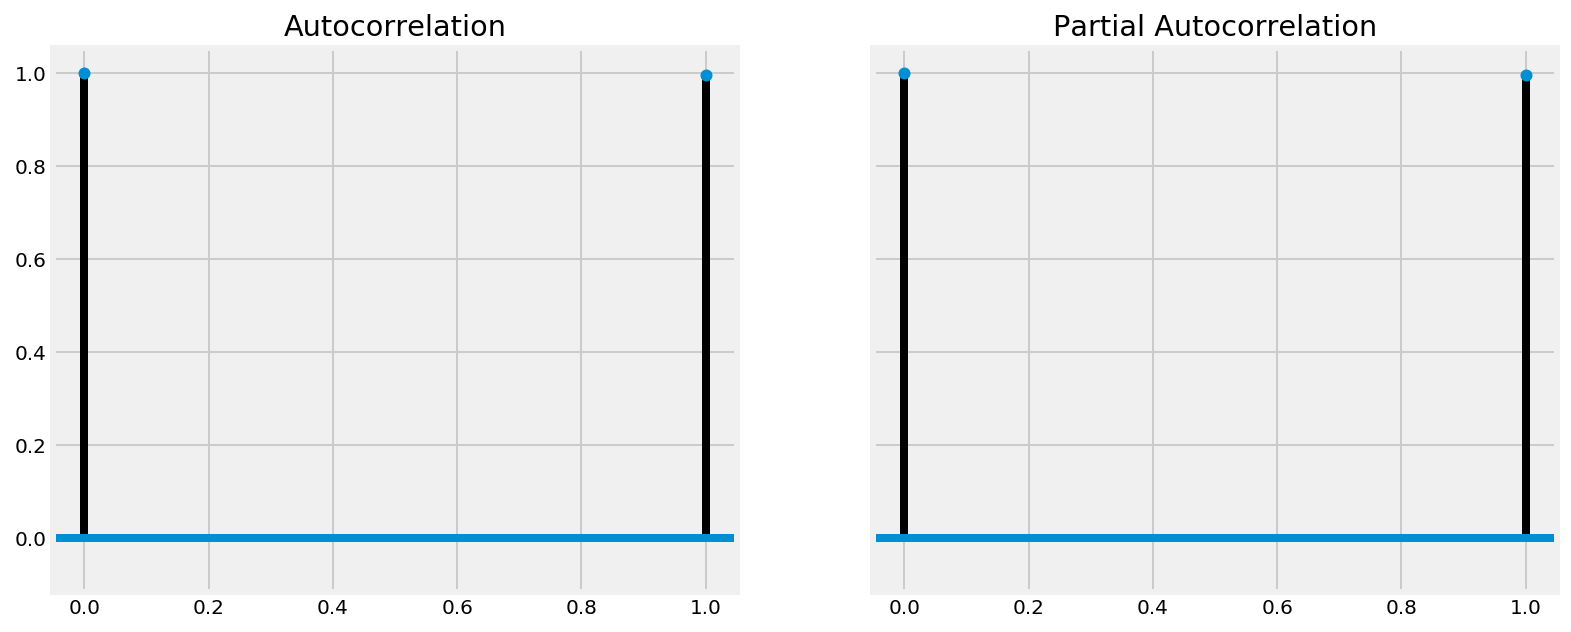

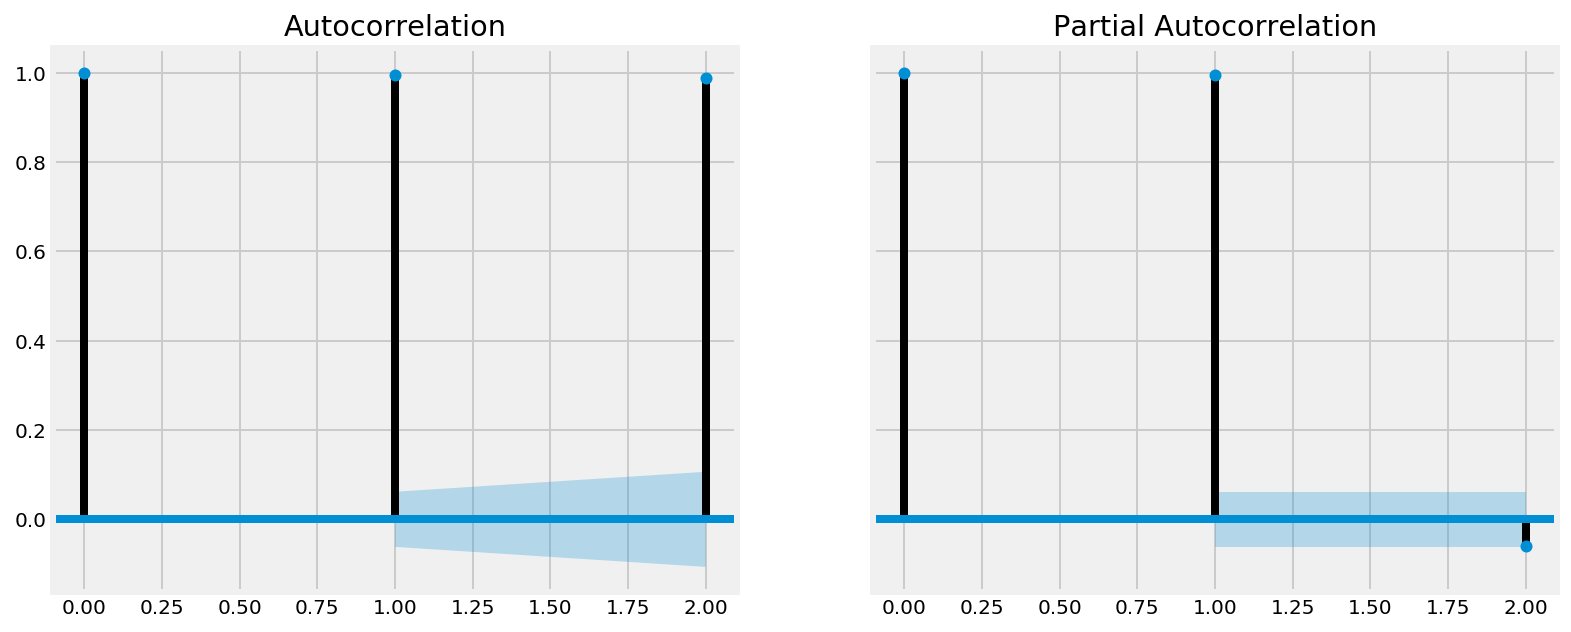

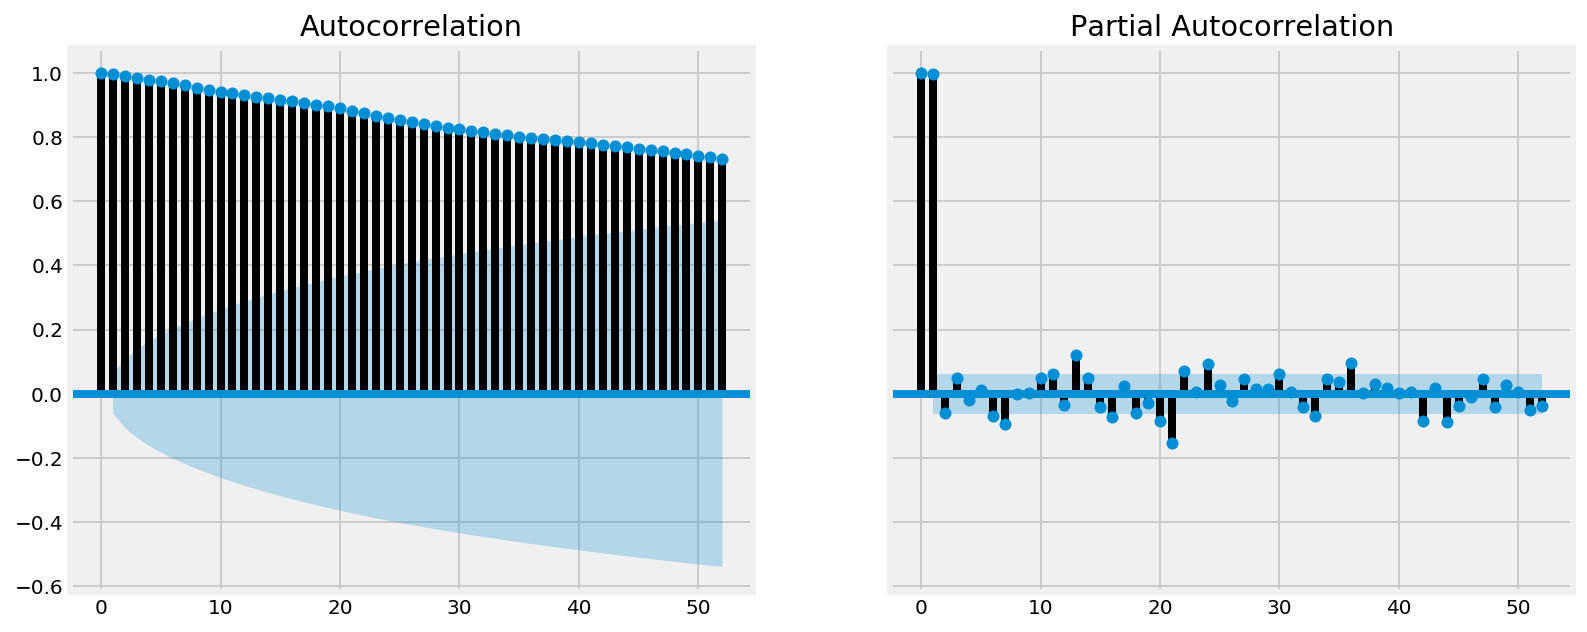

In [37]:
autocorr_plots(eth_daily_price,lags=1)
autocorr_plots(eth_daily_price,lags=2)
autocorr_plots(eth_daily_price,lags=52)

In [38]:
# Let's reming ourselves that we already have our data split up in training and testing sets:

# Here, I'm going to "difference" the data by converting the prices into changes in prices

btc_daily_price.diff(periods=1).head()

Close
Date             
2011-12-31    NaN
2012-01-01   0.55
2012-01-02  -0.05
2012-01-03  -0.34
2012-01-04   0.69

In [39]:
eth_daily_price.diff(periods=1).head()

Close
Date             
2015-08-06    NaN
2015-08-07  -1.80
2015-08-08   0.00
2015-08-09   0.00
2015-08-10  -0.21

### 1.2.4. AR(1)

#### 1.2.4.1. Modeling

In [40]:
# Fitting an AR(1) model on the training data and computing the root mean squared error of the predictions:

print('Training data for Bitcoin:') 
b_df_train.head()

Training data for Bitcoin:


Close
Date                  
2016-07-09  647.109985
2016-07-10  646.710022
2016-07-11  670.559998
2016-07-12  661.150024
2016-07-13  657.250000

In [41]:
print('Training data for ethereum:')
e_df_train.head()

Training data for ethereum:


Close
Date                  
2017-08-21  313.369995
2017-08-22  317.399994
2017-08-23  325.279999
2017-08-24  330.059998
2017-08-25  332.859985

In [42]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

# First fitting the model for Bitcoin

b_training_values = b_df_train['Close']
b_training_dates = b_df_train.index


b_AR1 = ARMA(endog = b_training_values, dates = b_training_dates, order = (1,0)).fit()


b_AR1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 9031.1149 
Dependent Variable: Close            Log-Likelihood:      -4505.9   
Date:               2018-06-01 11:39 Scale:               1.0000    
No. Observations:   611              Method:              css-mle   
Df Model:           2                Sample:              07-09-2016
Df Residuals:       609                                   03-13-2018
Converged:          1.0000           S.D. of innovations: 384.433   
AIC:                9017.8696        HQIC:                9023.022  
--------------------------------------------------------------------
              Coef.    Std.Err.    t     P>|t|    [0.025     0.975] 
--------------------------------------------------------------------
const       3874.5290 2983.4866   1.2987 0.1946 -1972.9974 9722.0553
ar.L1.Close    0.9961    0.0030 331.0676 0.0000     0.9902    1.0020
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0039             0.0000           1.0039             0.0000
====================================================================

"""

In [43]:
# Now fitting the same model on the Ethereum dataset:

e_training_values = e_df_train['Close']
e_training_dates = e_df_train.index


e_AR1 = ARMA(endog = e_df_train['Close'] , dates = e_df_train.index, order = (1,0)).fit()


e_AR1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 2165.1856 
Dependent Variable: Close            Log-Likelihood:      -1074.6   
Date:               2018-06-01 11:39 Scale:               1.0000    
No. Observations:   204              Method:              css-mle   
Df Model:           2                Sample:              08-21-2017
Df Residuals:       202                                   03-13-2018
Converged:          1.0000           S.D. of innovations: 46.521    
AIC:                2155.2313        HQIC:                2159.258  
---------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
const        552.8506  184.8575    2.9907  0.0031  190.5365  915.1647
ar.L1.Close    0.9865    0.0093  106.5730  0.0000    0.9684    1.0047
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0137             0.0000           1.0137             0.0000
====================================================================

"""

In [44]:
e_df_test.head()

Close
Date                  
2018-03-14  613.150024
2018-03-15  610.559998
2018-03-16  600.530029
2018-03-17  549.789978
2018-03-18  537.380005

In [45]:
# Taking a look at what the testing dataset looks like for Bitcoin

b_df_test.tail()

Close
Date                   
2018-05-09  9032.219727
2018-05-10  8421.000000
2018-05-11  8486.669922
2018-05-12  8709.459961
2018-05-14  8440.509766

In [46]:
# And for Ethereum

e_df_test.tail()

Close
Date                  
2018-05-09  723.609985
2018-05-10  677.799988
2018-05-11  683.640015
2018-05-12  729.340027
2018-05-14  710.450012

#### 1.2.4.2. Forecasting

In [47]:
# Predicting for Bitcoin:

b_test_values = b_df_test['Close']
b_test_dates = b_df_test.index

start = '2018-03-14'
end = '2018-05-14'

b_AR1_pred = b_AR1.predict(start=len(b_training_values)-1, end=len(b_training_values)+20)

b_AR1_pred

610    9121.769248
611    9139.669446
612    9119.297902
613    9099.005178
614    9078.790969
615    9058.654972
616    9038.596884
617    9018.616403
618    8998.713230
619    8978.887064
620    8959.137609
621    8939.464567
622    8919.867642
623    8900.346541
624    8880.900970
625    8861.530636
626    8842.235249
627    8823.014518
628    8803.868154
629    8784.795871
630    8765.797381
631    8746.872399
dtype: float64

In [48]:
# We can also forecast BTC prices using this method:

btc_forecasted_values_AR1 = b_AR1.forecast(20)

# Here, the first set of arrays is the predicted value, the second set is the standard error and the third set 
# is the predicted interval. Let's take the first set of values for example to verify that:
# (8386.19407308+9893.14481957)/2 = 9139.66 which is the predicted value (in the first array) and the mean
# of the two first values in the last array. Moreover, those two values plus or minus the standard error (second array)
# yield the result. 

btc_forecasted_values_AR1

(array([9139.66944633, 9119.29790208, 9099.0051781 , 9078.79096943,
        9058.65497229, 9038.59688405, 9018.61640329, 8998.71322972,
        8978.88706423, 8959.13760888, 8939.46456685, 8919.86764249,
        8900.3465413 , 8880.90096991, 8861.53063607, 8842.23524869,
        8823.01451778, 8803.8681545 , 8784.7958711 , 8765.79738095]),
 array([ 384.43327489,  542.62000249,  663.2883146 ,  764.42295481,
         853.0054769 ,  932.62407781, 1005.4148302 , 1072.77246179,
        1135.66782436, 1194.80931038, 1250.73285827, 1303.8557483 ,
        1354.51055179, 1402.96751394, 1449.44985271, 1494.14453659,
        1537.21007544, 1578.78227841, 1618.97859251, 1657.90142773]),
 array([[ 8386.19407308,  9893.14481957],
        [ 8055.78223991, 10182.81356424],
        [ 7798.98397012, 10399.02638608],
        [ 7580.54950906, 10577.03242981],
        [ 7386.79495894, 10730.51498564],
        [ 7210.68728044, 10866.50648767],
        [ 7048.03954658, 10989.19326   ],
        [ 6896.1178410

In [49]:
# Predicting values for Ethereum:

e_test_values = e_df_test['Close']
e_test_dates = e_df_test.index

start = '2018-03-14'
end = '2018-05-14'


e_AR1_pred = e_AR1.predict(start=len(e_training_values)-1, end=len(e_training_values)+20)

e_AR1_pred

203    695.075241
204    688.110479
205    686.285886
206    684.485906
207    682.710206
208    680.958460
209    679.230344
210    677.525540
211    675.843733
212    674.184612
213    672.547872
214    670.933212
215    669.340332
216    667.768939
217    666.218744
218    664.689460
219    663.180805
220    661.692502
221    660.224275
222    658.775853
223    657.346971
224    655.937363
dtype: float64

In [50]:
# Using the same method as for Bitcoin:

eth_forecasted_values_AR1 = e_AR1.forecast(20)

eth_forecasted_values_AR1

(array([688.11047929, 686.28588605, 684.48590573, 682.7102063 ,
        680.95846024, 679.23034442, 677.52554008, 675.84373275,
        674.18461223, 672.54787247, 670.93321157, 669.3403317 ,
        667.76893904, 666.21874373, 664.68945984, 663.18080528,
        661.69250177, 660.22427478, 658.7758535 , 657.34697074]),
 array([ 46.52146885,  65.34905183,  79.50036883,  91.18766222,
        101.27494163, 110.208953  , 118.25727211, 125.59569182,
        132.34734568, 138.6026469 , 144.43043252, 149.88463998,
        155.00853063, 159.83748105, 164.40089555, 168.72355692,
        172.82660518, 176.72826281, 180.44438269, 183.98886899]),
 array([[ 596.93007584,  779.29088274],
        [ 558.20409805,  814.36767405],
        [ 528.66804606,  840.3037654 ],
        [ 503.98567251,  861.4347401 ],
        [ 482.4632221 ,  879.45369838],
        [ 463.22476576,  895.23592308],
        [ 445.74554583,  909.30553432],
        [ 429.68070016,  922.00676534],
        [ 414.78858124,  933.5806432

#### 1.2.4.3. Scoring

In [51]:
# Here, we are examining the shape of our matrices as we need to pass matrices of same length to calculate MSE:

print(b_AR1_pred.shape)
print(e_AR1_pred.shape)

(22,)
(22,)


In [52]:
from sklearn.metrics import mean_squared_error

print('MSE AR1 Bitcoin:', mean_squared_error(b_test_values[:22], b_AR1_pred[:])**0.5) 
print('MSE AR1 Ethereum:', mean_squared_error(e_test_values[:22], e_AR1_pred[:])**0.5)

# We notice here that both our MSE's are quite high, compared to the actual prices. We are going to try to reduce them.

MSE AR1 Bitcoin: 1254.990186693147
MSE AR1 Ethereum: 200.15650367697214


### 1.2.5. AR(2)

#### 1.2.5.1. Modeling

In [53]:
# Now we're going to try to fit an AR2 model on both datasets with a view of improving our MSE:

b_AR2 = ARMA(endog = b_training_values, dates = b_training_dates, order = (2,0)).fit()

# Same start and end we outlined earlier.
b_AR2_pred = b_AR2.predict(start=len(b_training_values)-1, end=len(b_training_values)+20)

b_AR2_pred  # These are the predictions using the AR2 model

/Users/jamesliounis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


610    9087.435448
611    9140.698509
612    9118.214816
613    9095.568332
614    9073.003515
615    9050.540575
616    9028.180782
617    9005.923809
618    8983.769195
619    8961.716471
620    8939.765168
621    8917.914819
622    8896.164961
623    8874.515131
624    8852.964869
625    8831.513718
626    8810.161221
627    8788.906925
628    8767.750378
629    8746.691130
630    8725.728735
631    8704.862746
dtype: float64

#### 1.2.5.2. Forecasting

In [54]:
# We can also forecast values using the other way we saw earlier

b_AR2_forecasted_values = b_AR2.forecast(20)

b_AR2_forecasted_values[0]

array([9140.69850933, 9118.21481641, 9095.56833239, 9073.00351519,
       9050.54057496, 9028.18078201, 9005.92380883, 8983.76919496,
       8961.7164707 , 8939.76516754, 8917.91481904, 8896.16496093,
       8874.51513103, 8852.96486932, 8831.51371788, 8810.1612209 ,
       8788.90692466, 8767.75037754, 8746.69112998, 8725.72873451])

In [55]:
# Fitting the AR2 model on Eth:

e_AR2 = ARMA(endog = e_training_values, dates = e_training_dates, order = (2,0)).fit()

# Predicting the values:

e_AR2_pred = e_AR2.predict(start=len(e_training_values)-1, end=len(e_training_values)+20)

e_AR2_pred

203    692.874593
204    687.388189
205    685.259191
206    683.200920
207    681.178715
208    679.188923
209    677.230746
210    675.303656
211    673.407157
212    671.540764
213    669.703998
214    667.896390
215    666.117476
216    664.366801
217    662.643917
218    660.948382
219    659.279763
220    657.637631
221    656.021567
222    654.431157
223    652.865994
224    651.325676
dtype: float64

In [56]:
# Forecasting method:

e_AR2_forecasted_values = e_AR2.forecast(20)

e_AR2_forecasted_values[0]

array([687.38818881, 685.25919096, 683.20091991, 681.17871499,
       679.1889227 , 677.2307455 , 675.30365552, 673.40715688,
       671.54076375, 669.70399821, 667.89638994, 666.11747608,
       664.36680114, 662.64391685, 660.94838204, 659.27976258,
       657.63763119, 656.0215674 , 654.4311574 , 652.86599396])

#### 1.2.5.3. Scoring

In [57]:
# We now check the MSE for both the models to see if it has improved from the AR1:

print('MSE AR2 Bitcoin:', mean_squared_error(b_test_values[:22], b_AR2_pred[:])**0.5)
print('MSE AR2 Ethereum:', mean_squared_error(e_test_values[:22], e_AR2_pred[:])**0.5)

# It has improved for both. We are going to see if we can further improve it. 

MSE AR2 Bitcoin: 1231.9982306250888
MSE AR2 Ethereum: 197.0972288750365


### 1.2.6. AR(2,2)

#### 1.2.6.1. Modeling

In [58]:
# We're also fitting an ARMA(2,2) on both:

b_AR2_2 = ARMA(endog = b_training_values, dates = b_training_dates, order = (2,2)).fit()

#### 1.2.6.2. Forecasting

In [59]:
# Same start and end we outlined earlier.
b_AR2_2_pred = b_AR2_2.predict(start=len(b_training_values)-1, end=len(b_training_values)+20)

In [60]:
e_AR2_2 = ARMA(endog = e_training_values, dates = e_training_dates, order = (2,2)).fit()

# Same start and end we outlined earlier.
e_AR2_2_pred = e_AR2_2.predict(start=len(e_training_values)-1, end=len(e_training_values)+20)

#### 1.2.6.3. Scoring

In [61]:
# Printing out both MSE's for this last model:

print('MSE AR2_2 Bitcoin:', mean_squared_error(b_test_values[:22], b_AR2_2_pred[:])**0.5)
print('MSE AR2_2 Ethereum:', mean_squared_error(e_test_values[:22], e_AR2_2_pred[:])**0.5)

# And here the MSE goes back up. 

MSE AR2_2 Bitcoin: 1297.8712332565444
MSE AR2_2 Ethereum: 204.49770186267304


After fitting and predicting using the three models, we can see that the one where the MSE is the lowest is the AR2. It therefore seems to be the model that performs best.  

In [62]:
# Printing out AR2 summary for Bitcoin:

b_AR2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 9033.1724 
Dependent Variable: Close            Log-Likelihood:      -4503.8   
Date:               2018-06-01 11:39 Scale:               1.0000    
No. Observations:   611              Method:              css-mle   
Df Model:           3                Sample:              07-09-2016
Df Residuals:       608                                   03-13-2018
Converged:          0.0000           S.D. of innovations: 383.062   
AIC:                9015.5120        HQIC:                9022.381  
--------------------------------------------------------------------
               Coef.    Std.Err.    t    P>|t|    [0.025     0.975] 
--------------------------------------------------------------------
const        4188.6861 2816.1151  1.4874 0.1374 -1330.7980 9708.1702
ar.L1.Close     1.0799    0.0403 26.8233 0.0000     1.0010    1.1588
ar.L2.Close    -0.0841    0.0403 -2.0860 0.0374    -0.1631   -0.0051
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0046             0.0000           1.0046             0.0000
AR.2           11.8387             0.0000          11.8387             0.0000
====================================================================

"""

In [63]:
# Printing out AR(2) summary for Ethereum:

e_AR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                  204
Model:                     ARMA(2, 0)   Log Likelihood               -1073.775
Method:                       css-mle   S.D. of innovations             46.326
Date:                Fri, 01 Jun 2018   AIC                           2155.550
Time:                        11:39:38   BIC                           2168.822
Sample:                    08-21-2017   HQIC                          2160.919
                         - 03-13-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         555.8335    177.941      3.124      0.002     207.075     904.592
ar.L1.Close     1.0760      0.069     15.493      0.000       0.940       1.212
ar.L2.Close    -0.0904      0.070     -1.300      0.195      -0.227       0.046
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0161           +0.0000j            1.0161            0.0000
AR.2           10.8855           +0.0000j           10.8855            0.0000
-----------------------------------------------------------------------------
"""

## 1.3. Time Series Analysis

### 1.3.1. Plotting functions

In [64]:
# Defining a function to plot the time series:

def ts_plot(model,init,end):
    fig, ax = plt.subplots(figsize=(12,8))
    model.plot_predict(init,end,dynamic=False,plot_insample=True,ax=ax)
    ax.set_title('In-sample predictions and out-of-sample forecasts',fontsize=24)
    plt.show()

In [65]:
# Defining a function in order to plot the residuals:

from scipy import stats

def residual_plot(res):
    resid_standard = (res-res.mean())/res.std()

    figure, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,16))

    ax[0,0].plot(res)
    ax[0,0].axhline(res.mean(),color='grey')
    ax[0,0].set_title('Residuals')
    plt.sca(ax[0,0])
    plt.xticks(rotation=45)
    
    plot_acf(resid_standard,title='Correlogram',ax=ax[0,1])

    sm.graphics.qqplot(res, line='45', fit=True,ax=ax[1,0])
    ax[1,0].set_title('Normal Q-Q')

    x = np.linspace(res.min(),res.max(),1000)
    norm = stats.norm(loc=0,scale=res.std())
    sns.distplot(res,ax=ax[1,1],label='kde estimate')
    ax[1,1].plot(x,norm.pdf(x),label='normal distribution')
    ax[1,1].legend()
    ax[1,1].set_title('Distribution of Residuals')

    plt.show()

### 1.3.2. AR(1)

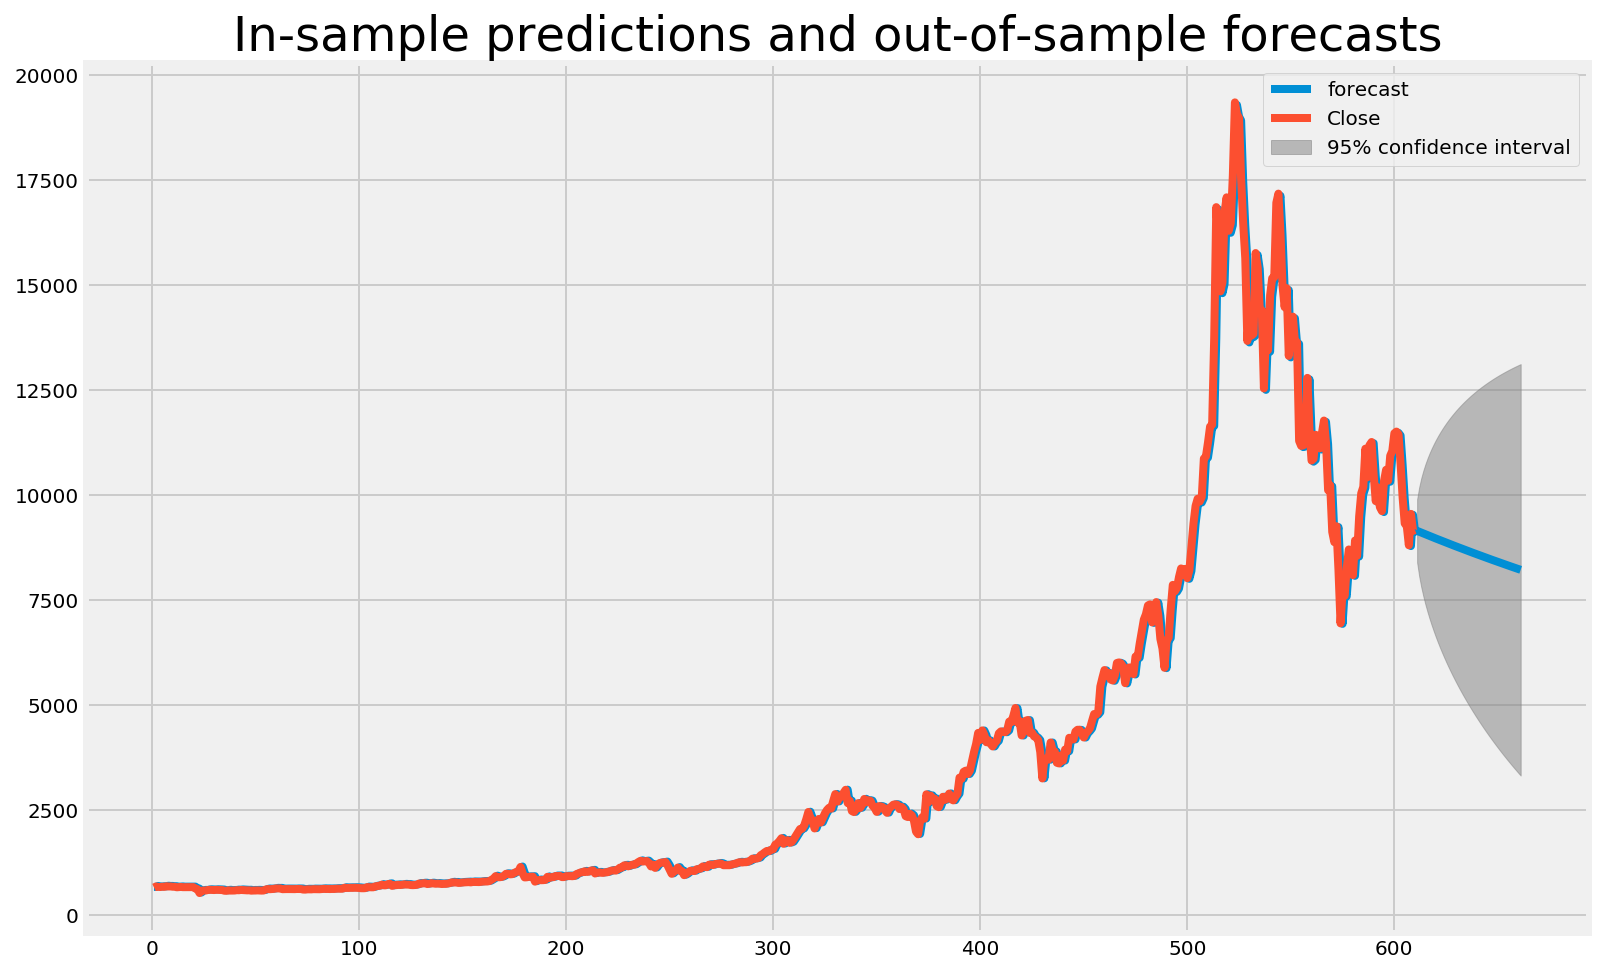

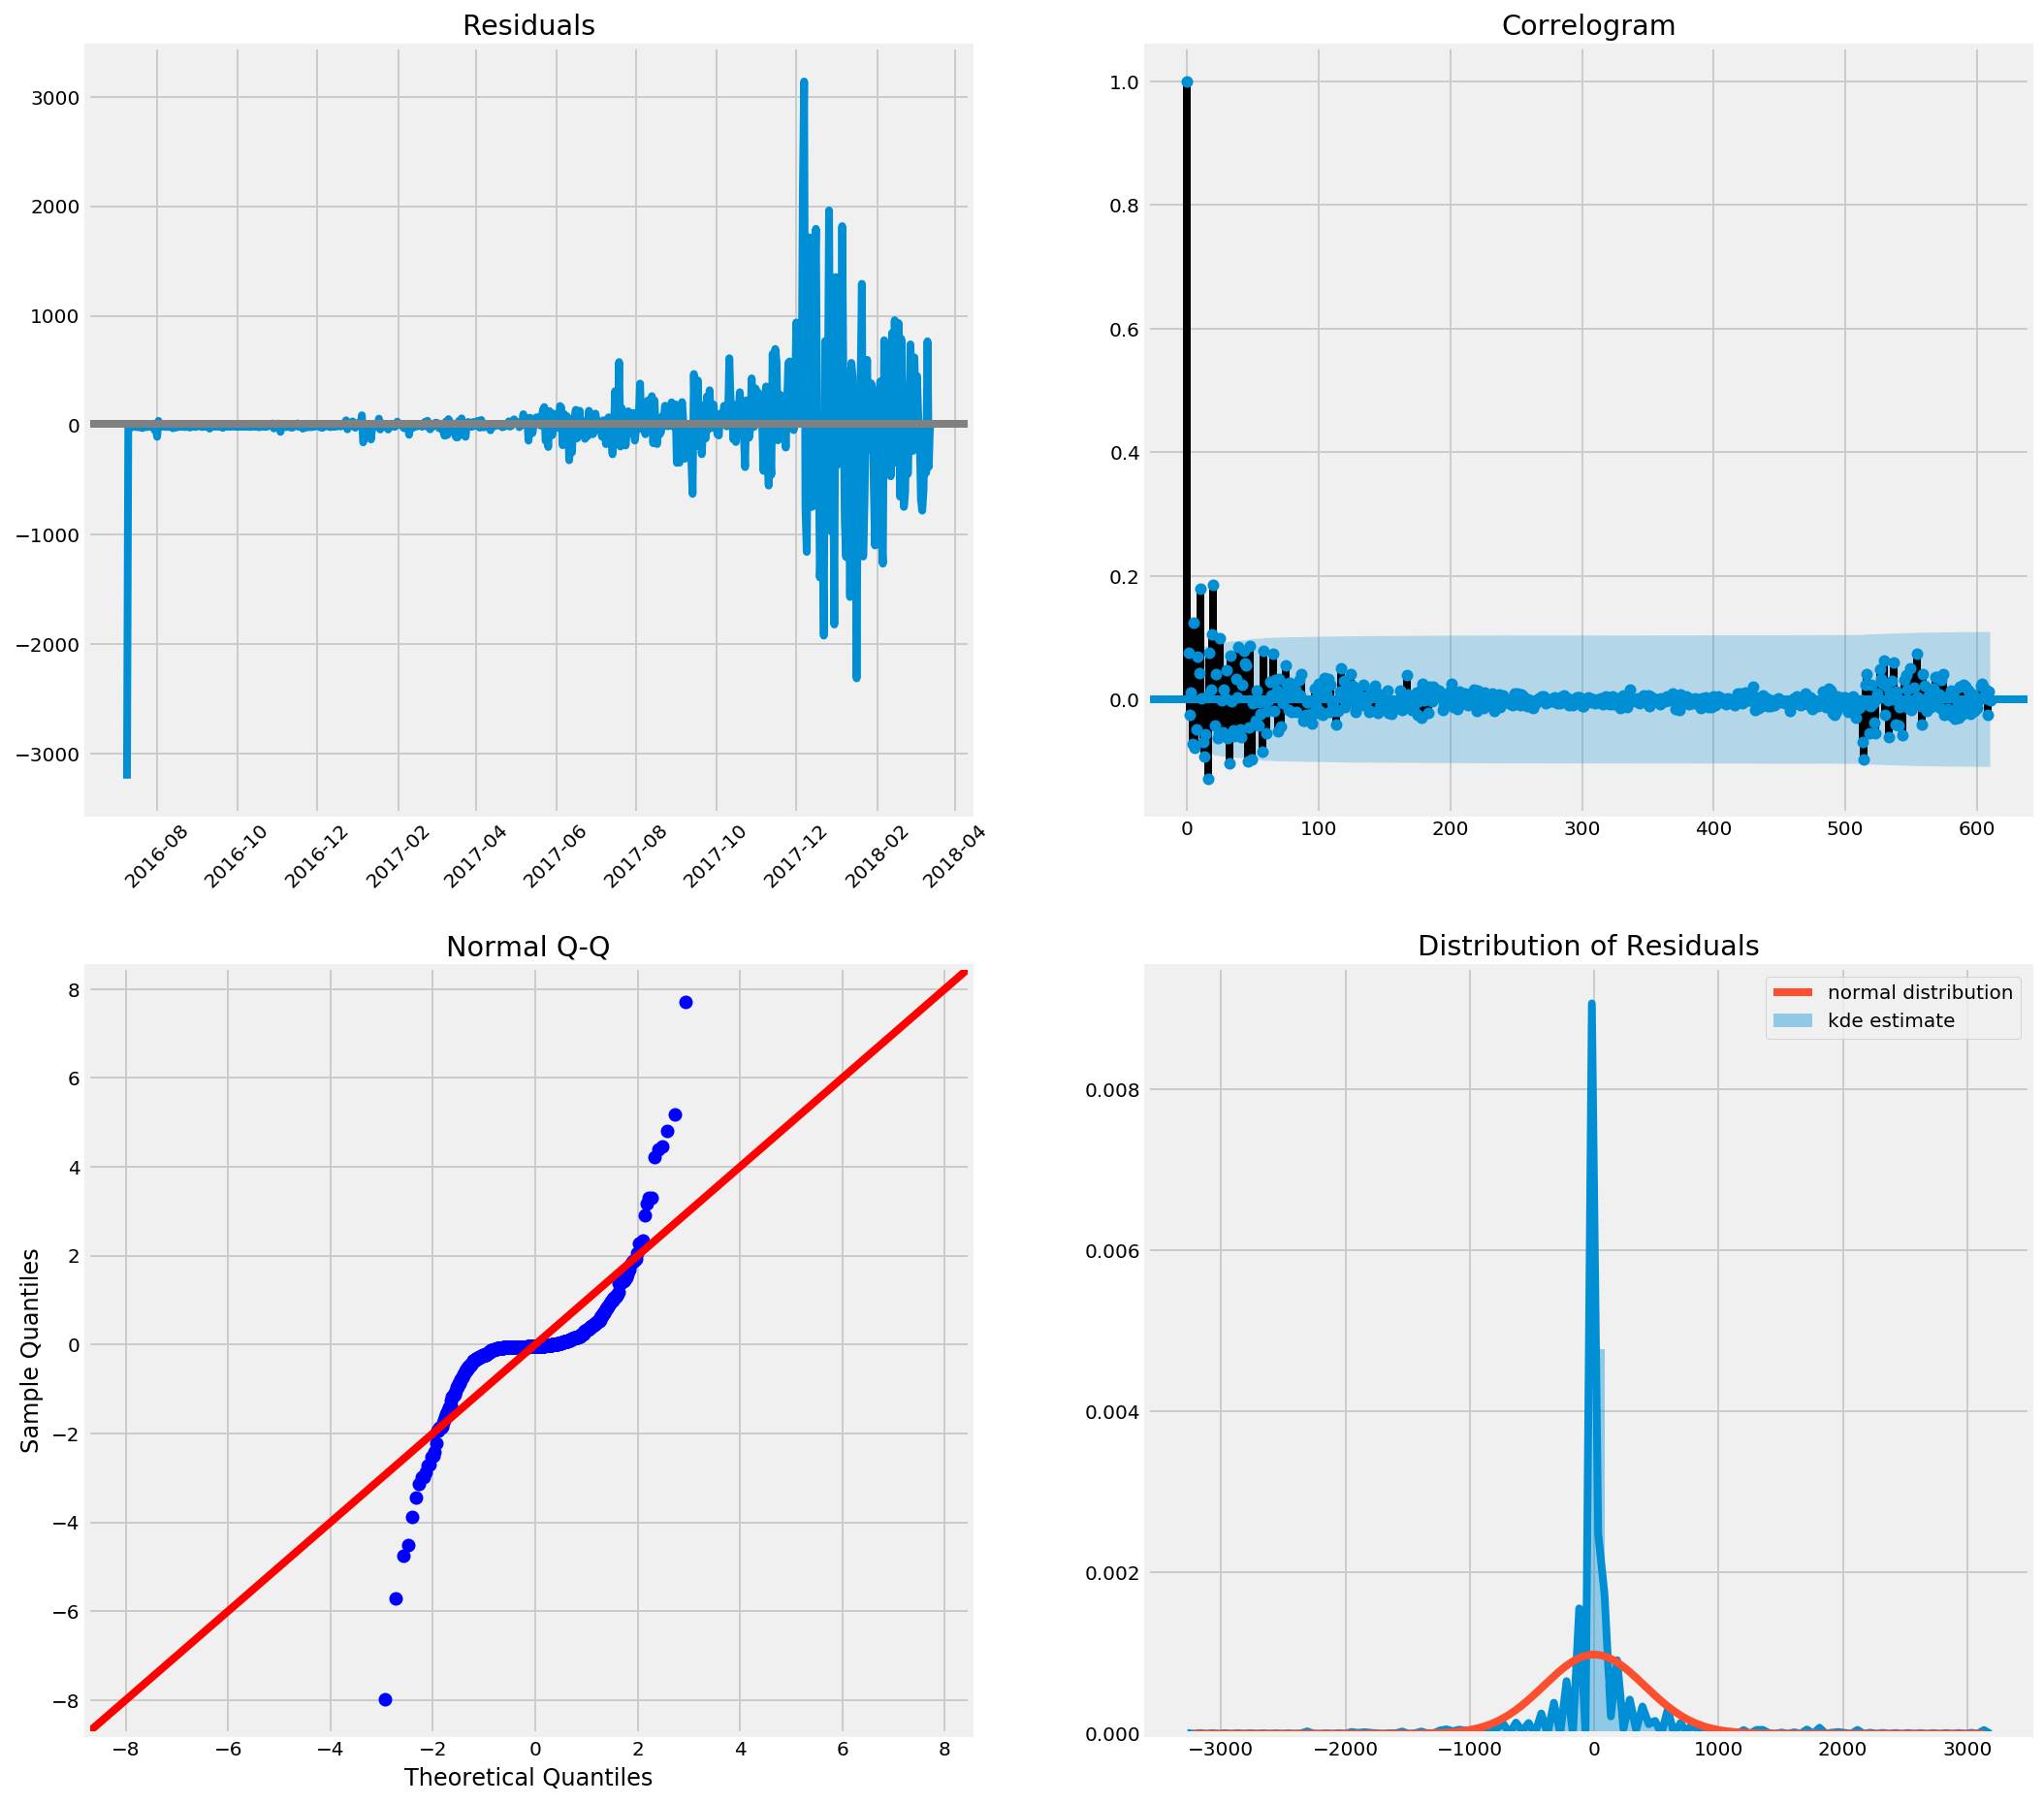

In [66]:
# Plotting time series and residuals for AR1 model for Bitcoin:

ts_plot(b_AR1,1,len(b_training_values)+50)
residual_plot(b_AR1.resid)

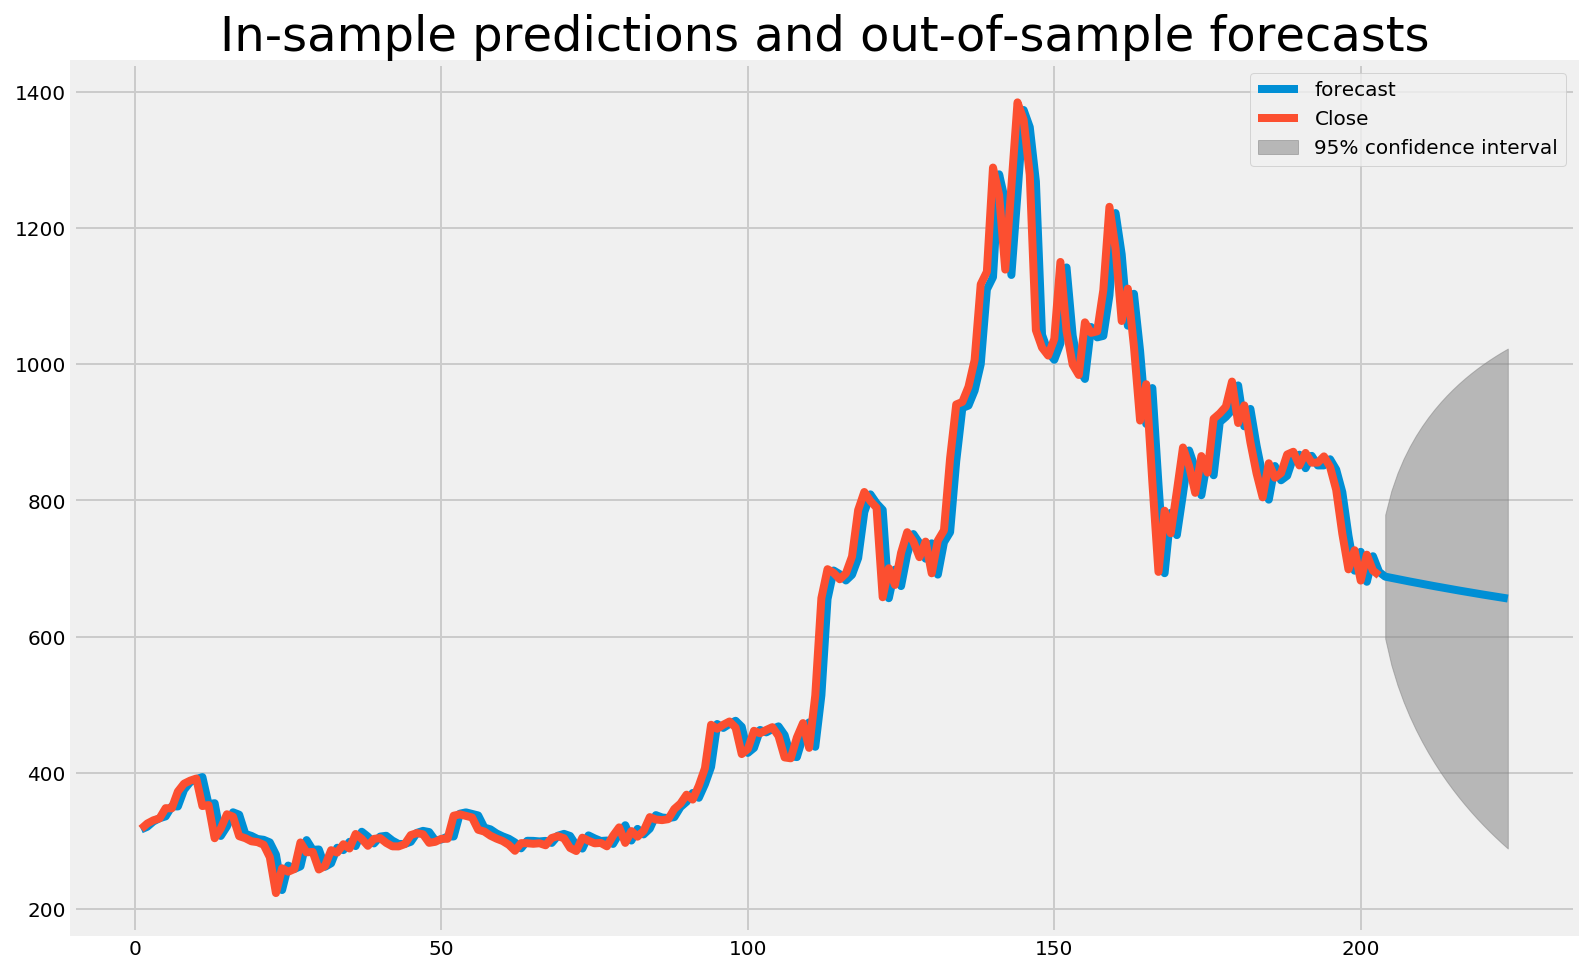

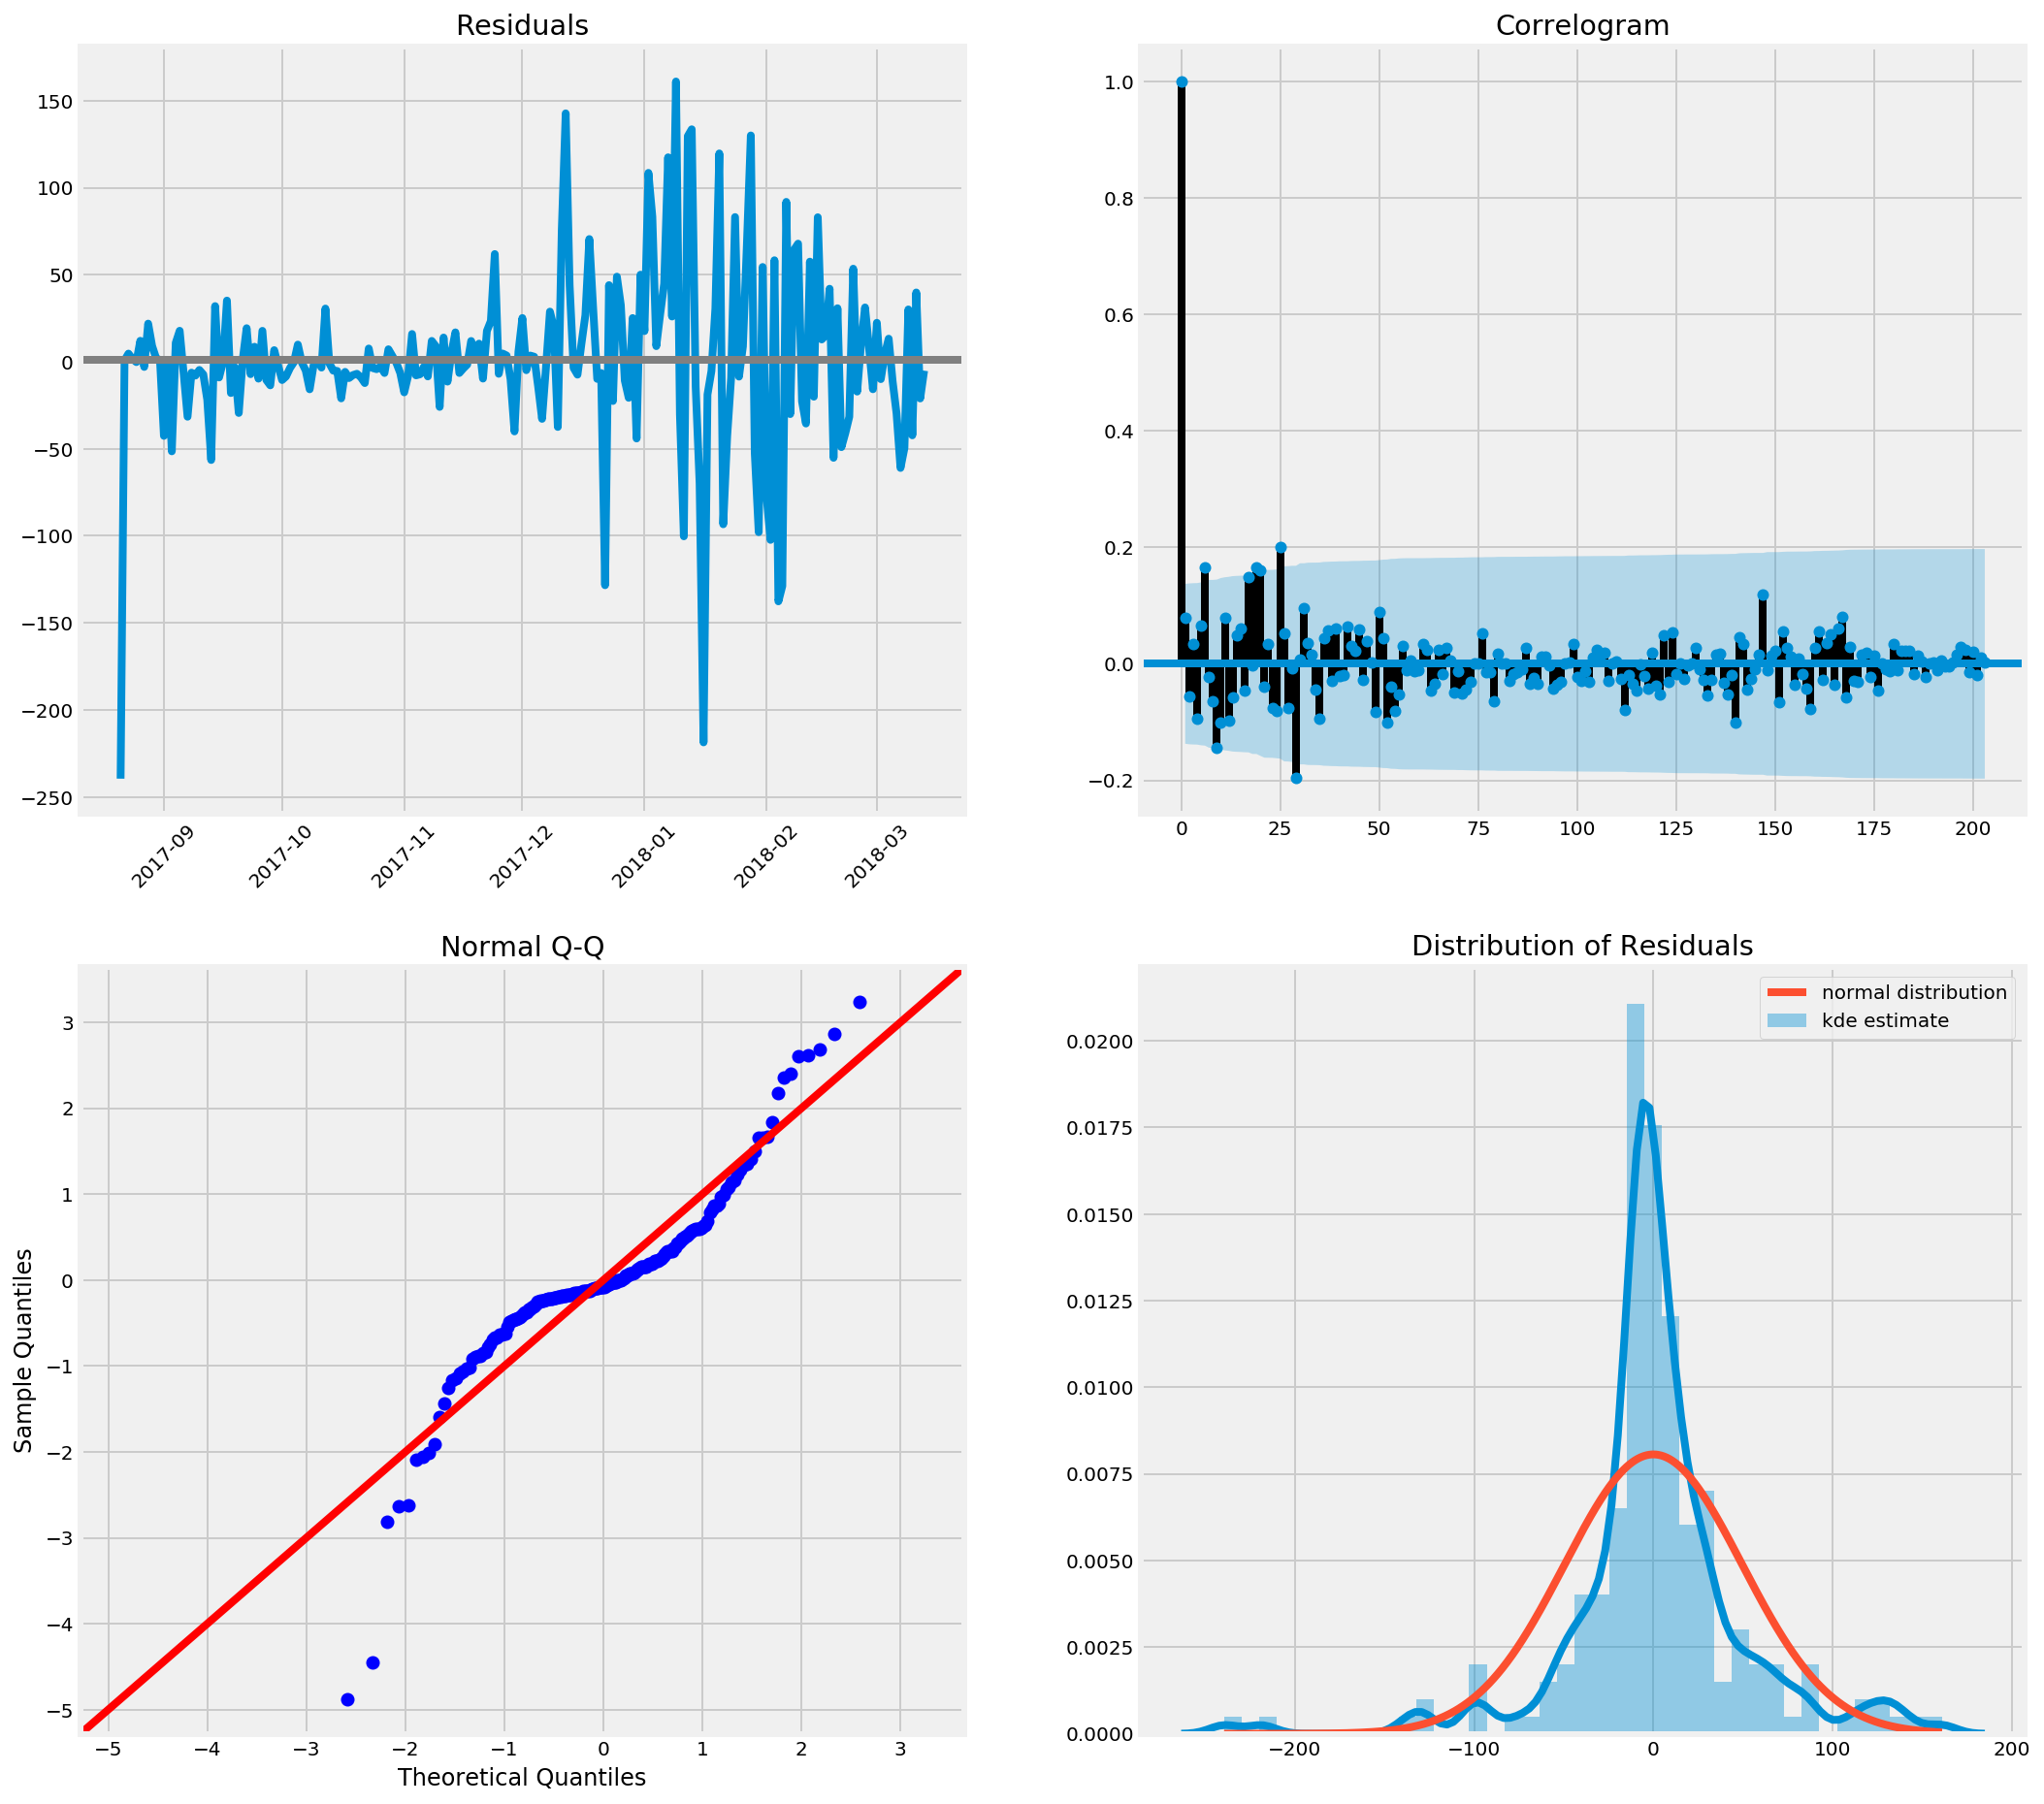

In [67]:
# Same for Ethereum:

ts_plot(e_AR1,1,len(e_training_values)+20)
residual_plot(e_AR1.resid)

### 1.3.3. AR(2)

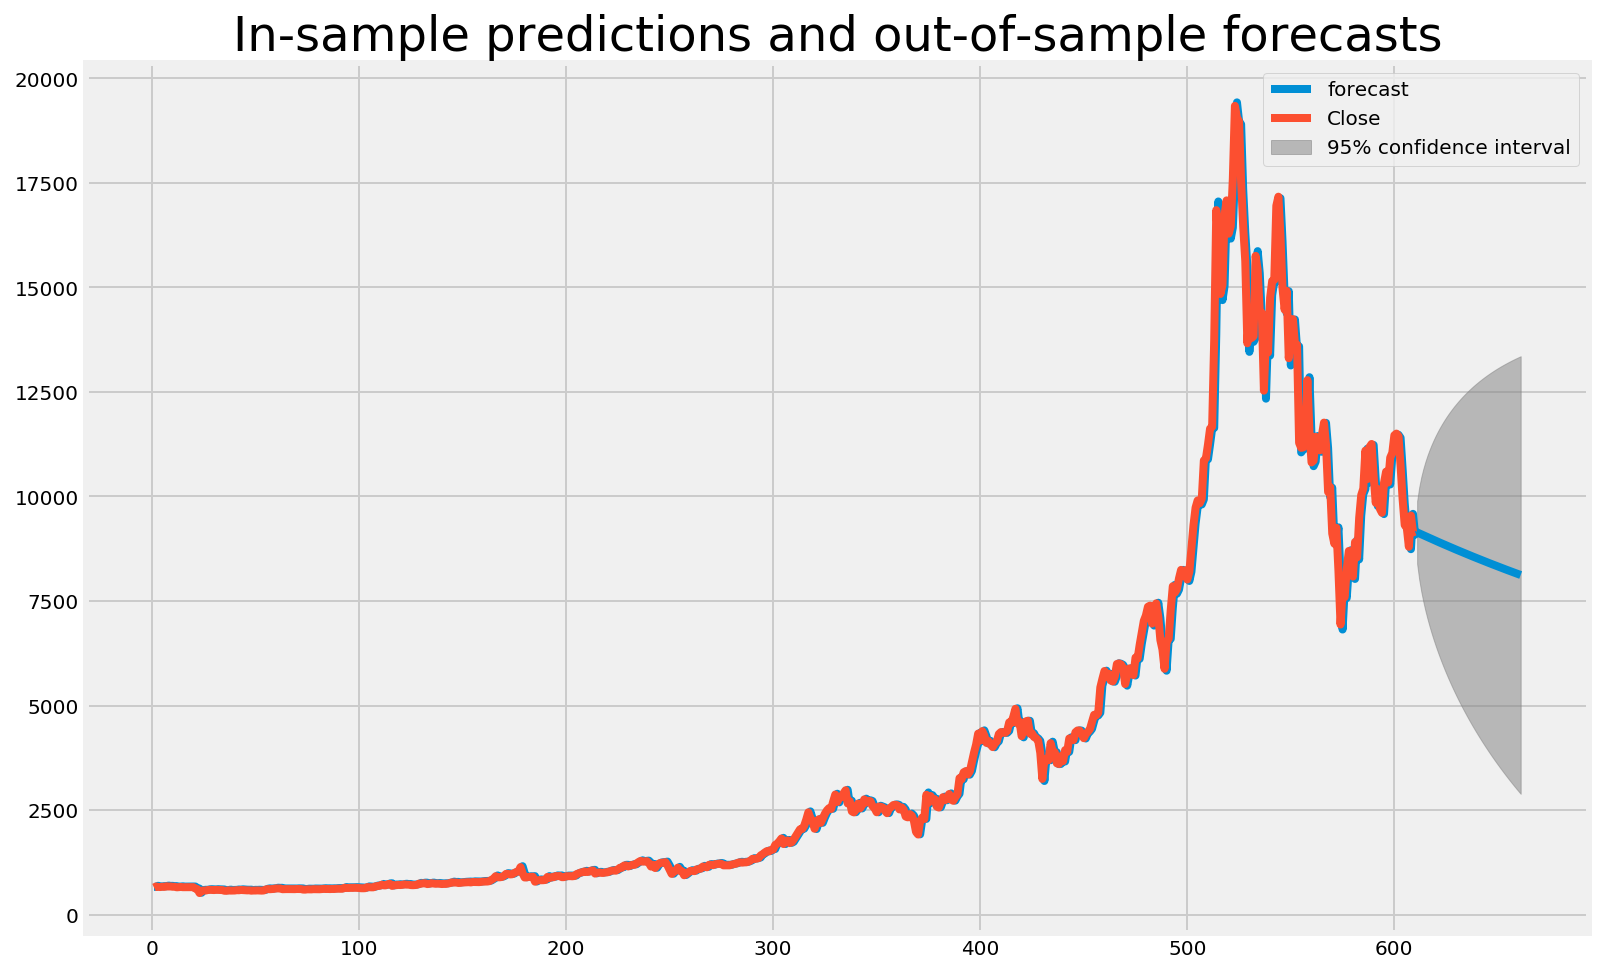

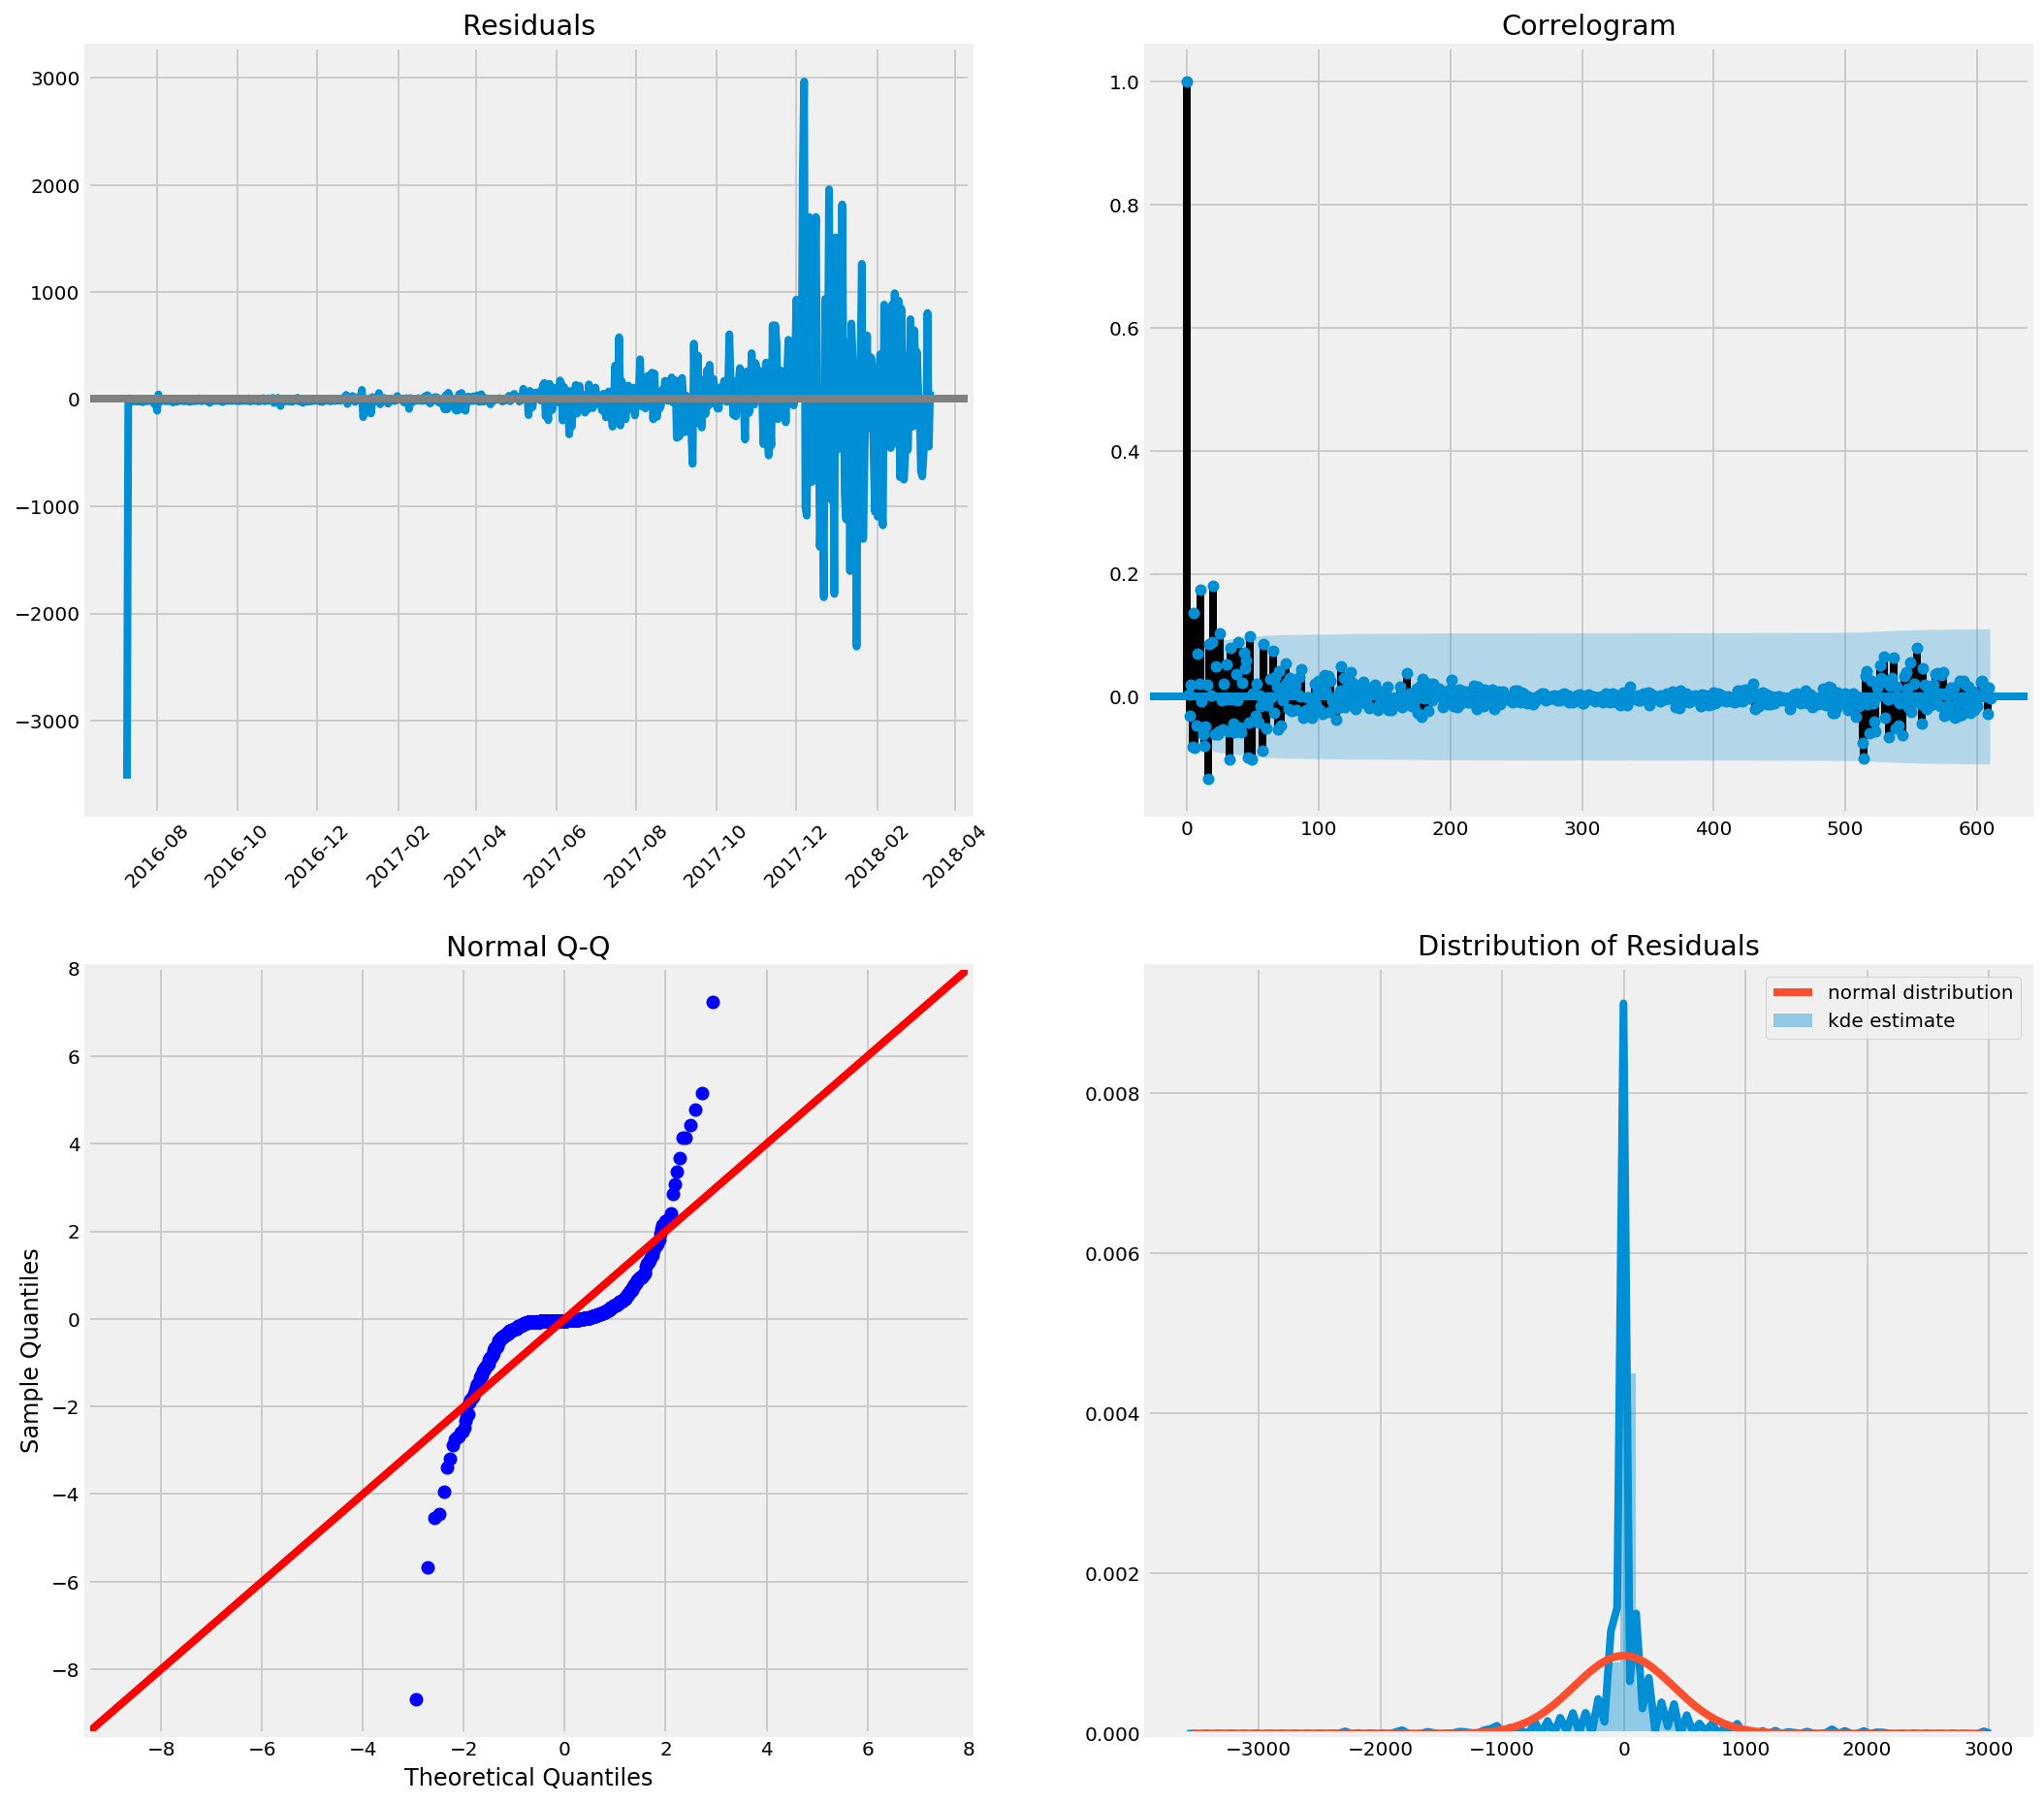

In [68]:
# Plotting time series and residuals for AR2 model for Bitcoin:

ts_plot(b_AR2,1,len(b_training_values)+50)
residual_plot(b_AR2.resid)

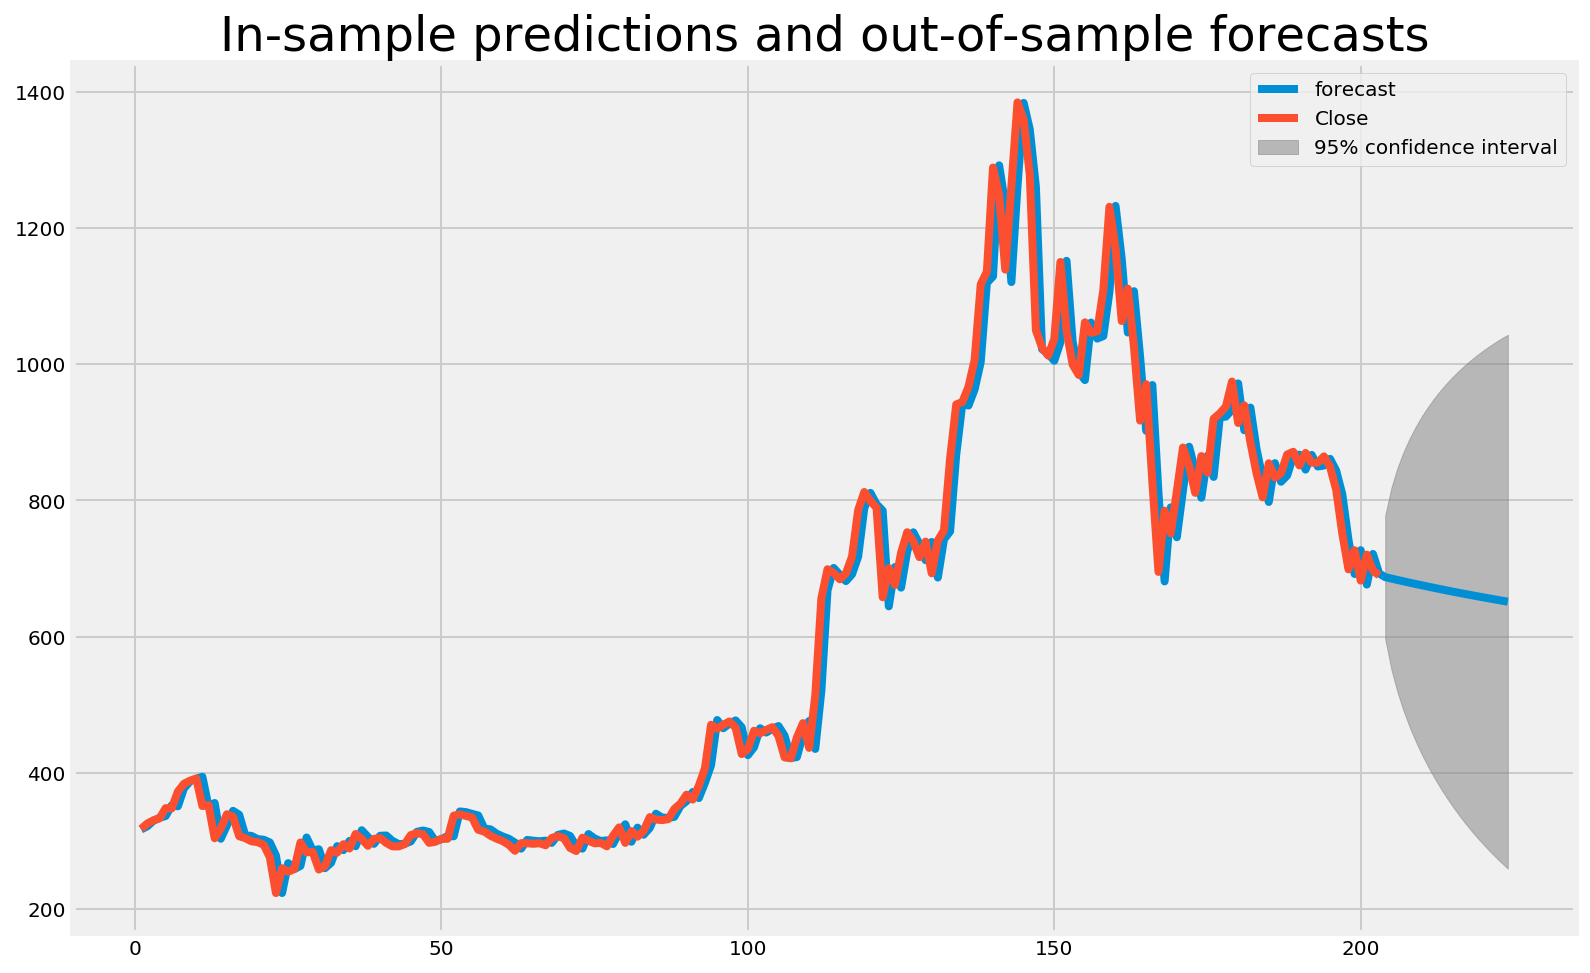

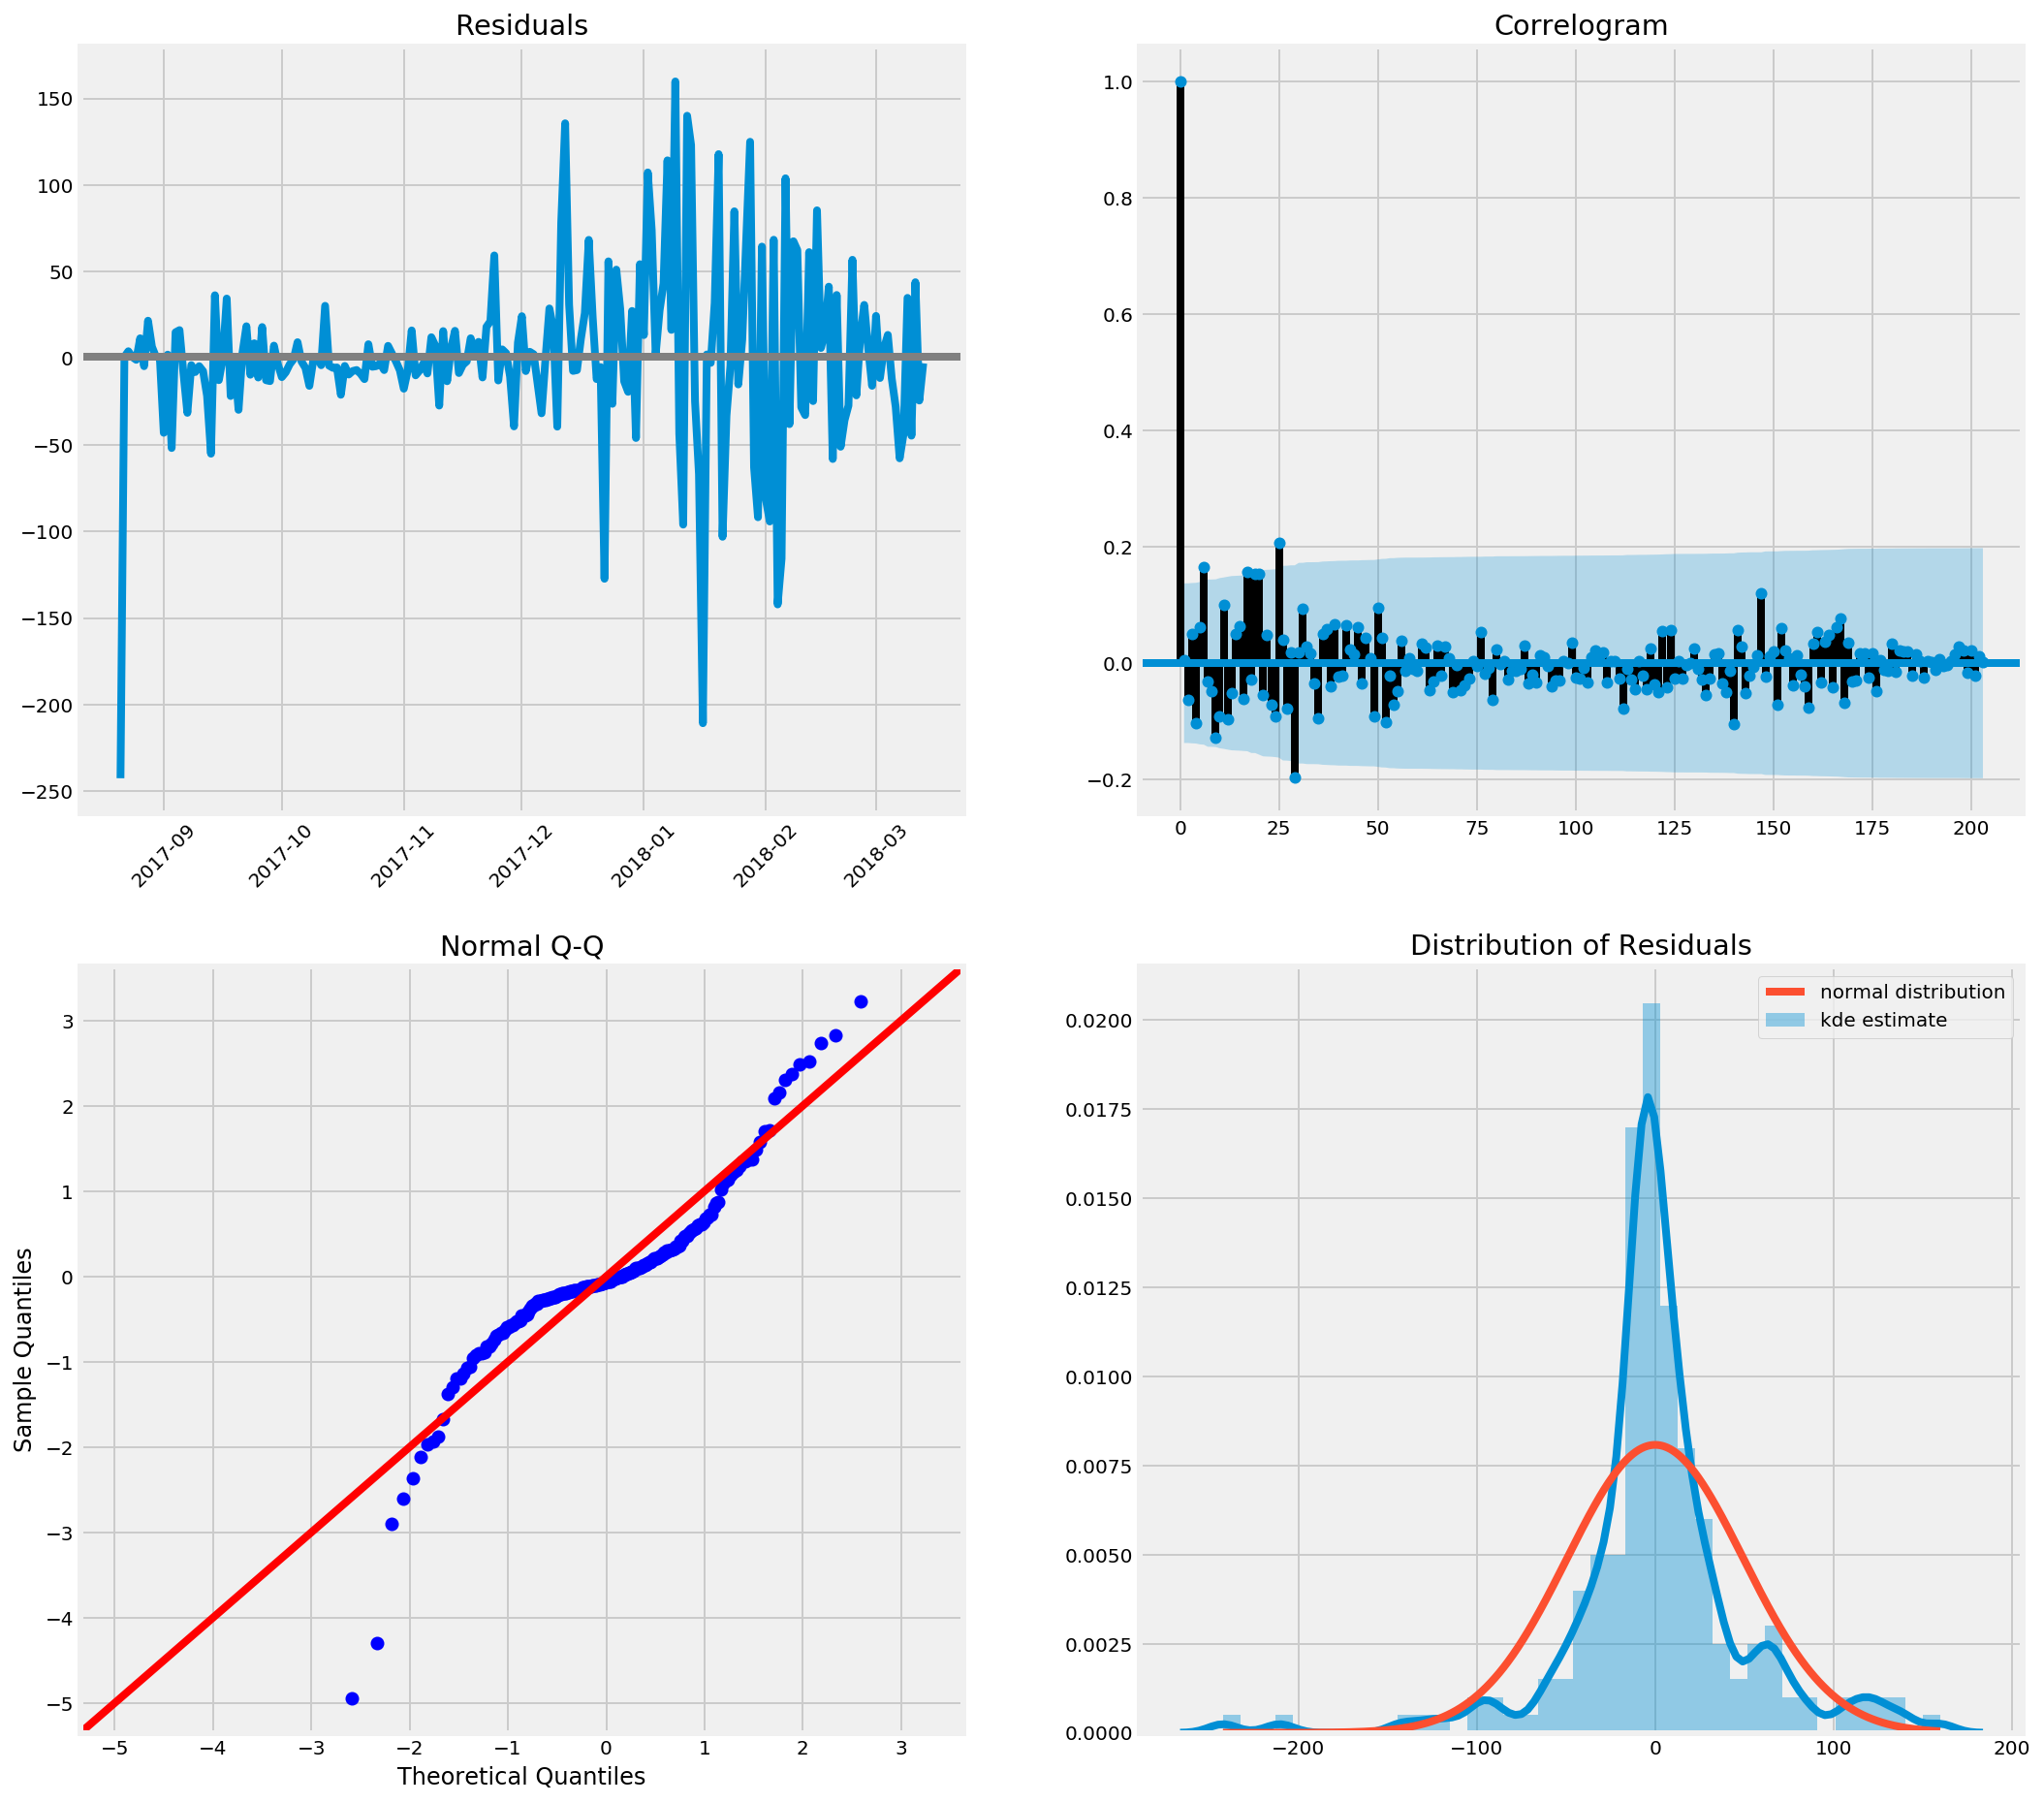

In [69]:
# Same for Ethereum:

ts_plot(e_AR2,1,len(e_training_values)+20)
residual_plot(e_AR2.resid)

We could also plot the time series and residuals for the last model but it's the one that performed the worse
out of the three so we leave it out.

### 1.3.4. Heatmaps

{'aic':              0             1             2             3             4
0          NaN  11523.626095  10880.563835  10439.256039  10142.409241
1  8997.441044   8994.979051   8996.102124   8996.584984   8991.373660
2  8981.542052   8974.478680   8976.463592   8977.309634   8973.081859
3  8969.043982   8962.742687   8964.750109   8939.052700   8947.834771
4  8957.149264   8949.291517   8925.339947   8944.979349   8929.096521, 'bic':              0             1             2             3             4
0          NaN  11532.456289  10893.809126  10456.916426  10164.484726
1  9006.267962   9008.219428   9013.755960   9018.652279   9017.854414
2  8994.777507   8992.125953   8998.522683   9003.780543   9003.964587
3  8986.684682   8984.793562   8991.211159   8969.923924   8983.116170
4  8979.191908   8975.742689   8956.199648   8980.247579   8968.773280, 'aic_min_order': (4, 2), 'bic_min_order': (4, 2)}


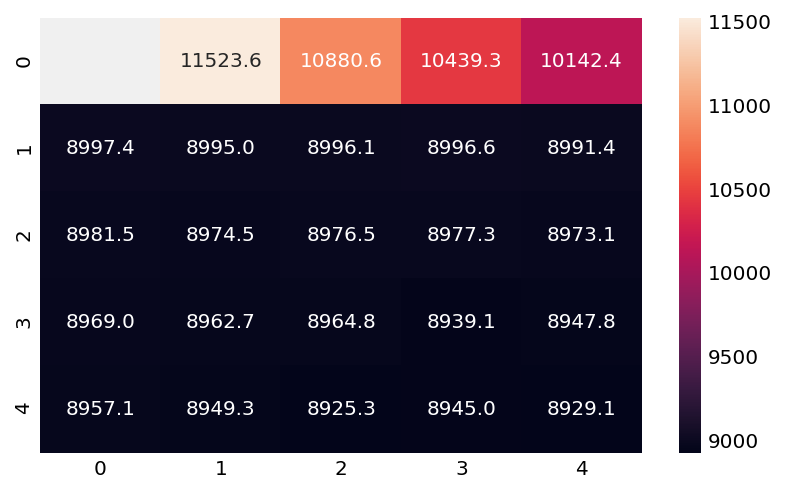

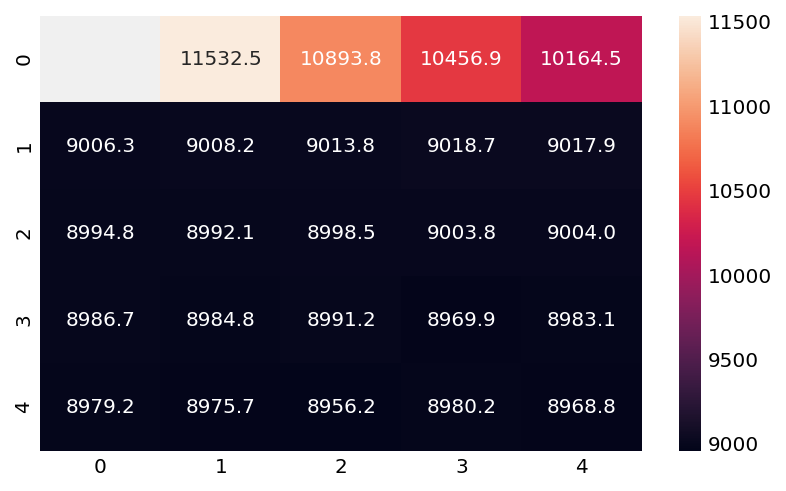

In [70]:
# Plotting a heatmap for BTC:

from statsmodels.tsa import stattools

auto_select = stattools.arma_order_select_ic(b_training_values,
                max_ar=4, max_ma=4,ic=['aic', 'bic'],trend='nc',
                fit_kw={'method':'css','solver':'lbfgs','maxiter':500})

print(auto_select)

sns.heatmap(auto_select['aic'],annot=True,fmt='.1f')
plt.show()

sns.heatmap(auto_select['bic'],annot=True,fmt='.1f')
plt.show()

{'aic':              0            1            2            3            4
0          NaN  2968.117876  2766.405323  2637.911318  2539.938860
1  2140.728418  2140.975766  2141.422352  2142.786206  2142.205504
2  2131.707667  2129.730266  2131.657827  2134.588371  2134.685994
3  2123.081848  2121.105527  2122.898319  2114.904067  2111.951186
4  2115.093136  2115.335601  2106.067357  2108.025929  2103.665897, 'bic':              0            1            2            3            4
0          NaN  2974.754116  2776.359683  2651.183798  2556.529460
1  2147.354829  2150.915384  2154.675176  2159.352236  2162.084740
2  2141.632470  2142.963337  2148.199165  2154.437978  2157.843868
3  2136.295068  2137.622051  2142.718148  2138.027202  2138.377625
4  2131.584723  2135.125505  2129.155579  2134.412468  2133.350753, 'aic_min_order': (4, 4), 'bic_min_order': (4, 2)}


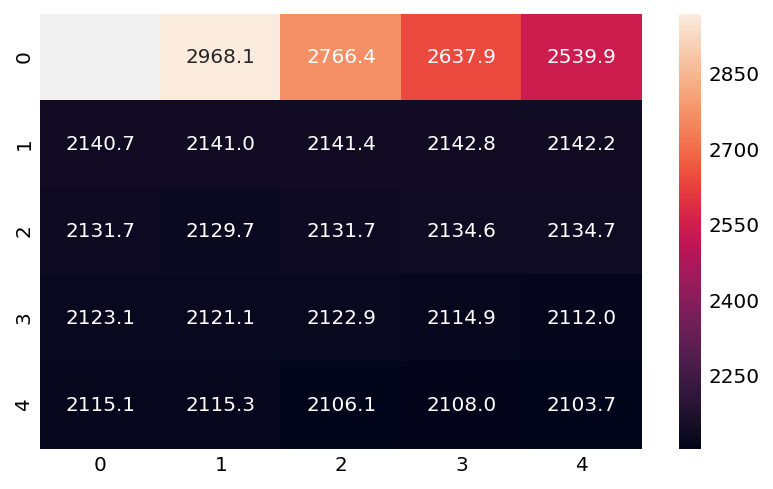

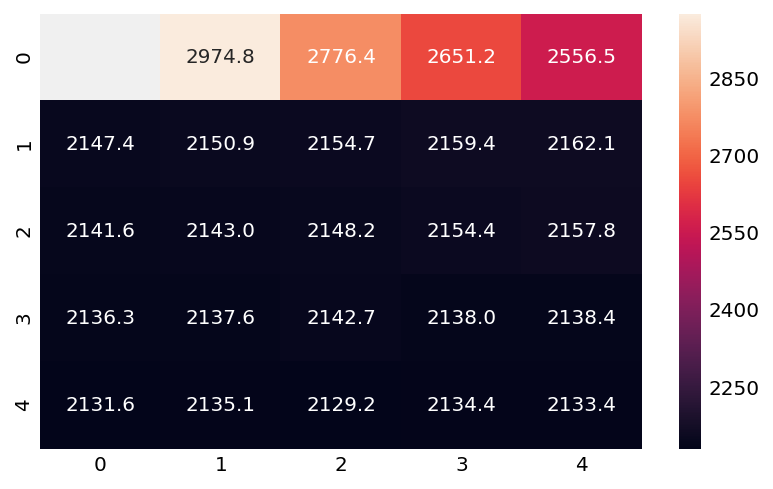

In [71]:
# Plotting a heatmap for ETH:

auto_select = stattools.arma_order_select_ic(e_training_values,
                max_ar=4, max_ma=4,ic=['aic', 'bic'],trend='nc',
                fit_kw={'method':'css','solver':'lbfgs','maxiter':500})

print(auto_select)

sns.heatmap(auto_select['aic'],annot=True,fmt='.1f')
plt.show()

sns.heatmap(auto_select['bic'],annot=True,fmt='.1f')
plt.show()

These heatmaps are indicators of the best aic_min_order and bic_min_orders which will affect our overall model performance (regarding the MSE). However, the fact that the lower squares are all the same color tells us that model performance won't vary too much from one model to another. 
For BTC they're both (4,2). 
For ETH aic is (4,4) and bic is (4,2). 

### 1.3.5. ARbest

In [72]:
# Trying to find the best AR model for our Bitcoin data, using the information obtained in the heatmaps. 

b_ARbest = ARMA(endog = b_training_values, dates = b_training_dates, order = (4,2)).fit()

# Same start and end we outlined earlier.
b_ARbest_pred = b_ARbest.predict(start=len(b_training_values)-1, end=len(b_training_values)+20)


print('Best MSE for Bitcoin:', mean_squared_error(b_test_values[:22], b_ARbest_pred[:])**0.5)

Best MSE for Bitcoin: 1219.5504956208258


The MSE we obtained above is indeed the best MSE that we obtained in all of our models. 

In [73]:
# Same for Ethereum:

e_ARbest = ARMA(endog = e_training_values, dates = e_training_dates, order = (4,3)).fit()

# Same start and end we outlined earlier.
e_ARbest_pred = e_ARbest.predict(start=len(e_training_values)-1, end=len(e_training_values)+20)


print('Best MSE for Ethereum:', mean_squared_error(e_test_values[:22], e_ARbest_pred[:])**0.5)

Best MSE for Ethereum: 205.14625049622254


/Users/jamesliounis/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The ARbest MSE we obtain for Ethereum is not the best out of all the models we have fitted. We therefore keep our AR(2) model for this data and plot the time series and residuals for the ARbest fitted on Bitcoin. 

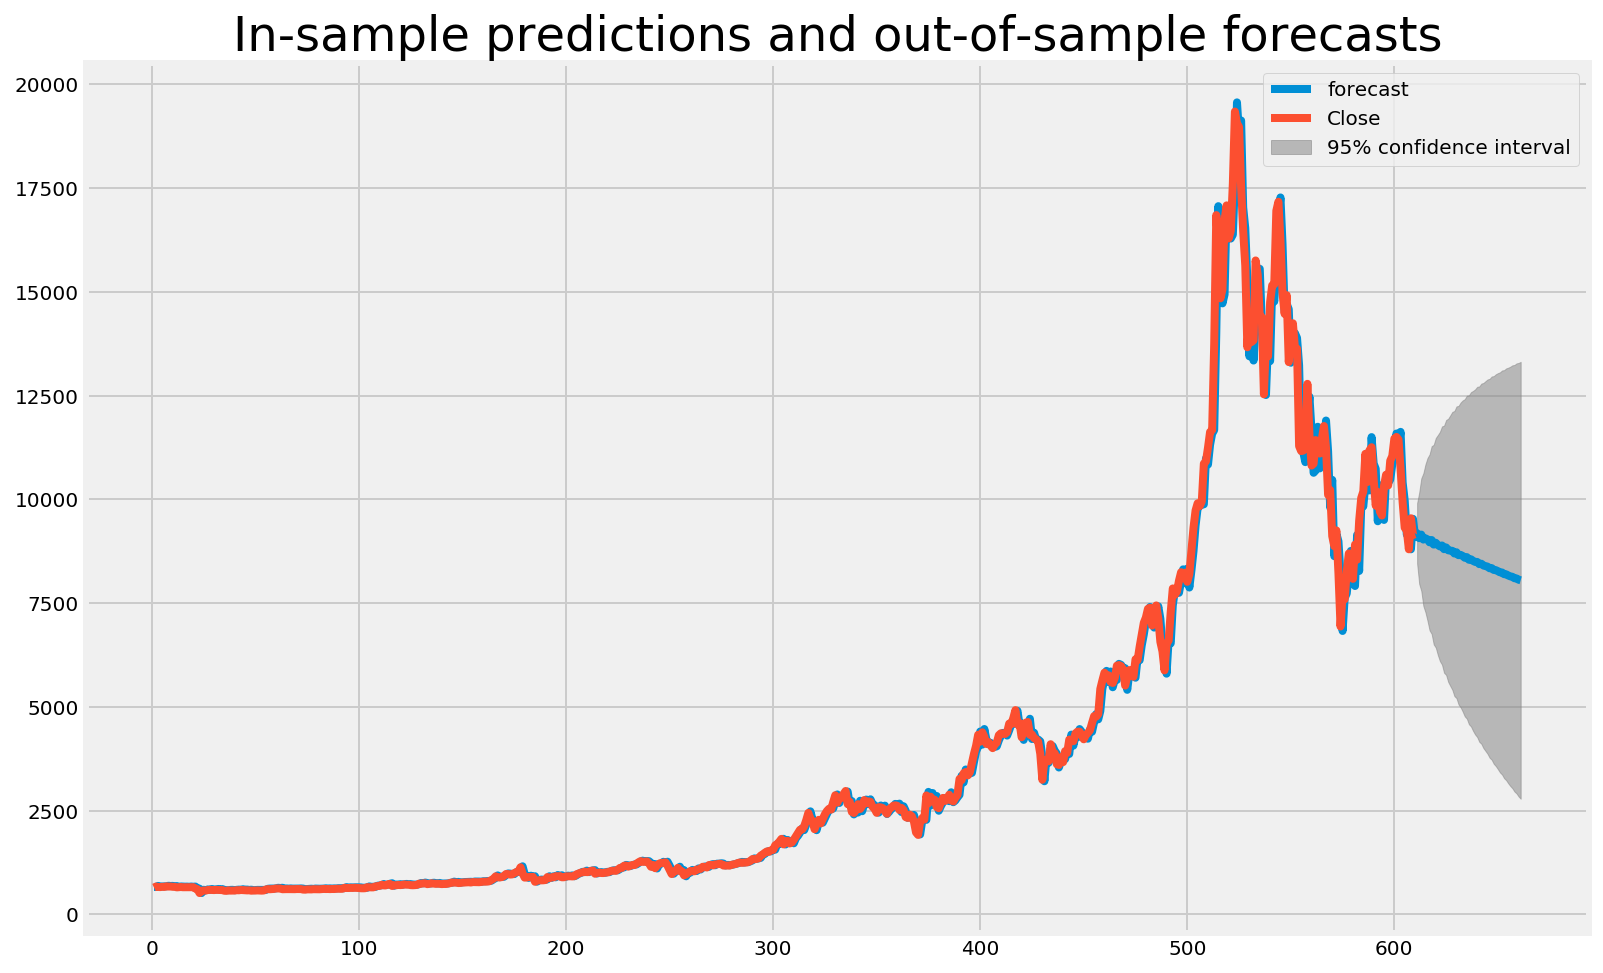

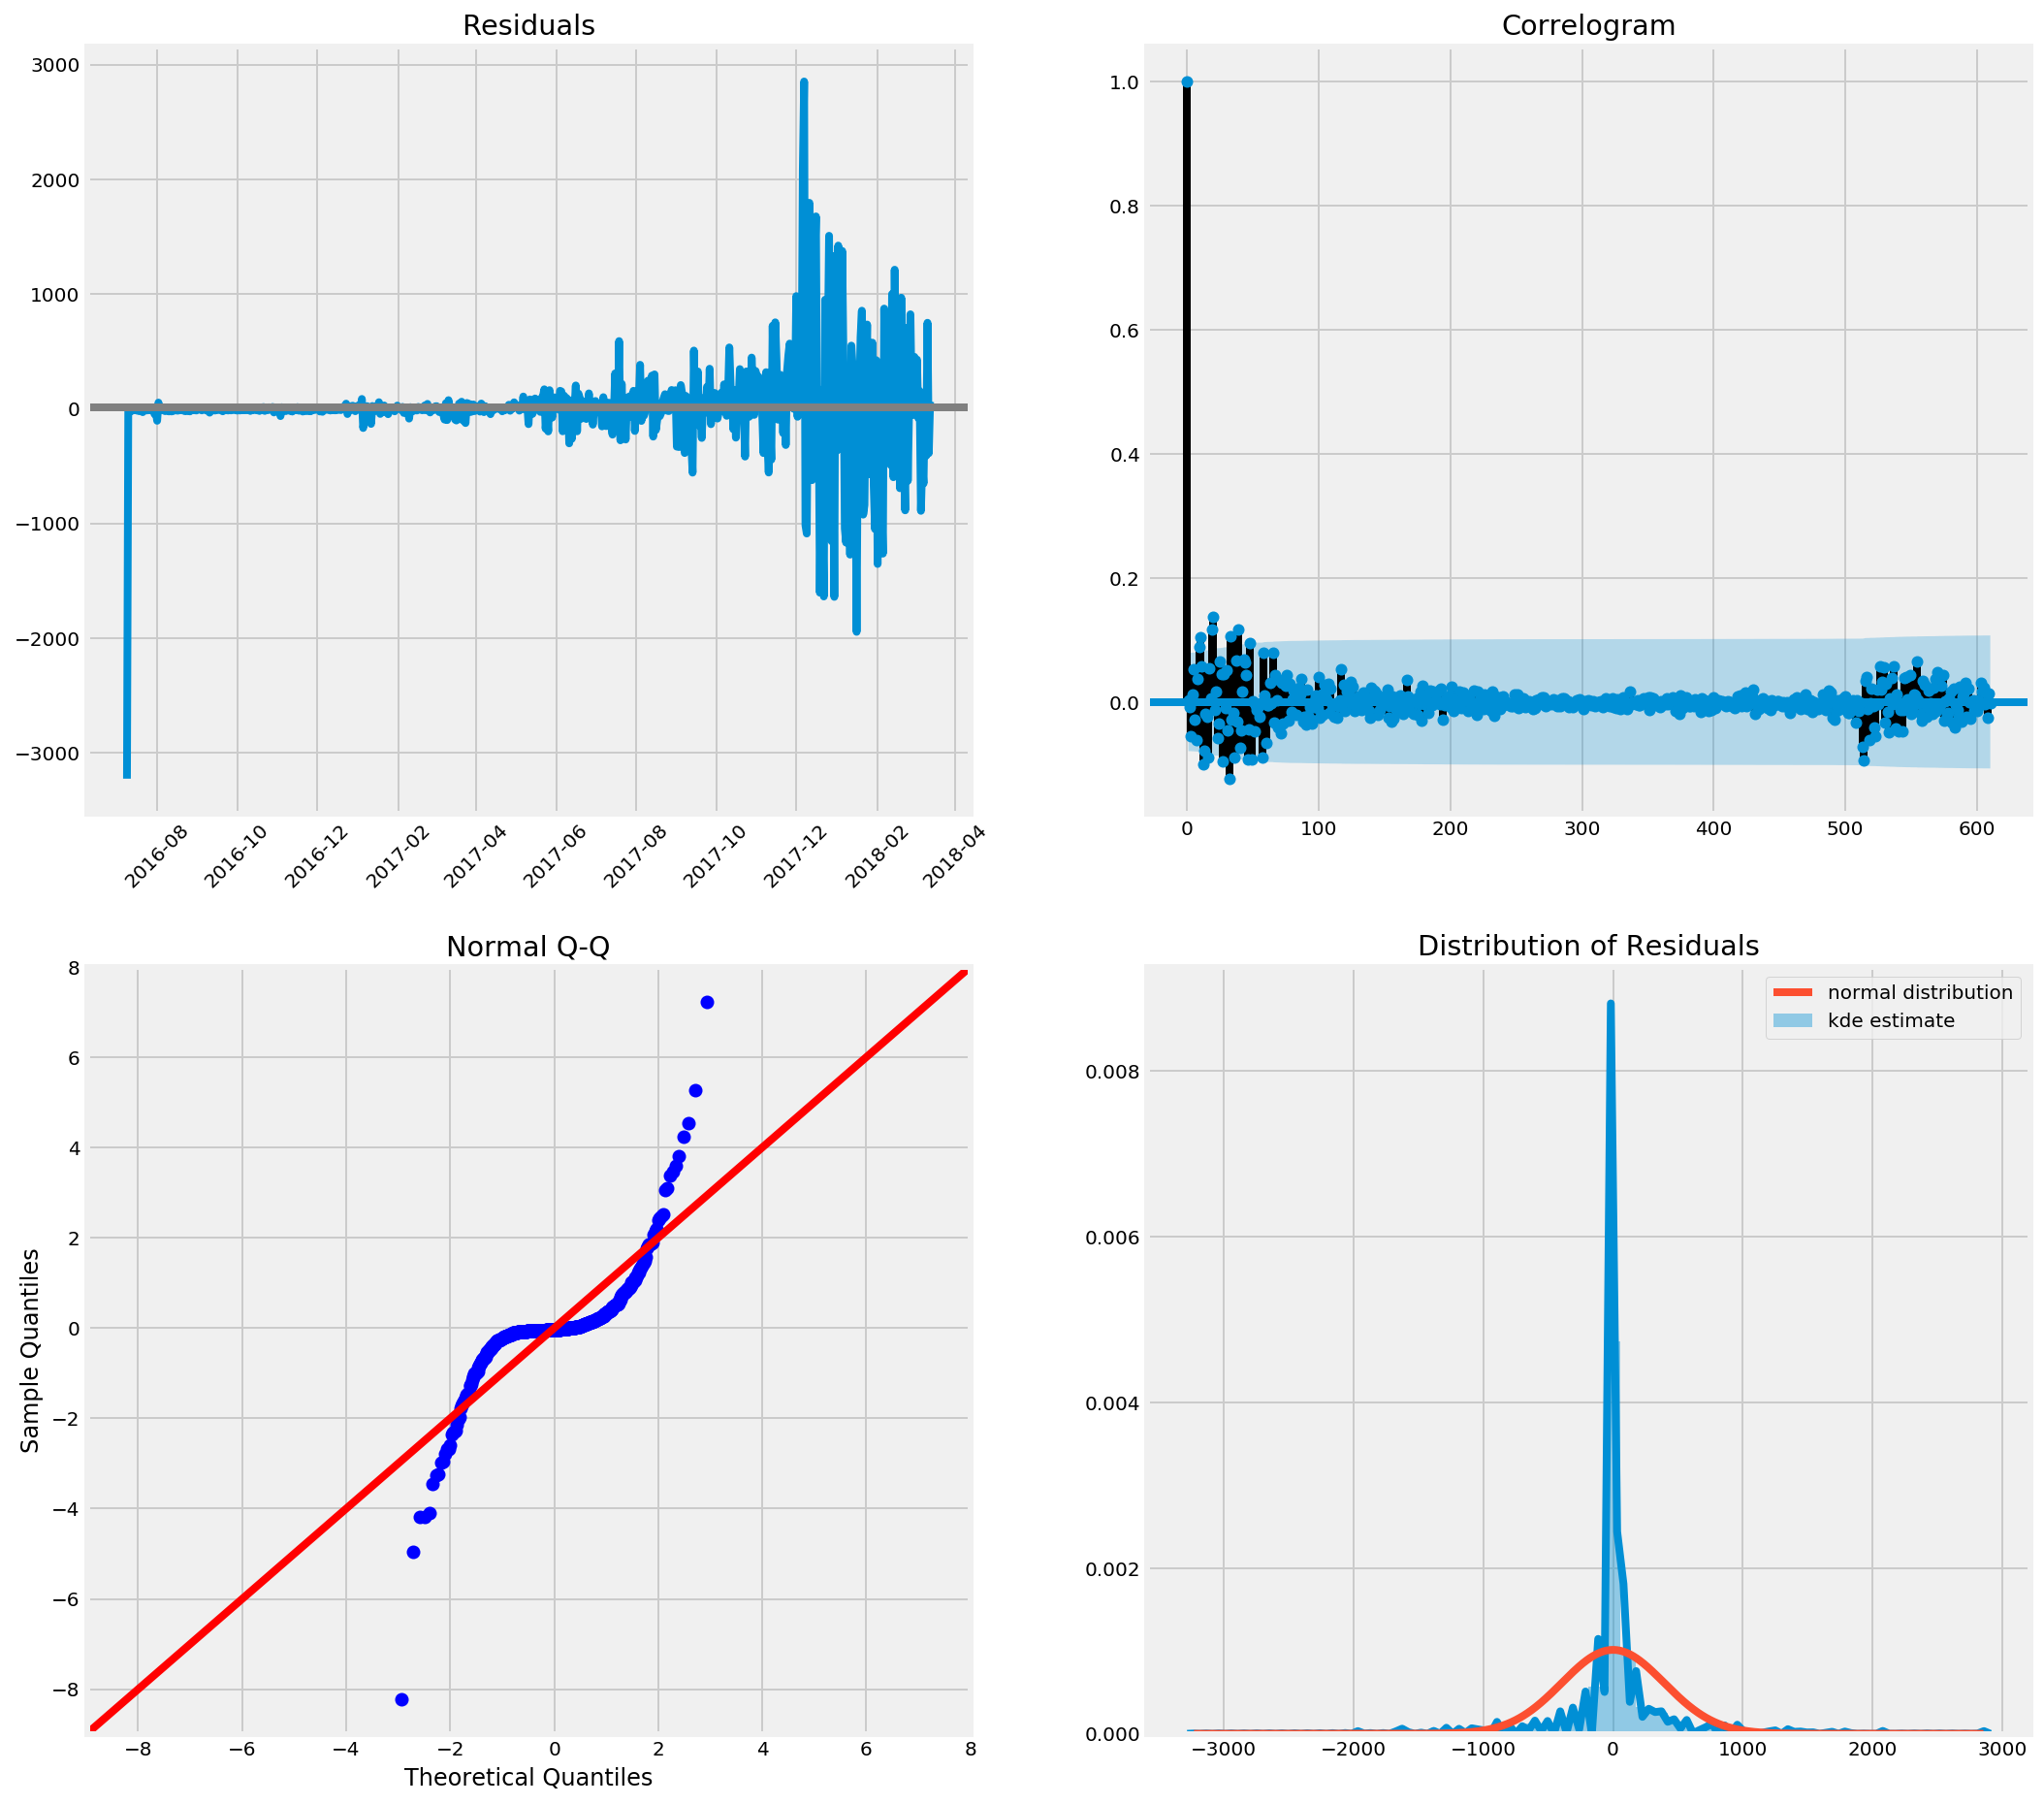

In [74]:
ts_plot(b_ARbest,1,len(b_training_values)+50)
residual_plot(b_ARbest.resid)

### 1.3.6. Plotting predictions vs. actual values

#### Bitcoin

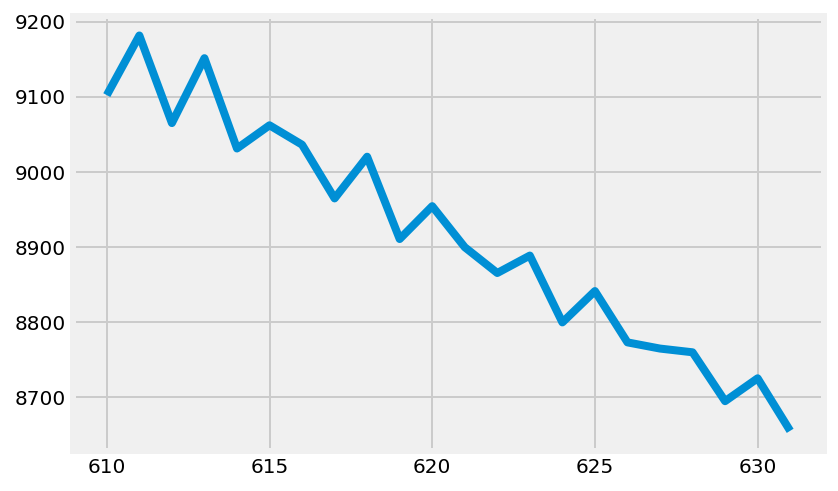

In [75]:
# We are going to plot the real vs. the predicted prices of both the cryptocurrencies

# For BTC, ARBest predictions vs. actual values:
# ARBest gives us predictions 20 days after March 13th 2018, until April 2nd 

b_ARbest_pred.plot();

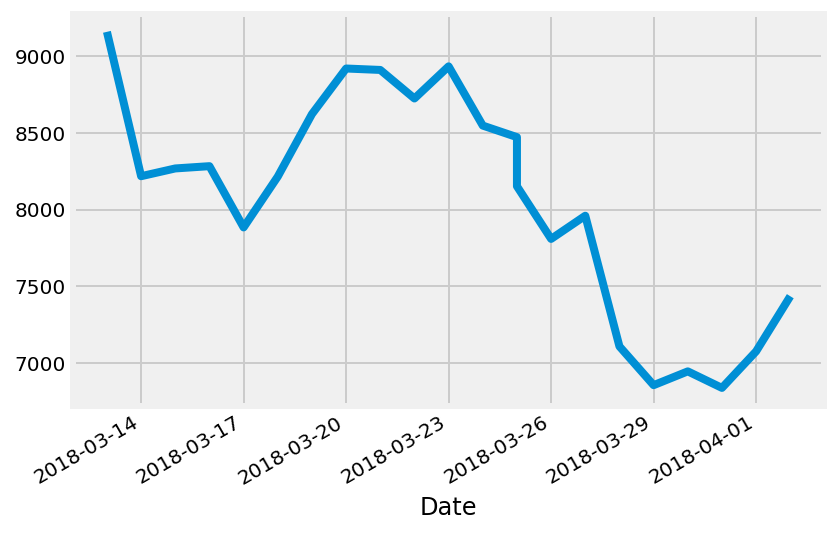

In [76]:
b_plot_mask = btc.loc['2018-3-13':'2018-4-2']

b_plot_mask['Close'].plot();

In [77]:
btc_pred_df = btc.loc['2018-3-13':'2018-4-2']
btc_pred_df['Predictions'] = b_ARbest_pred.values # --> Adding the predictions as a new column to have the same index

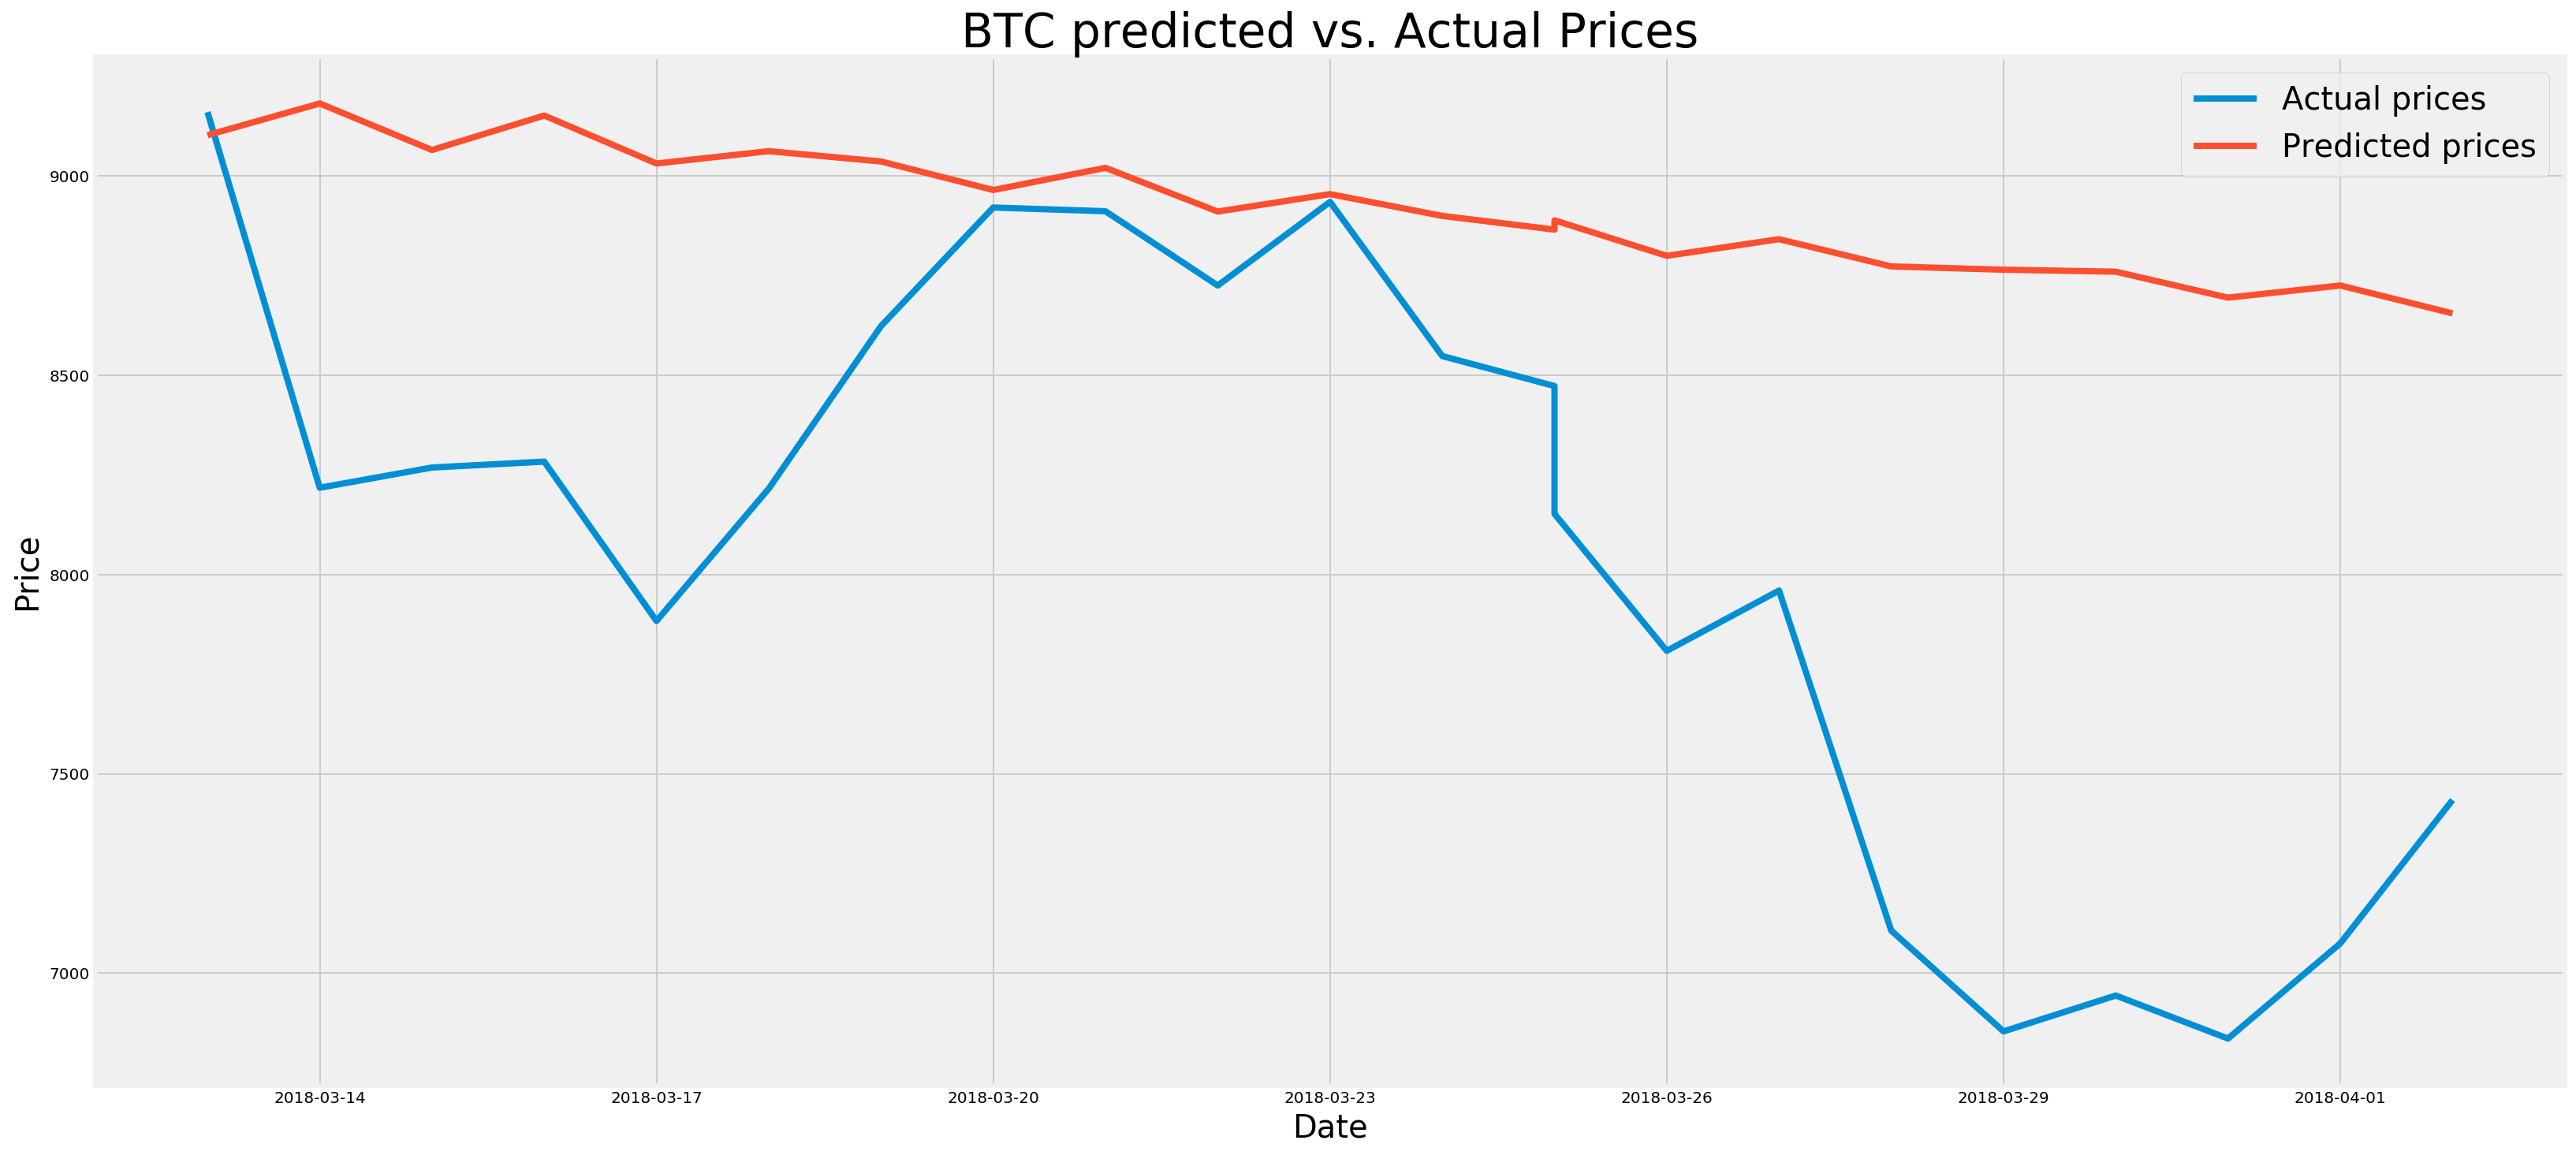

In [78]:
Fig, ax = plt.subplots(figsize=(25, 12))

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Price', fontsize=20)
ax.set_title('BTC predicted vs. Actual Prices', fontsize=30)

ax.plot(btc_pred_df.Close, label='Actual prices')
ax.legend(loc='upper right')

ax.plot(btc_pred_df.Predictions, label='Predicted prices')
ax.legend(loc='upper right', fontsize=20);

Here, we can clearly see that the model is not performing very well. The global trend can be reproduced (downwards), but the predictions are nowhere near reflecting the actual price variations. BTC prices seem very volatile and can be almost impossible to predict using TSA. 

#### Ethereum

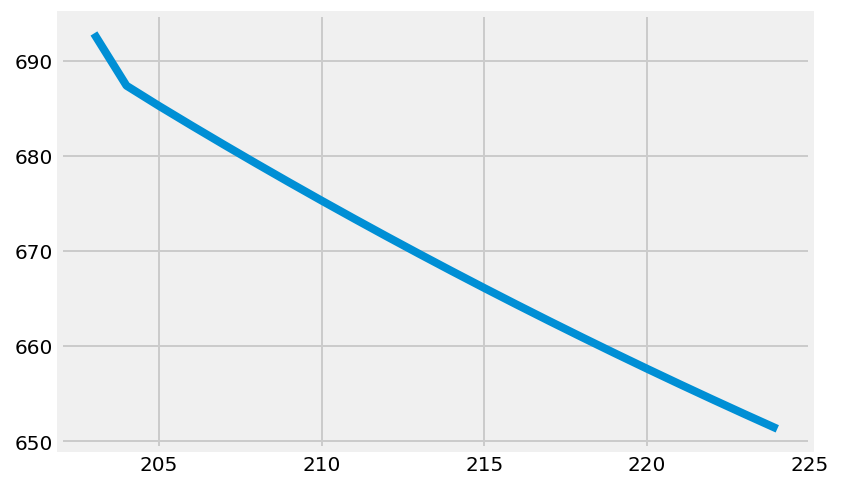

In [79]:
# Repeating the same for ETH. Here, we are going to plot the AR2 predictions because it's the model that performs best
# for Ethereum (with a MSE of ~197)

e_AR2_pred.plot();

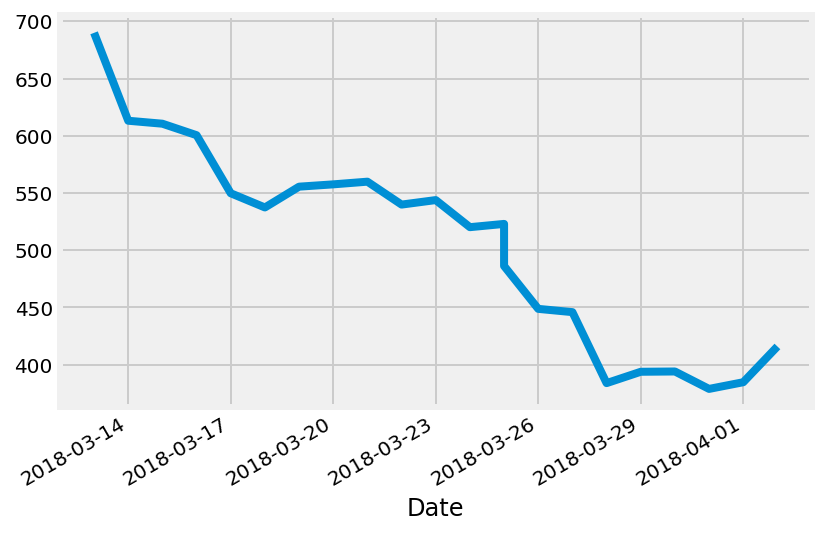

In [80]:
e_plot_mask = eth.loc['2018-3-13':'2018-4-2']

e_plot_mask['Close'].plot();

In [81]:
eth_pred_df = eth.loc['2018-3-13':'2018-4-2']
eth_pred_df['Predictions'] = e_AR2_pred.values

eth_pred_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-03-13  697.000000  714.190002  679.190002  689.960022  689.960022   
2018-03-14  689.960022  703.380005  586.700012  613.150024  613.150024   
2018-03-15  613.150024  620.429993  572.109985  610.559998  610.559998   
2018-03-16  610.659973  626.130005  585.159973  600.530029  600.530029   
2018-03-17  600.530029  609.940002  543.280029  549.789978  549.789978   

               Volume  Predictions  
Date                                
2018-03-13  194913670   692.874593  
2018-03-14  325415119   687.388189  
2018-03-15  342311699   685.259191  
2018-03-16  221082941   683.200920  
2018-03-17  208843294   681.178715

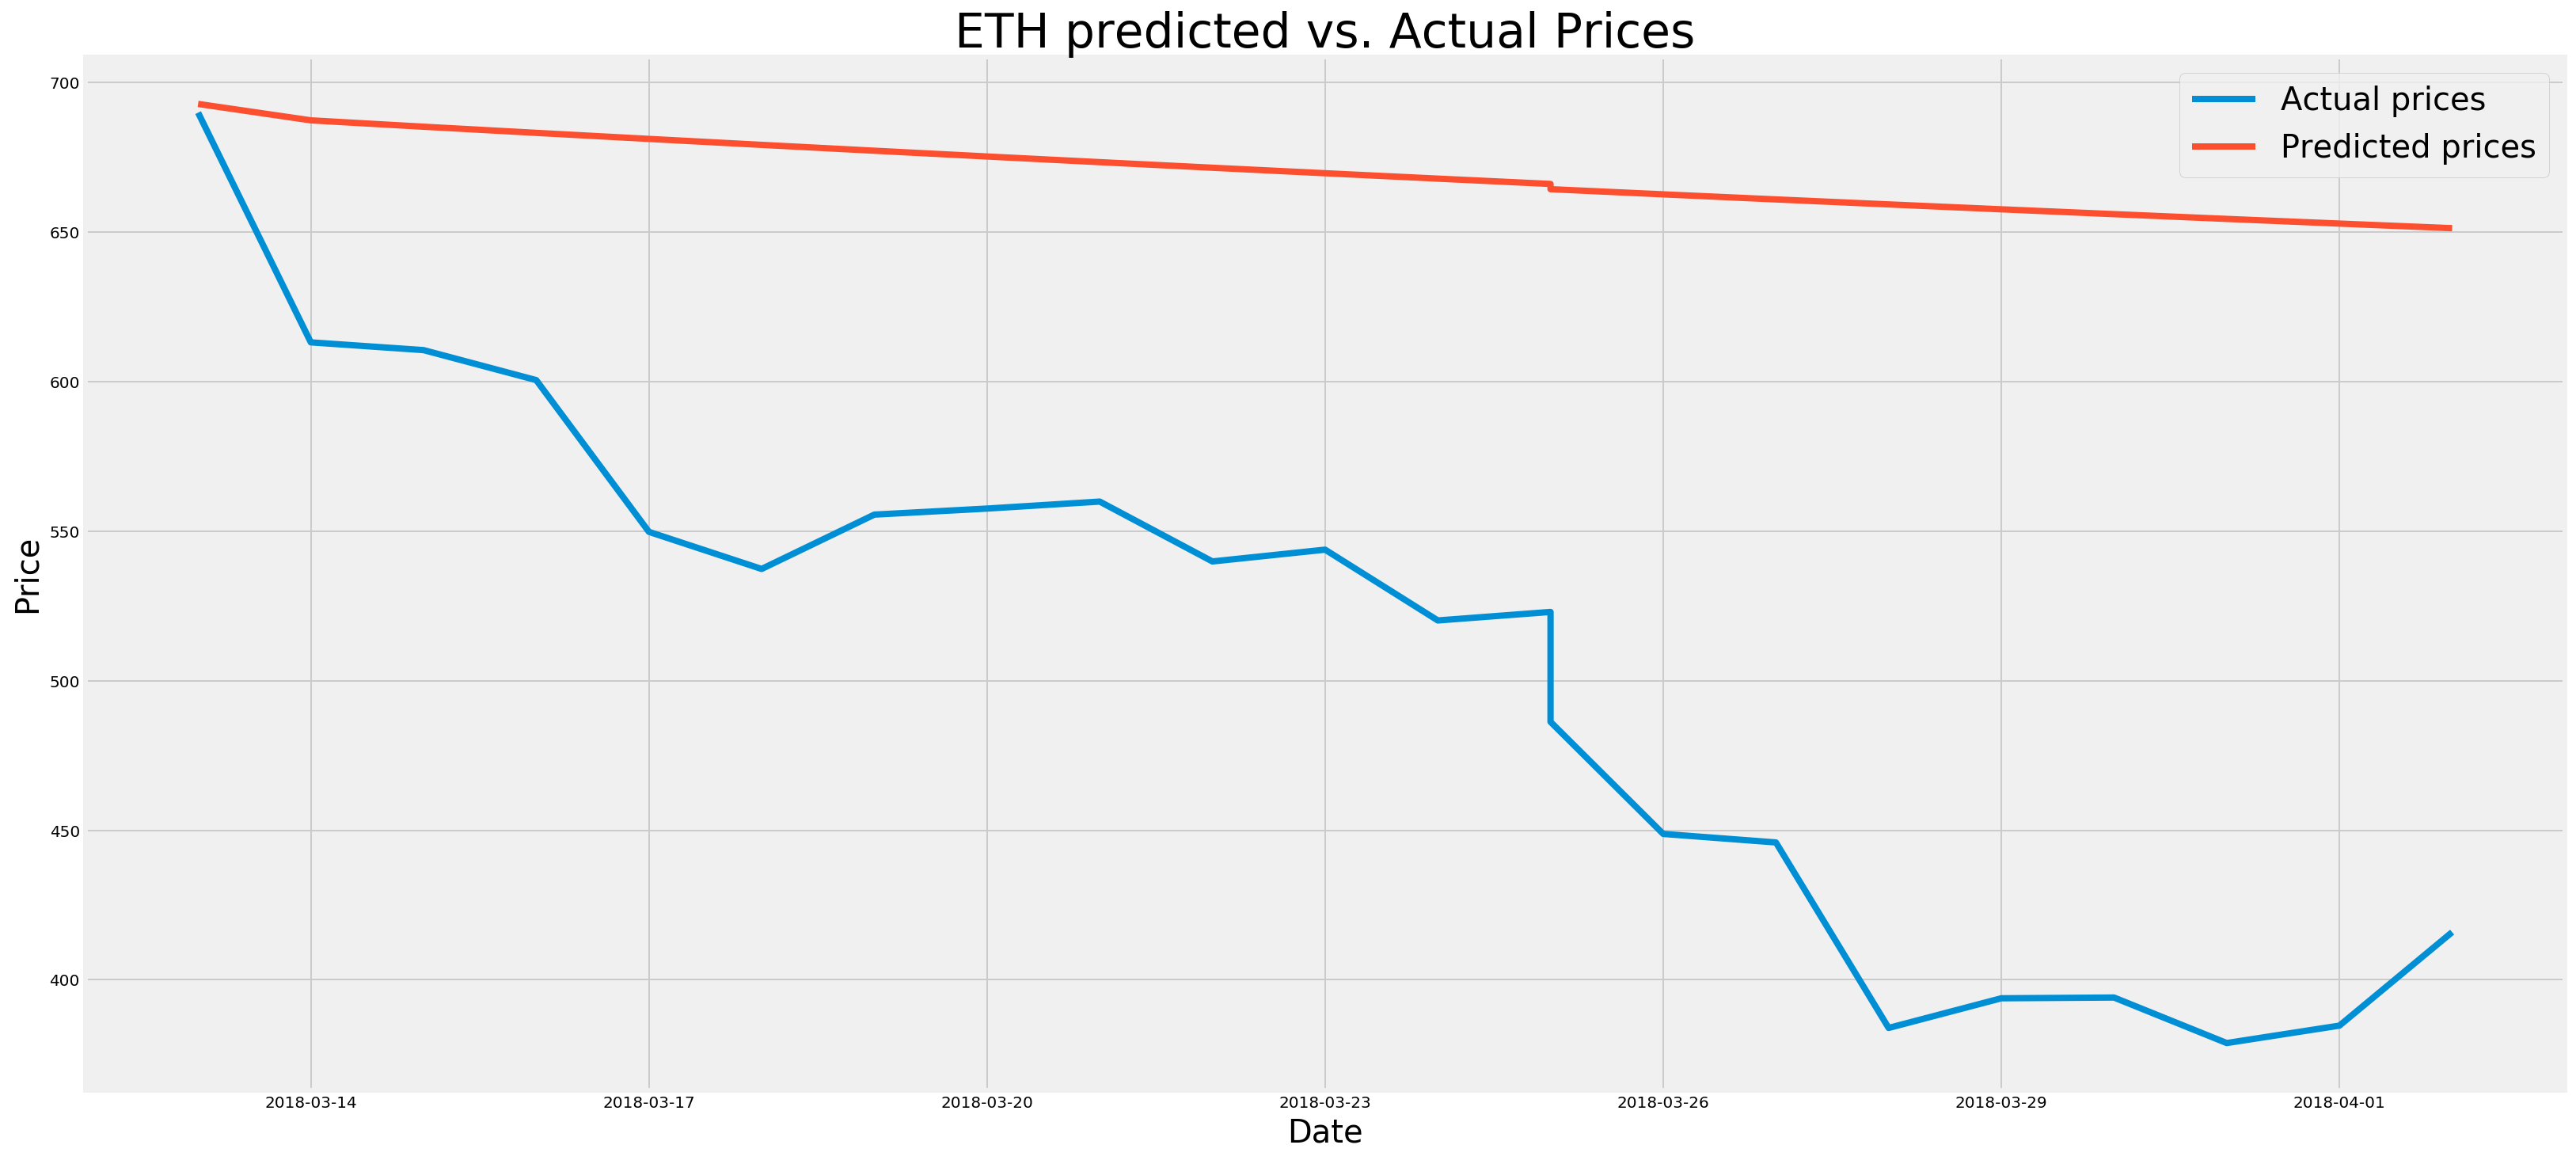

In [82]:
Fig, ax = plt.subplots(figsize=(25, 12))

ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Price', fontsize=20)
ax.set_title('ETH predicted vs. Actual Prices', fontsize=30)

ax.plot(eth_pred_df.Close, label='Actual prices')
ax.legend(loc='upper right')

ax.plot(eth_pred_df.Predictions, label='Predicted prices')
ax.legend(loc='upper right', fontsize=20);

We can see the same issue as with BTC here, the global trend is the same even though it's less pronounced for this cryptocurrency. However, ETH also seems far less volatile than BTC. 

Further to these observations, what strikes us in both these cryptocurrencies is their volatility. This is why I find it interesting to fit another model on our data, which has a measure for volatility: GARCH. 

### 1.3.7. GARCH model

In [83]:
from arch import arch_model
from arch.univariate import ARCH, GARCH, ARX
arch11 = arch_model(b_training_values, p=1, q=1)

# Fitting the ARCH model

b_res = arch11.fit(update_freq=10)
print(b_res.summary())

Iteration:     10,   Func. Count:     62,   Neg. LLF: 5676.459841499314
Iteration:     20,   Func. Count:    129,   Neg. LLF: 5285.989634051106
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5285.9896322352815
            Iterations: 20
            Function evaluations: 129
            Gradient evaluations: 20
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.449
Mean Model:             Constant Mean   Adj. R-squared:                 -0.449
Vol Model:                      GARCH   Log-Likelihood:               -5285.99
Distribution:                  Normal   AIC:                           10580.0
Method:            Maximum Likelihood   BIC:                           10597.6
                                        No. Observations:                  611
Date:                Fri, Jun 01 2018   Df Residuals:                      607
Time:       

In [84]:
# Autoregression model for GARCH

b_ar = ARX(b_training_values,lags=[1,2,5])

b_res_ar = b_ar.fit()
print(b_res_ar.summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                  Close   R-squared:                       0.992
Mean Model:                        AR   Adj. R-squared:                  0.992
Vol Model:          Constant Variance   Log-Likelihood:               -4465.32
Distribution:                  Normal   AIC:                           8940.65
Method:            Maximum Likelihood   BIC:                           8962.68
                                        No. Observations:                  606
Date:                Fri, Jun 01 2018   Df Residuals:                      601
Time:                        11:40:08   Df Model:                            5
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const         25.9985     16.428      1.583      0.114    [ -

In [87]:
b_ar.volatility = GARCH(p=2,q=1)
res1 = b_ar.fit(update_freq=0)
res1.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3554.006517269043
            Iterations: 43
            Function evaluations: 457
            Gradient evaluations: 42


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.992
Mean Model:                        AR   Adj. R-squared:                  0.992
Vol Model:                      GARCH   Log-Likelihood:               -3554.01
Distribution:                  Normal   AIC:                           7124.01
Method:            Maximum Likelihood   BIC:                           7159.27
                                        No. Observations:                  606
Date:                Fri, Jun 01 2018   Df Residuals:                      598
Time:                        11:40:51   Df Model:                            8
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          1.8039      6.771      0.266      0.790    [-11.468, 15.075]
Close[1]       0.9808  7.113e-02     13.790  2.933e-43    [  0.841,  1.120]
Close[2]   1.4461e-03  9.718e-02  1.488e-02      0.988    [ -0.189,  0.192]
Close[5]       0.0178  4.574e-02      0.389      0.698 [-7.187e-02,  0.107]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          9.1400     21.037      0.434      0.664   [-32.091, 50.372]
alpha[1]       0.1699  7.669e-02      2.216  2.672e-02 [1.961e-02,  0.320]
alpha[2]   2.5525e-08      0.243  1.051e-07      1.000   [ -0.476,  0.476]
beta[1]        0.8301      0.218      3.801  1.442e-04   [  0.402,  1.258]
==========================================================================

Covariance estimator: robust
"""

In [265]:
forecasts = res1.forecast(start=4,horizon=10)

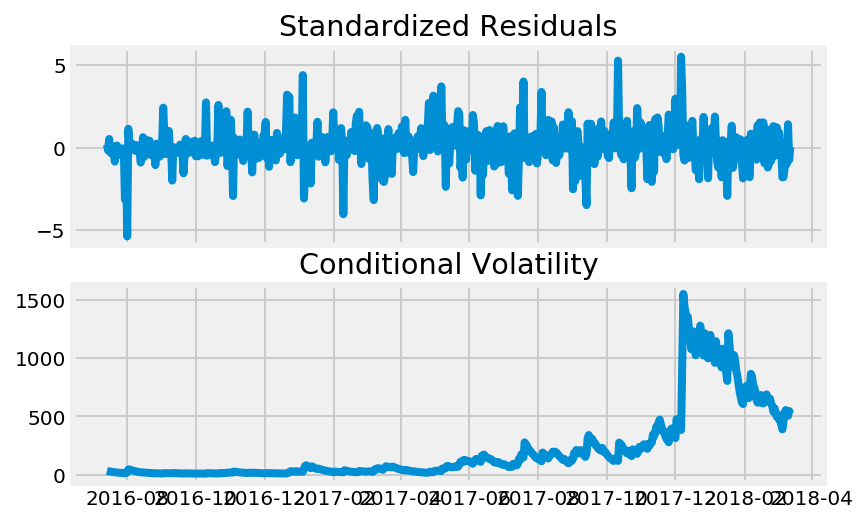

In [89]:
res1.plot();

In [262]:
# We now have to fit the GARCH model again for Ethereum:

arch12 = arch_model(e_training_values, p=1, q=1)

# Fitting the ARCH model

e_res = arch11.fit(update_freq=10)
print(e_res.summary())

Iteration:     10,   Func. Count:     62,   Neg. LLF: 5676.459841499314
Iteration:     20,   Func. Count:    129,   Neg. LLF: 5285.989634051106
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5285.9896322352815
            Iterations: 20
            Function evaluations: 129
            Gradient evaluations: 20
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.449
Mean Model:             Constant Mean   Adj. R-squared:                 -0.449
Vol Model:                      GARCH   Log-Likelihood:               -5285.99
Distribution:                  Normal   AIC:                           10580.0
Method:            Maximum Likelihood   BIC:                           10597.6
                                        No. Observations:                  611
Date:                Sun, Jun 03 2018   Df Residuals:                      607
Time:       

In [263]:
# Autoregression model for GARCH

e_ar = ARX(e_training_values,lags=[1,2,5])

e_res_ar = e_ar.fit()
print(e_res_ar.summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                  Close   R-squared:                       0.977
Mean Model:                        AR   Adj. R-squared:                  0.977
Vol Model:          Constant Variance   Log-Likelihood:               -1047.00
Distribution:                  Normal   AIC:                           2103.99
Method:            Maximum Likelihood   BIC:                           2120.46
                                        No. Observations:                  199
Date:                Sun, Jun 03 2018   Df Residuals:                      194
Time:                        15:26:39   Df Model:                            5
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          9.4209      6.575      1.433      0.152    [ -

In [264]:
e_ar.volatility = GARCH(p=2,q=1)
e_res1 = e_ar.fit(update_freq=0)
e_res1.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 969.834797395462
            Iterations: 23
            Function evaluations: 244
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.977
Mean Model:                        AR   Adj. R-squared:                  0.976
Vol Model:                      GARCH   Log-Likelihood:               -969.835
Distribution:                  Normal   AIC:                           1955.67
Method:            Maximum Likelihood   BIC:                           1982.02
                                        No. Observations:                  199
Date:                Sun, Jun 03 2018   Df Residuals:                      191
Time:                        15:27:18   Df Model:                            8
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          6.0016      3.971      1.511      0.131    [ -1.782, 13.785]
Close[1]       1.0268  8.697e-02     11.806  3.616e-32    [  0.856,  1.197]
Close[2]      -0.0947  9.880e-02     -0.959      0.338  [ -0.288,9.892e-02]
Close[5]       0.0523  4.935e-02      1.060      0.289 [-4.442e-02,  0.149]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         18.9862     21.135      0.898      0.369   [-22.438, 60.410]
alpha[1]       0.2311      0.109      2.114  3.453e-02 [1.682e-02,  0.445]
alpha[2]       0.0000      0.171      0.000      1.000   [ -0.335,  0.335]
beta[1]        0.7689      0.143      5.386  7.210e-08   [  0.489,  1.049]
==========================================================================

Covariance estimator: robust
"""

In [266]:
forecasts = e_res1.forecast(start=4,horizon=10)

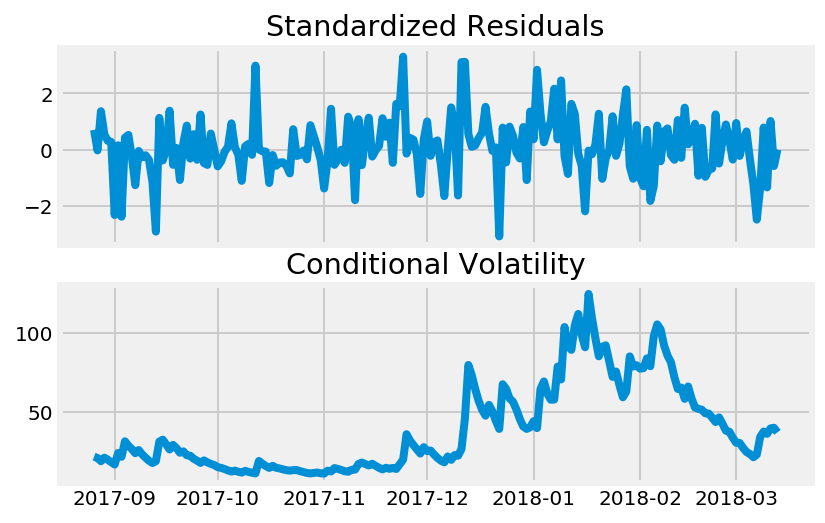

In [267]:
e_res1.plot();

# Part 2: NLP for Economic Sentiment Analysis


In this part of the project we are going to use Web Scraping and NLP in order to examine the Economic climate Bitcoin and Ethereum installed over time, with the variations that followed. My goal is to show a correlation between the Economic sentiment and the variations and volatility of these Cryptocurrencies. 

My goal is now to find specific time periods where Bitcoin and Ethereum were particularly high and then attempt to scrape data from those dates. 

## 1. Twitter NLP

In [90]:
# First I'm going to find out what is the maximum price BTC ever reached:

btc_highest = btc.High.max() # --> Using High instead of Close
eth_highest = eth.High.max()

print('The maximum value BTC ever reached is: $',btc_highest)
print('The maximum value ETH ever reached is: $',eth_highest)

The maximum value BTC ever reached is: $ 19870.619141
The maximum value ETH ever reached is: $ 1422.859985


In [91]:
# I also need to find out when this was:

btc_max = btc.loc[btc['High']==btc_highest]
eth_max = eth.loc[eth['High']==eth_highest]

print('BTC maximum was reached on', btc_max.index)
print('ETH maximum was reached on', eth_max.index)

BTC maximum was reached on DatetimeIndex(['2017-12-17'], dtype='datetime64[ns]', name='Date', freq=None)
ETH maximum was reached on DatetimeIndex(['2018-01-13'], dtype='datetime64[ns]', name='Date', freq=None)


After obtaining the information about when BTC reached its peak, my investigation led me to conclude that one of the major elements that led to the downturn of this cryptocurrency was the major fork that it experienced on that date. Therefore, I'll be performing NLP on users comments on the forum prior to that date, starting december 4th. 

## 1.1. Cleaning the tweets

In [92]:
# Reading in a Bitcoin tweets dataset:

twt = pd.read_csv('/Users/jamesliounis/documents/Capstone Project DSI/bitcoin-twitter.csv')

print(twt.shape) # --> The dataset has 9648 tweets

(9648, 17)


In [93]:
twt.shape

(9648, 17)

In [94]:
twt.head()

Label                 Date       Screen Name          Full Name  \
0   NaN  12/12/2017 15:33:12  @karlyndrake2617       Karlyn Drake   
1   NEG  12/12/2017 15:33:13     @marketranger  #MarketRanger 618   
2   NaN  12/12/2017 15:33:15  @ProgrammingWrld   ProgrammingWorld   
3   POS  12/12/2017 15:33:15         @Tatoshak     Абрамова Лидия   
4   POS  12/12/2017 15:33:16      @MarkMarkafv   Mark Fredrickson   

                                          Tweet Text            Tweet ID  \
0  RT @realsheepwolf: 👉 $INTV 👈 SEE WHY THIS IS A...  940726256945033216   
1  Nearly $70M of Bitcoin Hacked From Crypto Mini...  940726262561234944   
2  RT @BitcoinWrld: Shorting #Bitcoin a challenge...  940726271318921216   
3  #RPT #bounty #bitcoin #cryptocurrency #blockch...  940726272459771904   
4  @RonPaul Answer is clear: If you bought $1000 ...  940726275618103296   

                   App  Followers  Follows  Retweets  Favorites Verfied  \
0  Twitter for Android          0       20      2628          0      No   
1     ContentStudio.io       2040      946         0          0      No   
2            Bad Kitty      23033     2074        13          0      No   
3   Twitter Web Client      12430     1022         0          0      No   
4  Twitter for Android         25      127         0          7      No   

   User Since       Location  \
0   11/9/2016            NaN   
1  10/11/2014            NaN   
2   1/11/2016  United States   
3   1/11/2013            NaN   
4  12/26/2015            NaN   

                                                 Bio Profile Image Google Maps  
0  Palit-ulit, paikot-ikot, ari-parito, parot-par...          View         NaN  
1  #CryptoSpace meets Network Marketing, #realest...          View         NaN  
2  All the #coding news and technics of your lang...          View         NaN  
3  Он хотел встретить другую.. такую же как она, ...          View         NaN  
4                                                NaN          View         NaN

In [95]:
# Example of a tweet that can be found in the dataset:

twt['Tweet Text'][1]

'Nearly $70M of Bitcoin Hacked From Crypto Mining Company https://t.co/91UdQqpXb9 #affluencenetwork #marketranger… https://t.co/7ihamZBi6U'

In [97]:
# After looking closer at the dataset, I realize that the only rows that I need are those with actual opinions about 
# BTC. Let's look at the differet labels contained in the dataset:

twt['Label'].value_counts()

# This shows that only 116 tweets actually have a rating

POS    90
NEG    26
Name: Label, dtype: int64

We can see here that there are only 116 labels which are either positive or negative. Indeed, Bitcoin is a very popular hashtag on Twitter so most of it, being either retweets or advertising, appears as NaNs. 

In [98]:
# All the data that we have is for the same day: December 12, 2017. We need to see what value BTC had that day:

dec12 = btc.loc[btc.index == '2017-12-12']

print('Open', dec12['Open'])
print('High', dec12['High'])
print('Low', dec12['Close'])
print('Adj Close', dec12['Adj Close'])
print('Volume', dec12['Volume'])

Open Date
2017-12-12    16733.289063
Name: Open, dtype: float64
High Date
2017-12-12    17560.650391
Name: High, dtype: float64
Low Date
2017-12-12    17083.900391
Name: Close, dtype: float64
Adj Close Date
2017-12-12    17083.900391
Name: Adj Close, dtype: float64
Volume Date
2017-12-12    2246138895
Name: Volume, dtype: int64


These values of Bitcoin are among the highest ever recorded as the highest BTC reached that day was 17560 and the highest it ever reached was 19870. This makes this dataset interesting as these tweets were posted in the middle of the bitcoin craze of December 2017. 

In [99]:
twt.head()

Label                 Date       Screen Name          Full Name  \
0   NaN  12/12/2017 15:33:12  @karlyndrake2617       Karlyn Drake   
1   NEG  12/12/2017 15:33:13     @marketranger  #MarketRanger 618   
2   NaN  12/12/2017 15:33:15  @ProgrammingWrld   ProgrammingWorld   
3   POS  12/12/2017 15:33:15         @Tatoshak     Абрамова Лидия   
4   POS  12/12/2017 15:33:16      @MarkMarkafv   Mark Fredrickson   

                                          Tweet Text            Tweet ID  \
0  RT @realsheepwolf: 👉 $INTV 👈 SEE WHY THIS IS A...  940726256945033216   
1  Nearly $70M of Bitcoin Hacked From Crypto Mini...  940726262561234944   
2  RT @BitcoinWrld: Shorting #Bitcoin a challenge...  940726271318921216   
3  #RPT #bounty #bitcoin #cryptocurrency #blockch...  940726272459771904   
4  @RonPaul Answer is clear: If you bought $1000 ...  940726275618103296   

                   App  Followers  Follows  Retweets  Favorites Verfied  \
0  Twitter for Android          0       20      2628          0      No   
1     ContentStudio.io       2040      946         0          0      No   
2            Bad Kitty      23033     2074        13          0      No   
3   Twitter Web Client      12430     1022         0          0      No   
4  Twitter for Android         25      127         0          7      No   

   User Since       Location  \
0   11/9/2016            NaN   
1  10/11/2014            NaN   
2   1/11/2016  United States   
3   1/11/2013            NaN   
4  12/26/2015            NaN   

                                                 Bio Profile Image Google Maps  
0  Palit-ulit, paikot-ikot, ari-parito, parot-par...          View         NaN  
1  #CryptoSpace meets Network Marketing, #realest...          View         NaN  
2  All the #coding news and technics of your lang...          View         NaN  
3  Он хотел встретить другую.. такую же как она, ...          View         NaN  
4                                                NaN          View         NaN

In [100]:
# I want to see if this dataset covers the whole day:

# Removing the calendar date, which we already know and the minutes and seconds:

def day_remover(string):
    return string[-9:-6]  # --> Defining a function which will help us achieve it

twt['Date'] = twt['Date'].map(day_remover)

twt['Date'].value_counts()  # --> It only covers 3 hours but 10000 tweets is still representative enough.

 16    2610
 17    2334
 18    2143
 15    1303
 19    1258
Name: Date, dtype: int64

In [101]:
twt.set_index('Date',inplace = True) # --> Setting the time as the index

In [102]:
print('The highest number of tweets was',twt.index.value_counts().max(),'at 4pm')

The highest number of tweets was 2610 at 4pm


In [103]:
# We are going to work only with tweets that have actual labels. We are going to replace the NaN's with 'Unknown':

def trans(string):   # -> Function which replaces each label with a number
    if string == 'NEG':
        return 0
    elif string == 'POS':
        return 1
    else:
        return 3


twt['Label2'] = twt.Label.map(trans) # --> We replaced everything here with numeric values

# Let's drop the old label column:

twt.drop('Label', inplace = True, axis=1)

# Repeating the value counts in order to see clearly how many tweets we have belonging to each label:

twt.Label2.value_counts()


3    9532
1      90
0      26
Name: Label2, dtype: int64

In [104]:
# Before actually performing any sentiment analysis, we have to remove any characters which might be an obstacle 
# especially hasthags. Indeed, the word behind a hashtag on twitter can be important. 

def char_remover(sentence):
    return sentence.replace('#','')
            
twt['Clean Tweets'] = twt['Tweet Text'].map(char_remover)

# We also need to remove all the URL's as they are of no use to us, and generally reflect advertising:

import re

def url_remover(string): 
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', string)

twt['Clean Tweets2'] = twt['Clean Tweets'].map(url_remover)

# We verify:

twt['Clean Tweets2']

# It seems that our text is now ridden of hasthags and URL's. We can now work with it. 

Date
 15    RT @realsheepwolf: 👉 $INTV 👈 SEE WHY THIS IS A...
 15    Nearly $70M of Bitcoin Hacked From Crypto Mini...
 15    RT @BitcoinWrld: Shorting Bitcoin a challenge,...
 15    RPT bounty bitcoin cryptocurrency blockchain i...
 15    @RonPaul Answer is clear: If you bought $1000 ...
 15    RT @ORACLEofETH: Bitcoin: savings account Lite...
 15    « Every single financial function that banks c...
 15    Buy Bitcoin With PayPal! Also with CC, paysafe...
 15    RT @card_bitcoin: BitcoinCard Airdrop Bitcoin ...
 15    Must Watch -> IBM Think Academy: Blockchain, H...
 15    1 BTC Price: BTC-e USD Bitstamp 16790.00 USD C...
 15    RT @michaelkohler20: Why Bitcoin Will Fail - W...
 15    RT @michaelkohler20: Why Bitcoin Will Fail - W...
 15    If there has ever been bias in financial repor...
 15    RT @michaelkohler20: Why Bitcoin Will Fail - W...
 15    RT @syscoin: Development Update: Syscoin Auth ...
 15    Bangun Masa Depan dengan Bitmora, sebuah Excha...
 15    RT @michaelkohler20

## 1.2. Vader Sentiment Analysis

In [105]:
# We are now going to use Vader for our sentiment analysis of these tweets:
!pip install vaderSentiment

In [317]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
#analyser.emojis

In [322]:
# First we'd like to clean up the tweets. We already cleaned them up from URL's but now we want to take care of the
# punctuation to just be left with raw text:

import string
twt['Clean Tweets3'] = twt['Clean Tweets2'].map(lambda x: str(
    ''.join([y for y in list(x.lower()) if y in string.ascii_lowercase+' -'])))
twt['Clean Tweets3'] = twt['Clean Tweets3'].map(lambda x: x.replace('-', ' '))

In [318]:
# Finally, we’ll use the polarity_scores() method to get the sentiment metrics for each tweet: 

def print_sentiment_scores(tweet):     # -> Function which will return sentiment scores
    snt = analyser.polarity_scores(tweet)
    return(snt)
    
# We now create a column in our dataframe with the sentiment score for each of the tweets:

twt['Sentiment Score'] = twt['Clean Tweets3'].map(print_sentiment_scores)

twt['Sentiment Score']

Date
 15    {'neg': 0.145, 'neu': 0.628, 'pos': 0.227, 'co...
 15    {'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...
 15    {'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'comp...
 15    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
 15    {'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...
 15    {'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...
 15    {'neg': 0.107, 'neu': 0.893, 'pos': 0.0, 'comp...
 15    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
 15    {'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...
 15    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
 15    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
 15    {'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'comp...
 15    {'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'comp...
 15    {'neg': 0.076, 'neu': 0.924, 'pos': 0.0, 'comp...
 15    {'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'comp...
 15    {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...
 15    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
 15    {'neg': 0.179, 'neu

In [319]:
def high_score(score):                 # --> Defining a function which will return for each sentiment analysis the 
                                       # most pronounced sentiment
    maximum = max(score, key=score.get) 
    return(maximum, score[maximum])

    
twt['highest score'] = twt['Sentiment Score'].map(high_score)  # Assigning it to a new column in our dataframe

In [320]:
# Now I'd like to count the different values that appear in that column, to see which sentiment appears the most:

maximum = []

for score in scores:
    maximum.append(max(score, key=score.get))
    
print('Occurences of neutral tweets:', maximum.count('neu'))
print('Occurences of positive tweets:', maximum.count('pos'))
print('Occurences of negative tweets:',maximum.count('neg'))
print('Other:',maximum.count('compound'))

Occurences of neutral tweets: 9121
Occurences of positive tweets: 6
Occurences of negative tweets: 20
Other: 501


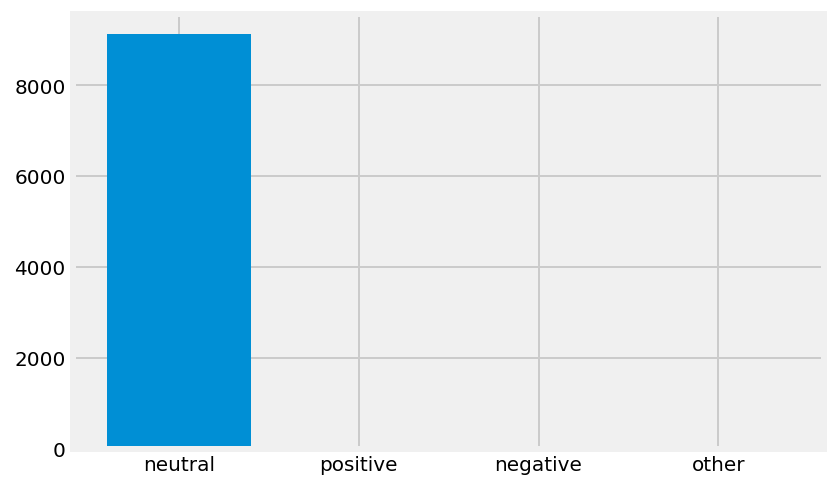

In [321]:
count_dict = {'neutral':9121,'positive':6,'negative':20,'other':20}

import matplotlib.pyplot as plt

plt.bar(range(len(count_dict)), list(count_dict.values()), align='center')
plt.xticks(range(len(count_dict)), list(count_dict.keys()))

plt.show()

The amount of 'neutral' classified tweets seems to dominate here, so much indeed that we can't even see the other ones. However, we should keep in mind that most of these tweets are advertisements for cryptocurrency platforms, online brokers, etc. However, they can also be purely informative (information that users give about something that might affect BTC price) or retweets, which is also very likely. 

We should also pay attention to the "compound" polarity score. This occurs generally when the tweet cannot be classified. The compound is the aggregation of all the scores: this would mean that neither one of the other scores was important enough to overbalance the aggregation of them. 

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

In [167]:
cvec = CountVectorizer()

# Fitting the vectorizer on our data
cvec.fit(twt['Clean Tweets2'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [170]:
# Checking the length in a vectorized state:

len(cvec.get_feature_names())

12272

In [173]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(twt['Clean Tweets2'])

# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
print()
# number of different words
print(len(words))

['fundamentals', 'funded', 'funding', 'fundraising', 'funds', 'fundyourselfnow', 'funn', 'funnest', 'funny', 'funtowatch', 'furure', 'fut', 'futu', 'futur', 'future', 'futurebit', 'futuremoney', 'futurenet', 'futures', 'futuresmarket']

12016


In [230]:
# We need to break down our tweets into the 4 main categories to then be able to find word importance in each
# category:

def highest_sentiment(score):        # --> Defining a function which will return for each sentiment analysis ONLY the 
                                       # most pronounced sentiment
    maximum = max(score, key=score.get) 
    return(maximum)

twt['highest sentiment'] = twt['Sentiment Score'].map(highest_sentiment)

Date
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15         neu
 15    compound
 15         neu
 15         neu
 15         neu
         ...   
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19    compound
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19    compound
 19         neg
 19         neu
 19    compound
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
 19    compound
 19         neu
 19         neu
 19         neu
 19         neu
 19         neu
Name: highest senti

In [235]:
# Using masks to assign the tweet texts to these different categories:

neutral = twt.loc[twt['highest sentiment']=='neu']['Clean Tweets2']
positive = twt.loc[twt['highest sentiment']=='pos']['Clean Tweets2']
negative = twt.loc[twt['highest sentiment']=='neg']['Clean Tweets2']
compound = twt.loc[twt['highest sentiment']=='neu']['Clean Tweets2']

## 1.3. Wordclouds

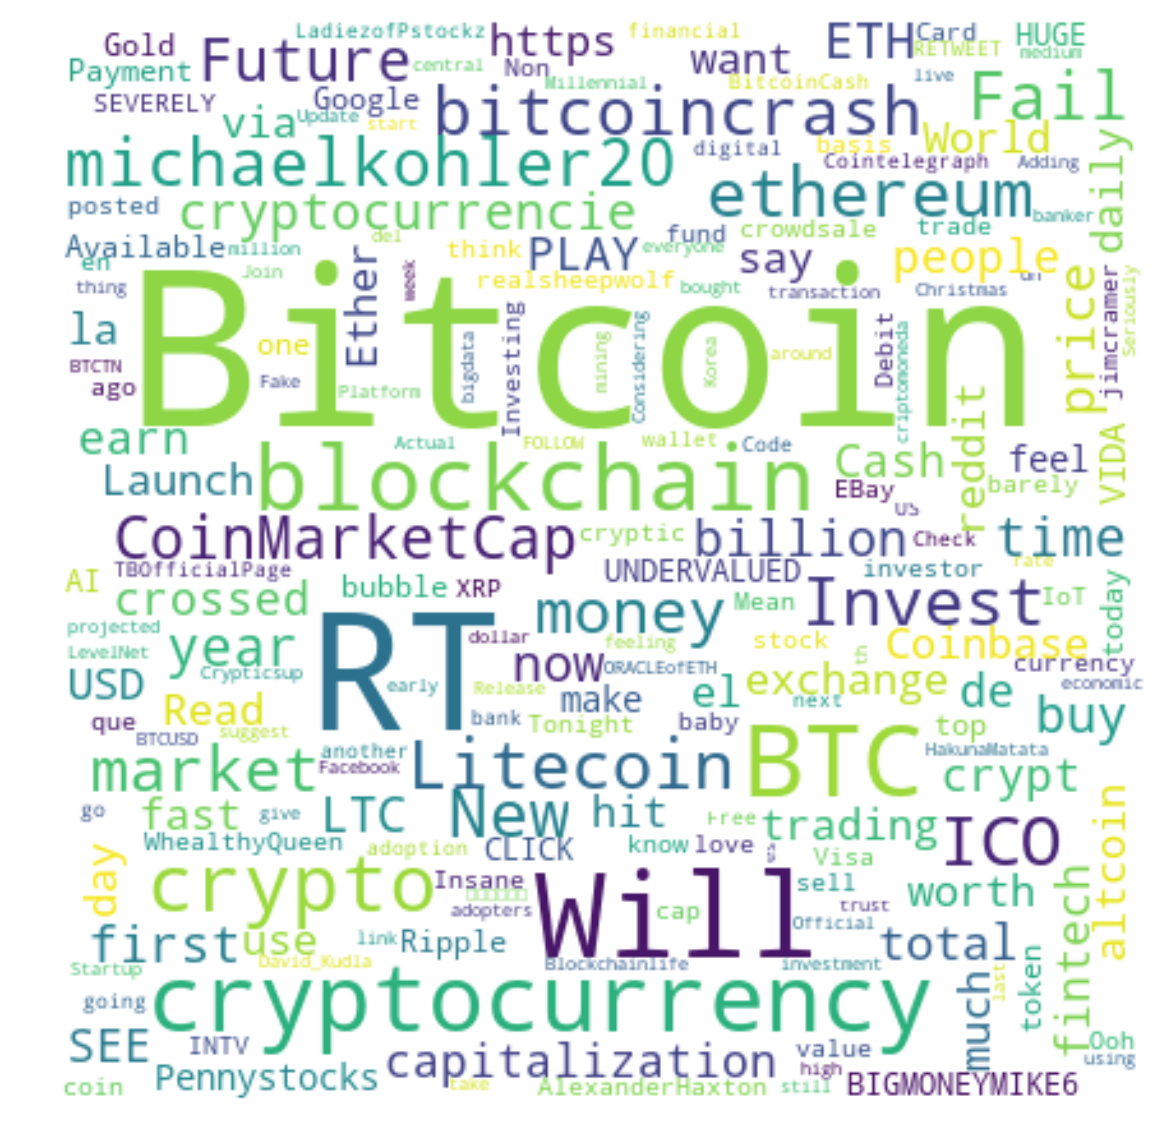

In [355]:
btc_neutral_mask = np.array(Image.open(('/Users/jamesliounis/documents/Capstone Project DSI/btc1.png')))

#creating a WordCloud with the top 400 single words from the neutral tweets
wc = WordCloud(background_color='white',
               max_words=200,
               mask=btc_neutral_mask,
               #colormap=ocean,
               collocations=False).generate(' '.join(neutral))

#saving the resulting WordCloud image
#wc.to_file('nhm_wordcloud_1.png')

#displaying the WordCloud

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

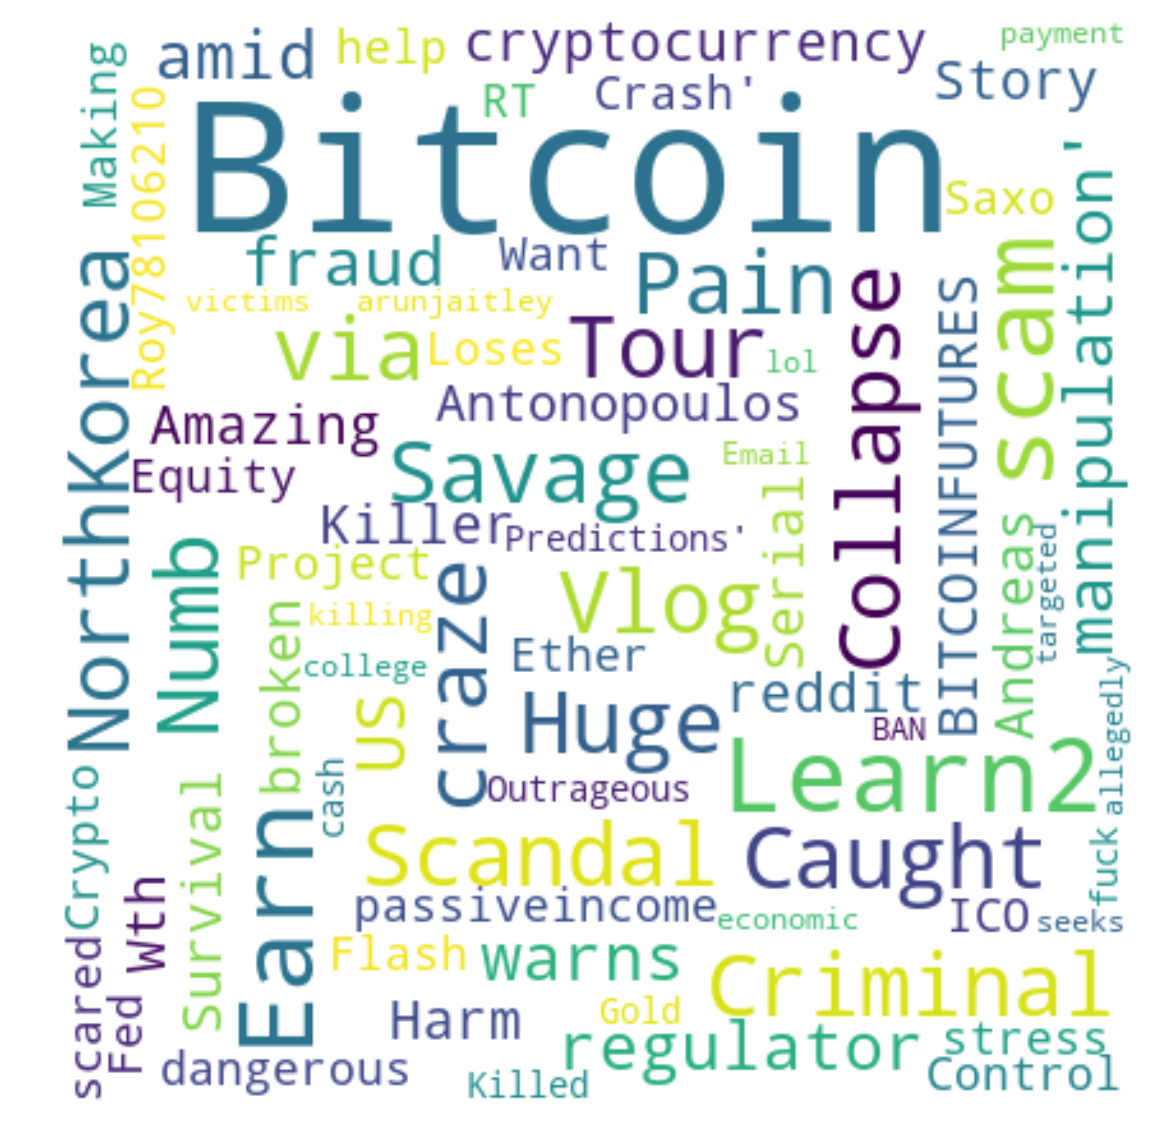

In [351]:
nhm_mask = np.array(Image.open(('/Users/jamesliounis/documents/Capstone Project DSI/btc1.png')))

#creating a WordCloud with the top 500 single words from the lemmatized text
wc = WordCloud(background_color='white',
               max_words=400,
               mask=nhm_mask,
               #colormap=ocean,
               collocations=False).generate(' '.join(negative))

#saving the resulting WordCloud image
#wc.to_file('nhm_wordcloud_1.png')

#displaying the WordCloud
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

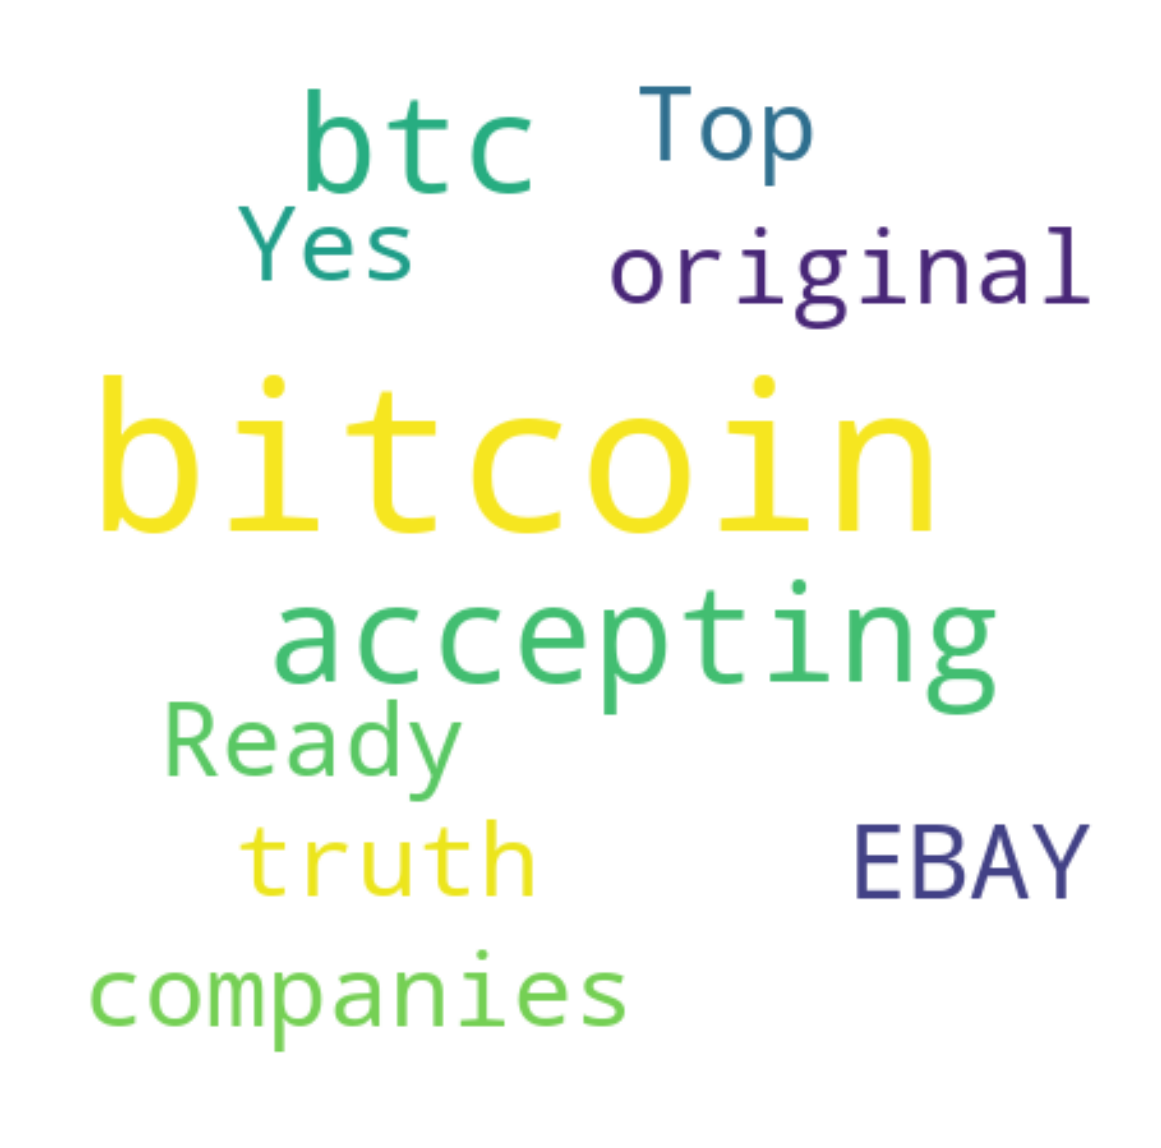

In [352]:
nhm_mask = np.array(Image.open(('/Users/jamesliounis/documents/Capstone Project DSI/btc1.png')))

#creating a WordCloud with the top 500 single words from the lemmatized text
wc = WordCloud(background_color='white',
               max_words=600,
               mask=nhm_mask,
               #colormap=ocean,
               collocations=False).generate(' '.join(positive))

#saving the resulting WordCloud image
#wc.to_file('nhm_wordcloud_1.png')

#displaying the WordCloud
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

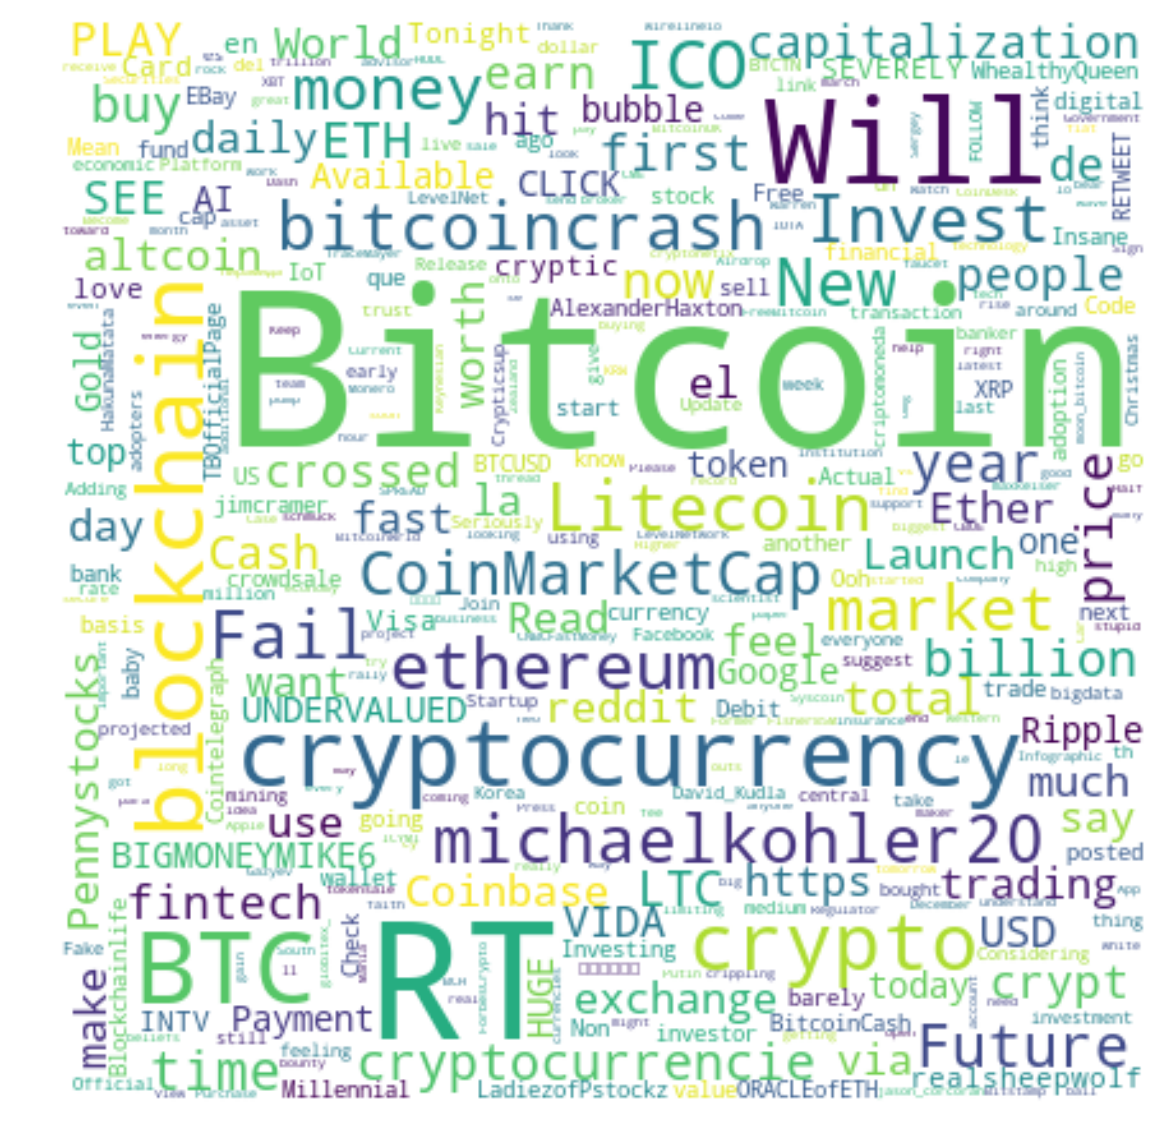

In [354]:
nhm_mask = np.array(Image.open(('/Users/jamesliounis/documents/Capstone Project DSI/btc1.png')))

#creating a WordCloud with the top 500 single words from the lemmatized text
wc = WordCloud(background_color='white',
               max_words=500,
               mask=nhm_mask,
               #colormap=ocean,
               collocations=False).generate(' '.join(compound))

#saving the resulting WordCloud image
#wc.to_file('nhm_wordcloud_1.png')

#displaying the WordCloud
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2. Bloomberg NLP

In the second part of the NLP I decided to use quotes from the Bloomberg website from famous people in the finance industry who each state their opinion on Bitcoin. 

In [246]:
import requests
from bs4 import BeautifulSoup


response = requests.get('https://www.bloomberg.com/features/bitcoin-bulls-bears/')
soup = BeautifulSoup(response.text, 'html.parser')


speakers = []
speaker_descriptions = []
statements = []
dates = []
colour = []

boxes = soup.find_all('div', class_='bPfbki')
for box in boxes:
    statements.append(box.find('p', class_='statement').text) 
    divs = box.find('div', class_='jUNGbL').find_all('div')
    div_content = []
    for div in divs:
        try: div_content.append(div.text)
        except: continue
    div_content = [string for string in div_content if string!='']
    speakers.append(div_content[1])
    speaker_descriptions.append(div_content[2])
    dates.append(div_content[3])
    colour.append('red')


boxes = soup.find_all('div', class_='iqqXjy')
for box in boxes:
    statements.append(box.find('p', class_='statement').text) 
    divs = box.find('div', class_='jUNGbL').find_all('div')
    div_content = []
    for div in divs:
        try: div_content.append(div.text)
        except: continue
    div_content = [string for string in div_content if string!='']
    speakers.append(div_content[1])
    speaker_descriptions.append(div_content[2])
    dates.append(div_content[3])
    colour.append('green')

df = pd.DataFrame()
df['speaker'] = speakers
df['speaker_info'] = speaker_descriptions
df['date'] = dates
df['statement'] = statements
df['colour'] = colour

In [279]:
# Inspecting the dataframe we just obtained:

df.head()

speaker                                       speaker_info  \
0       Jurrien Timmer     Director of global macro, Fidelity Investments   
1      Andreas Treichl       Chief executive officer, Erste Group Bank AG   
2  Lorenzo Bini Smaghi                      Chairman, Societe Generale SA   
3       William Dudley        President, Federal Reserve Bank of New York   
4      Joseph Stiglitz  Nobel prize-winning professor of economics, Co...   

         date                                          statement colour  \
0  11/30/2017  Digital currency is “disruptive, it has a lot ...    red   
1  11/30/2017  “I’m not” a bitcoin believer. “My kids think I...    red   
2  11/30/2017  “We will discover that behind this bitcoin sca...    red   
3  11/29/2017  “In terms of bitcoin, I would be pretty cautio...    red   
4  11/29/2017  “Bitcoin is successful only because of its pot...    red   

                                    Sentiment Scores       Highest Score  
0  {'neg': 0.023, 'neu': 0.947, 'pos': 0.03, 'com...        (neu, 0.947)  
1  {'neg': 0.093, 'neu': 0.852, 'pos': 0.055, 'co...        (neu, 0.852)  
2  {'neg': 0.217, 'neu': 0.783, 'pos': 0.0, 'comp...        (neu, 0.783)  
3  {'neg': 0.093, 'neu': 0.668, 'pos': 0.239, 'co...  (compound, 0.7618)  
4  {'neg': 0.062, 'neu': 0.757, 'pos': 0.181, 'co...        (neu, 0.757)

In [249]:
df.shape  # We can see here that we obtained 39 statements

(39, 5)

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 5 columns):
speaker         39 non-null object
speaker_info    39 non-null object
date            39 non-null object
statement       39 non-null object
colour          39 non-null object
dtypes: object(5)
memory usage: 1.6+ KB


In [283]:
df.statement[20]

'“Bitcoin is evil … So far almost all of the bitcoin discussion has been positive economics — can this actually work? And I have to say that I’m still deeply unconvinced.” – 12/28/2013'

In [308]:
# We want to clean up all the statements:

import string
df['clean statements'] = df.statement.map(lambda x: str(
    ''.join([y for y in list(x.lower()) if y in string.ascii_lowercase+' -'])))
df['clean statements'] = df['clean statements'].map(lambda x: x.replace('-', ' '))

In [313]:
cvec.fit(df['clean statements'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [314]:
len(cvec.get_feature_names())

396

### 2.1. Vader Sentiment analysis

In [310]:
# We are going to do the same thing as we did for the twitter NLP: sentiment analysis using VADER:

# Calling the same function used above:

df['Sentiment Scores'] = df['statement'].map(print_sentiment_scores)

# Now we have a column in our dataframe similar to the one for the Tweets:

df['Sentiment Scores']

0     {'neg': 0.023, 'neu': 0.947, 'pos': 0.03, 'com...
1     {'neg': 0.093, 'neu': 0.852, 'pos': 0.055, 'co...
2     {'neg': 0.217, 'neu': 0.783, 'pos': 0.0, 'comp...
3     {'neg': 0.093, 'neu': 0.668, 'pos': 0.239, 'co...
4     {'neg': 0.062, 'neu': 0.757, 'pos': 0.181, 'co...
5     {'neg': 0.0, 'neu': 0.77, 'pos': 0.23, 'compou...
6     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
7     {'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'comp...
8     {'neg': 0.248, 'neu': 0.702, 'pos': 0.05, 'com...
9     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
10    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
11    {'neg': 0.0, 'neu': 0.733, 'pos': 0.267, 'comp...
12    {'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp...
13    {'neg': 0.048, 'neu': 0.809, 'pos': 0.143, 'co...
14    {'neg': 0.074, 'neu': 0.807, 'pos': 0.119, 'co...
15    {'neg': 0.169, 'neu': 0.831, 'pos': 0.0, 'comp...
16    {'neg': 0.177, 'neu': 0.823, 'pos': 0.0, 'comp...
17    {'neg': 0.04, 'neu': 0.841, 'pos': 0.12, '

In [311]:
# We also want once again to extract the sentiment that is the most important for each statement:

df['Highest Score'] = df['Sentiment Scores'].map(high_score)

In [312]:
# What would be interesting here would be to see what people in the industry think about Bitcoin. A value counts
# would be a good way to visualize this:

# Now I'd like to count the different values that appear in that column, to see which sentiment appears the most:

b_maximum = []

for score in df['Sentiment Scores']:
    b_maximum.append(max(score, key=score.get))
    
print('Occurences of neutral statements:', b_maximum.count('neu'))
print('Occurences of positive statements:', b_maximum.count('pos'))
print('Occurences of negative statements:',b_maximum.count('neg'))
print('Other:',b_maximum.count('compound'))

Occurences of neutral statements: 31
Occurences of positive statements: 0
Occurences of negative statements: 0
Other: 8


### 2.1.2. Wordcloud

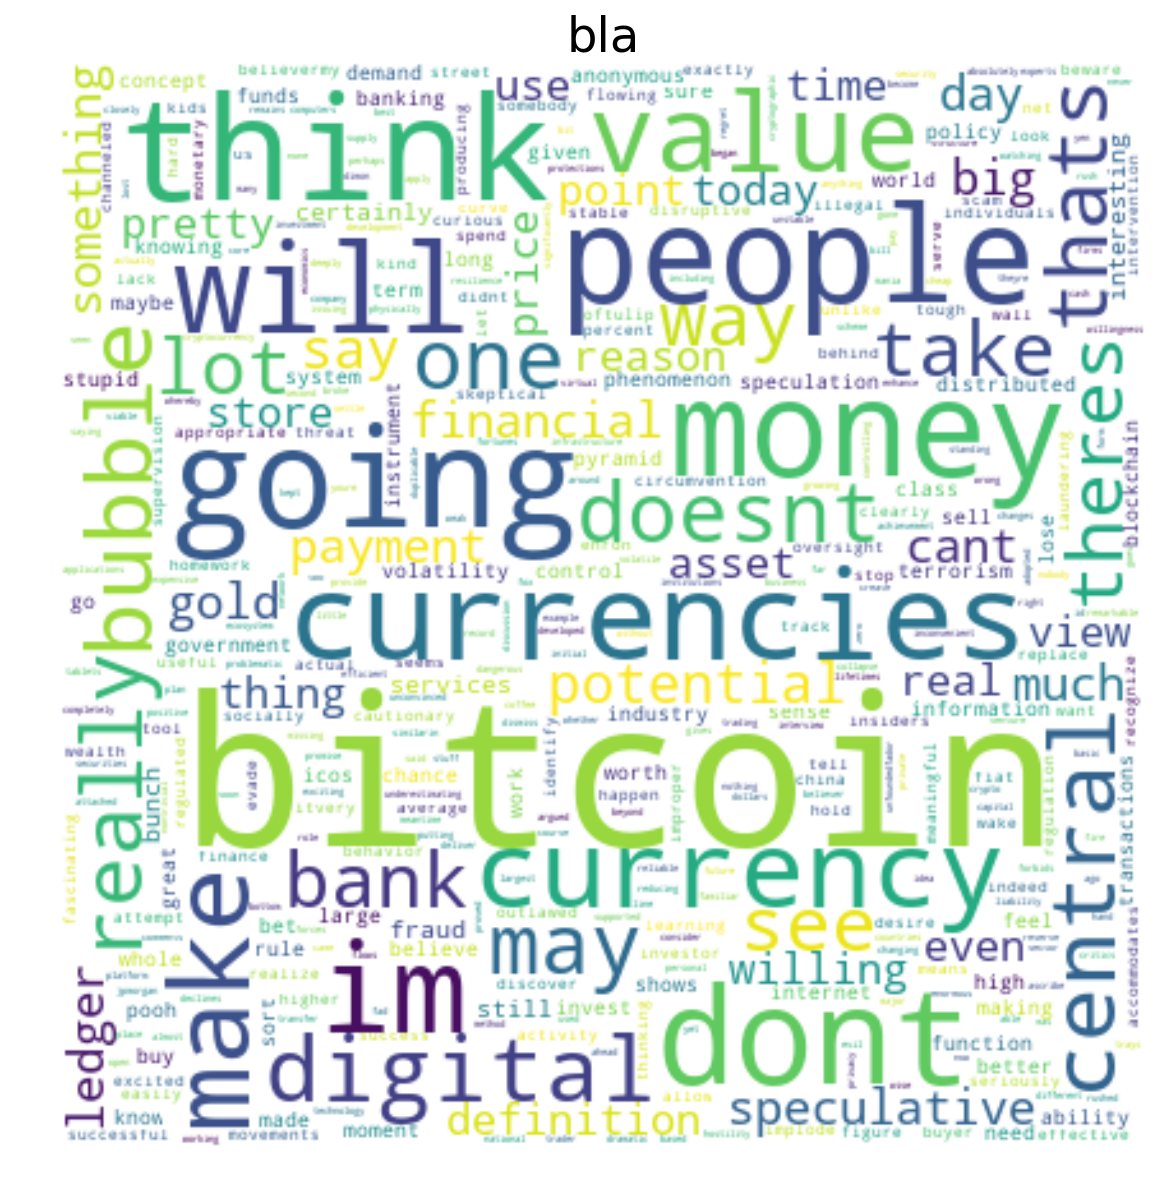

In [358]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud
import matplotlib.colors as colors

nhm_mask = np.array(Image.open(('/Users/jamesliounis/documents/Capstone Project DSI/btc1.png')))

#creating a WordCloud with the top 500 single words from the lemmatized text
wc = WordCloud(background_color='white',
               max_words=600,
               mask=nhm_mask,
               #colormap=ocean,
               collocations=False).generate(' '.join(df['clean statements']))

#saving the resulting WordCloud image
#wc.to_file('nhm_wordcloud_1.png')

#displaying the WordCloud
fig, ax = plt.subplots(figsize=[10,10])
ax.imshow(wc, interpolation='bilinear')
ax.axis("off")
ax.set_title('bla',fontsize=24)
plt.show()



# Part 3: Synthesis and Financial Analysis

## 3.1. Historical analysis of Bitcoin

Like every financial asset, Bitcoin variations can largely be attributed to non-economic factors generally political. After looking closely at the sharp variations it experienced, I conducted some research regarding the causes of plummeting or rise and found the following explanations.

### 3.1.1. Early 2014

Bitcoin experienced a very quick rise and a very quick fall. Price spiked to $1000 briefly, then settled in the 700-900 range for the rest of the month.

Price fell following the shutdown of Mt. Gox before recovering to the $600–$700 range.

Price continued to fall due to a false report regarding bitcoin ban in China and uncertainty over whether the Chinese government would seek to prohibit banks from working with digital currency exchanges.

The downtrend first slow down and then reverse, increasing over 30% in the last days of May after the lowest price reached since the cypriot financial crisis was reached on April 11th at 3:25 a.m. 

### 3.1.2. 2017 and early 2018

The year of 2017 was for Bitcoin the beginning of a period of quasi-constant expansion. Bitcoin was reaching new record highs very often, with the exception of a sharp downturn when the prices dipped sharply after China's ICO and exchange crackdown. From 5000 to ~2900. Nevertheless, it is important to note that Bitcoin also received Japan's blessing to legally be accepted as legal tender in the country in late September 2017 which can be reflected by the constant increase in the prices. 

January 17: Two consecutive months of expansion when Trump was elected president. 

Late 2017 however was the hardest downturn for Bitcoin, especially after the hard fork of December 17th 2017.On december 22nd 2017, Bitcoin price loses one third of its value in 24 hours, dropping below $14,000 

However, it is important to note that Bitcoin hit an all time high on december 12th 2017, nearing $20,000. However, it never recovered from its downturn and now the price is hovering around 7000-8000 dollars.

Тhe Federal Reserve Bank of San Francisco released an Economic Letter May 7, suggesting that Bitcoin’s (BTC) decline following its $20,000 peak was the result of the launch of Bitcoin futures trading, which allowed pessimists to enter the market, creating a downturn due to a negative economic sentiment.

However, there is a different theory that opposes itself to the Bank's. It is likely the last factor that has driven the latest drop in the price, as a proposed Bitcoin split (or “fork”) failed to gain support from developers towards the end of last week. The split would have doubled the number of coins in circulation (as previous splits have) and increased transaction speed. 

## 3.2. Historical analysis of Ethereum

Unlike Bitcoin, the different variations of Ethereum haven't been analyzed enough by Economists to be able to give an educated analysis. However, it is important to highlight its similarity to Bitcoin in the observed trends and patterns. Looking at the plot, the important periods I've been able to extract are the following:

### 3.2.1 June 2017

In June 2017, Ethereum experienced a very quick expansion and decline going from ~150, to $400 and then dropping down to 200. It then stabilized around that range, repeating the same pattern in September 2017 and then commenced a constant climb very similar to the one of Bitcoin.

### 3.2.2. Late 2017, early 2018

Until late 2017, Ethereum seemed to experience a quasi-constant expansion which was crowned with an all-time high of $1422 on January 13th, 2018. Then, on approximately that date it experienced a downturn, highly similar to the one of Bitcoin. 

What caused the downturn? According to CoinMarketCap, one of the most respected Cryptocurrency websites/forums in the world, one of the main reasons behind it was ICO's.  

As most of us know, ICOs typically take Ethereum in exchange for their projects because a great deal of them tend to build their tokens on top of the Ethereum blockchain. While this is a positive thing because it shows the popularity and success of Ethereum, it also means that there are large hordes of currency being held by these developers.

Therefore, the popular theory that has arisen in the community is that these developers are now ‘dumping’ their Ethereum as it depreciates in price in order to ensure that they can maintain enough liquidity to fund their projects.
While there are several logistical reasons for why this may not be the case, it is first important that we shell this theory out in its entirety before assessing its legitimacy.

### 3.2.3. March 2018

In March 2018, Ethereum experienced a sharp rise and fall, dropping finally to $400 before going up again. However, its growth seems quite constant since late april 2018. 

## 3.3. What drives the prices of Bitcoin?

This last part of the project is mainly focused on Bitcoin for the sole reason that I performed the NLP only on this cryptocurrency. However, further to my findings I find it very easy to apply these same reasons to the variations of other cryptocurrencies. I also intend to cite one of my sources which helped me a lot in this last part: an article which can be found at http://theconversation.com/four-factors-driving-the-price-of-bitcoin-87244

Our research reveals four factors that affect the price of Bitcoin. These include media hype and uptake by peers, political uncertainty and risk (such as the election of Donald Trump or the vote for Brexit), moves by governments and regulators, and the governance of Bitcoin itself.

### 3.3.1. J.M. Keynes' Animal Spirit

Economists have long had a notion that psychological factors affect investor decisions. This is called “animal spirits” and refers to investors making decisions based on the behaviour of other market participants and their own intuitions, rather than hard analysis. This theory was first developed by the British economist John Maynard Keynes in the General Theory.

Analysis of the price of Bitcoin shows that positive media coverage is one of the main factors driving the price. This has been confirmed by the NLP that we conducted in the Second part of the project. The sentiment revealed in most of the tweets was very bearish. This theory was confirmed in late May 2017 by Bitcoin expert Garick Hileman at the Cambridge Center for Alternative Finance: speculation seems to be the primary driver for the prices of Bitcoin. 

Positive media coverage of new technologies causes a well-known hype-cycle – a peak of hype is followed by a “trough of disillusionment”. The economic cycle that I found ressembles the most the trends and patterns experienced by Bitcoin is the Kitchin cycle : https://en.wikipedia.org/wiki/Kitchin_cycle

This was most apparent in the early days of Bitcoin, when mainstream press started to report on the new currency and caused a number of short price spikes and collapses. As media coverage increases and other factors are brought in, it is harder to distil the effect of the media alone.

Something similar happens when high-profile companies go public, as investors “pile in” and the value rapidly increases from a low base. 

### 3.3.2. Regulatory moves from Countries

Regulators around the world have had to catch up to the rise of Bitcoin. They must decide, for instance, how it will be treated by the tax system, or whether and what regulation applies to its use. This has proven to sometimes be an obstacle to the expansion of this cryptocurrency.

Two events in particular highlight the impact regulations can have on the price which have both been mentioned in our historical analyses:

1) The announcement that Bitcoin would be considered legal tender in Japan pushed the price of Bitcoin up by 2% in just 24 hours, and increased the price globally by 160% for the next two months.

2) China’s decision to shut down several Bitcoin exchanges and ban initial coin offerings (a form of crowdfunding often paid for with cryptocurrencies) sent the price of Bitcoin plummeting by 29% in 24 hours.

### 3.3.3. Political risk and instability

Political risk around national currencies can also affect the price of Bitcoin as people use it to hedge against price movements in a particular currency, or they need to quickly move large amounts of value out a country or currency.

The economic crisis in Greece in 2015 was followed by reports of increased buying of Bitcoin by Greek citizens wishing to protect their wealth. This did not seem to affect the price of Bitcoin on global markets, however, which remained steady between $300 and $400 for most of that year.

But nervousness about the national referendum for Britain to leave the European Union (Brexit) on June 23 2016 did lead to an increase in the price of Bitcoin alongside a decrease in the value of the British pound.

The pound started plummeting around May 20 2016. By July 25 it was more than 10% below its pre-Brexit value. For the same period the price of Bitcoin increased by over 65% (from £302 to £502).

The election of Donald Trump as US president was also followed by two months of steep rises in the price of Bitcoin. Many attributed this to uncertainty in the US economy.

### 3.3.4. Bitcoin's governance

Although Bitcoin is a decentralised currency, some decisions about how it will work or evolve need to be made from time to time. These also have an impact on the price.

The software used to verify Bitcoin transactions is created by developers and is run by miners (the global network people who verify Bitcoin transactions).

To change the software used to mine and authenticate transactions developers need more than 50% of the global network of miners to agree with that change. When they get that support they can create a “fork”.

On August 1 2017 Bitcoin underwent a “hard fork”. A new cryptocurrency – Bitcoin cash – was created and given to everyone who owned Bitcoin. Bitcoin cash software can process 30 transactions per second, four times more than Bitcoin.

Not many investors in Bitcoin are coders, however, or knew what the fork would entail. There was a period of uncertainty before the fork, and a period of rapid price rises afterwards.

Since then there has been another fork – to create Bitcoin gold.

The attempt at a third fork was the one that failed to get support last week. This seems to be the cause of the correction in the price of Bitcoin late last week (at the time of writing the price is down almost 20% from a peak of $9,925 on November 8. However, the price of Bitcoin cash has simultaneously risen from $818 to $1,850.